# <font color='313187'>Analysing customer journey in e-commerce<font>

## <font color='313187'>Notebook Index<font><a class='anchor' id='top'></a>    
## - [Libraries](#Libraries)
## - [Data summary](#Summary)
### - [Users dataset](#Users)
### - [Consulted companies information dataset](#Companies)
### - [Promotional products dataset](#PromotionalSales)
### - [Sessions dataset](#Sessions)
### - [Sales dataset](#Sales) 
### - [Checking data integrity across datasets](#DataIntegrity)
### - [Questions to enhance the data understanding](#DataUnderstanding)
### - [A recap on the data findings](#DataFindingsRecap)
## - [The beginning of our AI journey: methodology for new clients prediction in an e-commerce](#Methodology)
### - [How long does a user take to become a client?](#NoClient)
### - [Two paths of evaluation: random test data selection and timeline-based approach](#TimelineBased)
### - [Board creation (feature engineering)](#Feature_engin)
#### - [Variables related to the user information](#Feature_engin_user)
#### - [Variables related to the promotional products](#Feature_engin_promprod)
#### - [Variables related to the consulted companies](#Feature_engin_companies)
#### - [Variables related to the sessions](#Feature_engin_sessions)
### - [Dealing with missing](#Missing)
#### - [Registration_channel missing](#missingRegistrationChannel)
#### - [User company variables missing](#missingUserCompanyVars)
#### - [Users without promotional products visits missing](#missingUsersPromprod)
### - [Exclude target users](#ExcludeTargetUsers)
### - [Univariate analysis](#Univariate)
#### - [Distributions for numerical variables](#DistributionsNumVars)
#### - [Distributions for categorical variables](#DistributionsCategVars)
### - [Training, validation and test splits](#TrainValTest)
### - [Data preprocessing](#DataPreprocessing) 
#### - [Dealing with outliers](#Outliers)
#### - [Scaling numerical variables](#Scaling)
#### - [Encoding categorical variables](#Encoding)
### - [Saving clean data sets ready to use for modelling](#SavingCleanDatasetSPlits)    
### - [Variable selection](#VariableSelection)
#### - [Preliminary variable selection](#PreliminaryVars)
#### - [Check multicollinearity on numerical variables](#Multicollinearity)
#### - [Plot selected numerical variables distribution](#PlotSelectedNumvars)
#### - [Excluding non informative categorical variables](#ExcludingCatVars)
### - [Handling an imbalanced data set with cross validation](#Imbalance)
### - [Model selection and evaluation pipeline](#Modelling)
### - [Tests](#Tests)
#### - [Number of K-folds](#NumKFolds)
#### - [Class imbalance approach](#ImbalancedApproach)
#### - [Undersample ratio](#UndersampleRatio)
#### - [Encoding method](#EncodingMethod)
#### - [Scaling method](#ScalingMethod) 
### - [Overfitting check](#Overfitting)    
### - [Variable selection on best test combination](#VarSelectionTest)
### - [Hyperparameter tuning on best model, parameters and variable selection](#HyperparameterTuning)
### - [Extracting Business Insights](#BusinessInsights) 
#### - [SHAP Summary Plot- LightGBM](#ShapSummary)    
#### - [Visualizing Aggregated Trees from the Model](#PLotTree)  

## <font color='313187'>Libraries<font><a class='anchor' id='Libraries'></a> [↑](#top)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime
import os
from datetime import datetime, timedelta
import math
import seaborn as sns
import category_encoders as ce
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
from scipy.stats import chisquare
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import category_encoders as ce
import matplotlib.ticker as mtick
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
import lightgbm as lgbm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import joblib
import pickle
import os

In [2]:
# The following code sets display options for pandas to show all rows and columns,
# and prevent wrapping of long lines in the output.
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

In [82]:
#!pip uninstall -y scikit-learn
#!pip install -U scikit-learn

In [83]:
#!pip install lightgbm
#!pip install scikit-learn
#!pip install optuna
#!pip install graphviz

## <font color='313187'>Data summary<font><a class='anchor' id='Summary'></a> [↑](#top)

### <font color='313187'>Users dataset<font><a class='anchor' id='Users'></a> [↑](#top)

In [3]:
# Read file
users = pd.read_csv("C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/MASTER/UOC/16 - Projecte final de master/Dades/Linea1-Usuarios.txt", sep=';', encoding='latin-1')

In [4]:
# Show top rows
users.head()

,IDUSUARIO,TIPOUSUARIO,FEC_REGISTRO,CANAL_REGISTRO,IND_CLIENTE,TIPOEMAIL,BONDAD_EMAIL,USU_TIPO,USU_TAMANIO,USU_CIIU,USU_ESTADO,USU_DEPARTAMENTO,FEC_CLIENTE
0,"7668403,00",PF,14/3/2019 0:00:00,3.0,0,gmail.com,20,NaN,NaN,NaN,NaN,NaN,NaN
1,"7667922,00",PF,14/3/2019 0:00:00,2.0,0,hotmail.com,20,NaN,NaN,NaN,NaN,NaN,NaN
2,"7721206,00",PJ,10/4/2019 0:00:00,4.0,0,ilc.com.co,20,NaN,NaN,NaN,NaN,CALDAS,NaN
3,"7667953,00",PJ,14/3/2019 0:00:00,3.0,0,gmail.com,20,EMPRESARIO INDIVIDUAL,MC,M7110,ACTIVA,BOGOTA,NaN
4,"7667971,00",PJ,14/3/2019 0:00:00,3.0,0,acadia.com.co,20,SOCIEDAD COMERCIAL/INDUSTRIAL,PQ,L6810,ACTIVA,BOGOTA,NaN


We can observe that some columns like IDUSUARIO doesn't have the correct type. Let's update them.

In [5]:
# Print data type of each column
users.dtypes

IDUSUARIO            object
TIPOUSUARIO          object
FEC_REGISTRO         object
CANAL_REGISTRO      float64
IND_CLIENTE           int64
TIPOEMAIL            object
BONDAD_EMAIL          int64
USU_TIPO             object
USU_TAMANIO          object
USU_CIIU             object
USU_ESTADO           object
USU_DEPARTAMENTO     object
FEC_CLIENTE          object
dtype: object

In [6]:
########################
## Correct data types ##
########################

# Convert IDs to integer
users['IDUSUARIO'] = users['IDUSUARIO'].str.replace(r',00$', '')
users = users.astype({"IDUSUARIO": int})

# Convert dates to datetime
users["FEC_REGISTRO"] = pd.to_datetime(users["FEC_REGISTRO"], dayfirst=True)
users["FEC_CLIENTE"] = pd.to_datetime(users["FEC_CLIENTE"], dayfirst=True)

C:\Users\Laura\AppData\Local\Temp/ipykernel_4296/2246115656.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  users['IDUSUARIO'] = users['IDUSUARIO'].str.replace(r',00$', '')


In [7]:
# Print data type of each column
users.dtypes

IDUSUARIO                    int32
TIPOUSUARIO                 object
FEC_REGISTRO        datetime64[ns]
CANAL_REGISTRO             float64
IND_CLIENTE                  int64
TIPOEMAIL                   object
BONDAD_EMAIL                 int64
USU_TIPO                    object
USU_TAMANIO                 object
USU_CIIU                    object
USU_ESTADO                  object
USU_DEPARTAMENTO            object
FEC_CLIENTE         datetime64[ns]
dtype: object

In [8]:
# Show top rows
users.head()

,IDUSUARIO,TIPOUSUARIO,FEC_REGISTRO,CANAL_REGISTRO,IND_CLIENTE,TIPOEMAIL,BONDAD_EMAIL,USU_TIPO,USU_TAMANIO,USU_CIIU,USU_ESTADO,USU_DEPARTAMENTO,FEC_CLIENTE
0,7668403,PF,2019-03-14,3.0,0,gmail.com,20,NaN,NaN,NaN,NaN,NaN,NaT
1,7667922,PF,2019-03-14,2.0,0,hotmail.com,20,NaN,NaN,NaN,NaN,NaN,NaT
2,7721206,PJ,2019-04-10,4.0,0,ilc.com.co,20,NaN,NaN,NaN,NaN,CALDAS,NaT
3,7667953,PJ,2019-03-14,3.0,0,gmail.com,20,EMPRESARIO INDIVIDUAL,MC,M7110,ACTIVA,BOGOTA,NaT
4,7667971,PJ,2019-03-14,3.0,0,acadia.com.co,20,SOCIEDAD COMERCIAL/INDUSTRIAL,PQ,L6810,ACTIVA,BOGOTA,NaT


In [9]:
# Check data structure
users.shape 

(142736, 13)

Let's see how many clients do we have in this table.

In [10]:
users.IND_CLIENTE.value_counts()

0    140121
1      2615
Name: IND_CLIENTE, dtype: int64

In [11]:
# Get number of unique values for each variable
users.nunique(axis=0)

IDUSUARIO           142736
TIPOUSUARIO              3
FEC_REGISTRO           730
CANAL_REGISTRO           8
IND_CLIENTE              2
TIPOEMAIL            12788
BONDAD_EMAIL             6
USU_TIPO                 9
USU_TAMANIO              5
USU_CIIU               546
USU_ESTADO              11
USU_DEPARTAMENTO        32
FEC_CLIENTE            810
dtype: int64

We observe that there are no duplicates in users, each user of the users table has only one row.

In [12]:
# Check missing
users.isnull().sum()

IDUSUARIO                0
TIPOUSUARIO              0
FEC_REGISTRO             0
CANAL_REGISTRO        3521
IND_CLIENTE              0
TIPOEMAIL                0
BONDAD_EMAIL             0
USU_TIPO            109428
USU_TAMANIO         109427
USU_CIIU            109427
USU_ESTADO          109427
USU_DEPARTAMENTO    106789
FEC_CLIENTE         140127
dtype: int64

CHECK: There are lots of nulls in usu_tipo, usu_tamaño, usu_ciiu, usu_estado, usu_departamento, do the majority of them correspond to non-buyers?

In [13]:
# Get columns to check
columns_to_check = ['USU_TIPO', 'USU_TAMANIO', 'USU_CIIU','USU_ESTADO','USU_DEPARTAMENTO']
results = {}

# Loop to check how many clients have missing values for those variables with lots of nulls
for col in columns_to_check:
    result = np.sum((users[col].isnull() | users[col].isna()) & (users['IND_CLIENTE'] == 1))
    results[col] = result

# Print the result
print(results)

{'USU_TIPO': 1352, 'USU_TAMANIO': 1352, 'USU_CIIU': 1352, 'USU_ESTADO': 1352, 'USU_DEPARTAMENTO': 1313}


We can see that around half of the clients (1352/2615) have missing values on those variables. We will need to be careful if we include them in the model.

Now let's see the data timelines:

In [14]:
print('First register date:', users.FEC_REGISTRO.min(), '\nLast  register date:', users.FEC_REGISTRO.max())

First register date: 2018-01-01 00:00:00 
Last  register date: 2019-12-31 00:00:00


The data corresponds to 2 years of registration period. This means we have information for people that has been registered for this 2 years of period.

In [15]:
print('First client date:', users.FEC_CLIENTE.min(), '\nLast  client date:', users.FEC_CLIENTE.max())

First client date: 2018-01-02 00:00:00 
Last  client date: 2021-01-22 00:00:00


The sales data is extended beyond the registration period as users can make the purchase much later than the registration period.
In total we have 3 years of data for the sales information.

Let's take a first glance on the kind of classes inside each categorical variable and it's distribution.

In [16]:
# Get unique values by each categorical variables and their frequency.
# loop over each column
for col in users.columns:
    # check if column is categorical
    if users[col].dtype == 'object':
        print(f"Unique values in column '{col}':")
        print(users[col].value_counts())
        print()

Unique values in column 'TIPOUSUARIO':
PF    102160
PJ     35644
PX      4932
Name: TIPOUSUARIO, dtype: int64

Unique values in column 'TIPOEMAIL':
gmail.com                           58809
hotmail.com                         44861
yopmail.com                          2921
yahoo.com                            2769
yahoo.es                             2124
                                    ...  
solucionesdiagnosticasdelrio.com        1
avanticlubhouse.com                     1
espinelyasociados.com                   1
cointelco.com                           1
tobiasemanuel.org                       1
Name: TIPOEMAIL, Length: 12788, dtype: int64

Unique values in column 'USU_TIPO':
SOCIEDAD COMERCIAL/INDUSTRIAL      16021
EMPRESARIO INDIVIDUAL              14635
ENTIDAD FINANCIERA O DE SEGUROS     1063
ENTIDAD SIN ANIMO DE LUCRO          1011
ORGANISMO ESTATAL                    262
HOLDING                              177
ENTIDAD EXTRANJERA                   132
SOCIEDAD NO COMERCIAL

###  <font color='313187'>Consulted companies information dataset<font><a class='anchor' id='Companies'></a> [↑](#top)

In [17]:
# Read file
empresas = pd.read_csv("C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/MASTER/UOC/16 - Projecte final de master/Dades/Linea1-Empresas Consultadas.txt", sep=';', encoding='latin-1')

In [18]:
# Show top rows
empresas.head()

,EMPCONSUL_ID,NumerodeConsultas,UsuariosConsultan,EMPCONSUL_CIIU,EMPCONSUL_PROV,EMPCONSUL_EST
0,92002,11,3,G4741,BOGOTA,ACTIVA
1,92010,18,2,C2930,BOGOTA,ACTIVA
2,92011,7,4,H5112,BOGOTA,ACTIVA
3,92013,9,6,H4921,CUNDINAMARCA,ACTIVA
4,92014,4,2,L6810,BOGOTA,ACTIVA


In [19]:
# Print data type of each column
empresas.dtypes

EMPCONSUL_ID          int64
NumerodeConsultas     int64
UsuariosConsultan     int64
EMPCONSUL_CIIU       object
EMPCONSUL_PROV       object
EMPCONSUL_EST        object
dtype: object

In [20]:
# Check data structure
empresas.shape

(205702, 6)

In [21]:
# Get number of unique values for each variable
empresas.nunique(axis=0)

EMPCONSUL_ID         205702
NumerodeConsultas       365
UsuariosConsultan       114
EMPCONSUL_CIIU          739
EMPCONSUL_PROV           33
EMPCONSUL_EST            13
dtype: int64

We see that we don't have duplicates as we have one row per company.

In [22]:
# Check missing
empresas.isnull().sum()

EMPCONSUL_ID            0
NumerodeConsultas       0
UsuariosConsultan       0
EMPCONSUL_CIIU       1186
EMPCONSUL_PROV       1186
EMPCONSUL_EST        1186
dtype: int64

In [23]:
# Get unique values by each categorical variables and their frequency.
# loop over each column
for col in empresas.columns:
    # check if column is categorical
    if empresas[col].dtype == 'object':
        print(f"Unique values in column '{col}':")
        print(empresas[col].value_counts())
        print()

Unique values in column 'EMPCONSUL_CIIU':
F4290    4942
I5611    4920
S9499    4685
M7110    4380
F4111    4331
         ... 
0122        1
2102        1
B0723       1
2693        1
8022        1
Name: EMPCONSUL_CIIU, Length: 739, dtype: int64

Unique values in column 'EMPCONSUL_PROV':
BOGOTA             78475
ANTIOQUIA          32278
VALLE              18472
CUNDINAMARCA       10880
ATLANTICO          10193
SANTANDER           8107
BOLIVAR             5017
NORTE SANTANDER     3677
META                3552
RISARALDA           3463
TOLIMA              3343
HUILA               3183
BOYACA              2930
CALDAS              2442
NARINO              2286
MAGDALENA           2262
CORDOBA             2228
CESAR               2150
CASANARE            1928
CAUCA               1644
QUINDIO             1515
SUCRE               1132
LA GUAJIRA           839
ARAUCA               570
CAQUETA              561
PUTUMAYO             503
CHOCO                464
AMAZONAS             198
GUAVIARE     

We will proced with the same checks for the rest of the datasets.

### <font color='313187'>Promotional products dataset<font><a class='anchor' id='PromotionalSales'></a> [↑](#top)

In [24]:
# Read file
promotional_sales = pd.read_csv("C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/MASTER/UOC/16 - Projecte final de master/Dades/Linea1-Consumos.txt", sep=';', encoding='latin-1')

In [25]:
# Show top rows
promotional_sales.head()

,IDCONSUMO,IDUSUARIO,IDPRODUCTO,DESCPRODUCTO,FECHACONSUMO,EMPCONSUL_ID,EMPCONSUL_CIIU,EMPCONSUL_PROV,EMPCONSUL_EST
0,"40057779,00","6868841,00","144920,00",Perfil Promocional,1/1/2018 0:00:00,2971771,P8544,BOGOTA,ACTIVA
1,"40057785,00","6868841,00","144917,00",Ficha Básica,1/1/2018 0:00:00,1520173,K6412,BOGOTA,CANCELACION
2,"40057775,00","6868841,00","144917,00",Ficha Básica,1/1/2018 0:00:00,2971771,P8544,BOGOTA,ACTIVA
3,"40057773,00","6868841,00","144917,00",Ficha Básica,1/1/2018 0:00:00,670007,7499,SANTANDER,ACTIVA
4,"40057767,00","6868841,00","144917,00",Ficha Básica,1/1/2018 0:00:00,2971771,P8544,BOGOTA,ACTIVA


In [26]:
# Print data type of each column
promotional_sales.dtypes

IDCONSUMO         object
IDUSUARIO         object
IDPRODUCTO        object
DESCPRODUCTO      object
FECHACONSUMO      object
EMPCONSUL_ID       int64
EMPCONSUL_CIIU    object
EMPCONSUL_PROV    object
EMPCONSUL_EST     object
dtype: object

In [27]:
########################
## Correct data types ##
########################

# Convert IDs to integer
promotional_sales['IDUSUARIO'] = promotional_sales['IDUSUARIO'].str.replace(r',00$', '')
promotional_sales['IDCONSUMO'] = promotional_sales['IDCONSUMO'].str.replace(r',00$', '')
promotional_sales['IDPRODUCTO'] = promotional_sales['IDPRODUCTO'].str.replace(r',00$', '')
promotional_sales = promotional_sales.astype({"IDUSUARIO": int, "IDCONSUMO": int, "IDPRODUCTO": int})

# Convert dates to datetime
promotional_sales["FECHACONSUMO"] = pd.to_datetime(promotional_sales["FECHACONSUMO"], dayfirst=True)

C:\Users\Laura\AppData\Local\Temp/ipykernel_4296/482160313.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  promotional_sales['IDUSUARIO'] = promotional_sales['IDUSUARIO'].str.replace(r',00$', '')
C:\Users\Laura\AppData\Local\Temp/ipykernel_4296/482160313.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  promotional_sales['IDCONSUMO'] = promotional_sales['IDCONSUMO'].str.replace(r',00$', '')
C:\Users\Laura\AppData\Local\Temp/ipykernel_4296/482160313.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  promotional_sales['IDPRODUCTO'] = promotional_sales['IDPRODUCTO'].str.replace(r',00$', '')


In [28]:
# Print data type of each column
promotional_sales.dtypes

IDCONSUMO                  int32
IDUSUARIO                  int32
IDPRODUCTO                 int32
DESCPRODUCTO              object
FECHACONSUMO      datetime64[ns]
EMPCONSUL_ID               int64
EMPCONSUL_CIIU            object
EMPCONSUL_PROV            object
EMPCONSUL_EST             object
dtype: object

In [29]:
# Show top rows
promotional_sales.head()

,IDCONSUMO,IDUSUARIO,IDPRODUCTO,DESCPRODUCTO,FECHACONSUMO,EMPCONSUL_ID,EMPCONSUL_CIIU,EMPCONSUL_PROV,EMPCONSUL_EST
0,40057779,6868841,144920,Perfil Promocional,2018-01-01,2971771,P8544,BOGOTA,ACTIVA
1,40057785,6868841,144917,Ficha Básica,2018-01-01,1520173,K6412,BOGOTA,CANCELACION
2,40057775,6868841,144917,Ficha Básica,2018-01-01,2971771,P8544,BOGOTA,ACTIVA
3,40057773,6868841,144917,Ficha Básica,2018-01-01,670007,7499,SANTANDER,ACTIVA
4,40057767,6868841,144917,Ficha Básica,2018-01-01,2971771,P8544,BOGOTA,ACTIVA


In [30]:
# Check data structure
promotional_sales.shape

(1599484, 9)

In [31]:
# Get number of unique values for each variable
promotional_sales.nunique(axis=0) 

IDCONSUMO         571498
IDUSUARIO         142709
IDPRODUCTO             2
DESCPRODUCTO           2
FECHACONSUMO        1115
EMPCONSUL_ID      205702
EMPCONSUL_CIIU       739
EMPCONSUL_PROV        33
EMPCONSUL_EST         13
dtype: int64

CHECK: We can see that we have more than one row for each ID Consumo. Let's see why:

In [32]:
# Check promotional_sales_reps
promprod_reps = promotional_sales.groupby("IDCONSUMO", as_index=False).agg({"IDUSUARIO": "count"})
promprod_reps = promprod_reps.sort_values(by="IDUSUARIO", ascending=False)
print(promprod_reps.head())

        IDCONSUMO  IDUSUARIO
565353   55827342        129
511212   53437168        129
437245   51691446        129
545191   54157978        129
569682   58887159        129


In [33]:
promotional_sales[promotional_sales["IDCONSUMO"] == 54119978].head()

,IDCONSUMO,IDUSUARIO,IDPRODUCTO,DESCPRODUCTO,FECHACONSUMO,EMPCONSUL_ID,EMPCONSUL_CIIU,EMPCONSUL_PROV,EMPCONSUL_EST
1084963,54119978,7821034,144917,Ficha Básica,2019-11-29,1735568,G4669,VALLE,ACTIVA
1085201,54119978,7821034,144917,Ficha Básica,2019-11-29,1735568,G4669,VALLE,ACTIVA
1085439,54119978,7821034,144917,Ficha Básica,2019-11-29,1735568,G4669,VALLE,ACTIVA
1085677,54119978,7821034,144917,Ficha Básica,2019-11-29,1735568,G4669,VALLE,ACTIVA
1085915,54119978,7821034,144917,Ficha Básica,2019-11-29,1735568,G4669,VALLE,ACTIVA


In [34]:
# Print only rows that are not duplicated
promotional_sales[promotional_sales["IDCONSUMO"] == 54119978].drop_duplicates()

,IDCONSUMO,IDUSUARIO,IDPRODUCTO,DESCPRODUCTO,FECHACONSUMO,EMPCONSUL_ID,EMPCONSUL_CIIU,EMPCONSUL_PROV,EMPCONSUL_EST
1084963,54119978,7821034,144917,Ficha Básica,2019-11-29,1735568,G4669,VALLE,ACTIVA


It seems like we have duplicates. It might be due to a user pressing the button many times. We will remove them.

In [35]:
promotional_sales = promotional_sales.drop_duplicates()

In [36]:
# Check data structure
promotional_sales.shape

(571498, 9)

While printing the first rows of the promotional sales table, we notice that we have some rows with the same information but with different IDS consumo (see for example the rows 2 and 4 in the table below). This is because the user has check this promotional product more than once in the same day. Users can check only 5 profiles (Perfil Promocional) within 30 days for free but they can check one of them many times during the same day. They can also check infinite times any basic promotional product (Ficha Básica).We should not then remove those lines as it give us information the interest of a user for the products. 

In [37]:
# Show top rows
promotional_sales.head()

,IDCONSUMO,IDUSUARIO,IDPRODUCTO,DESCPRODUCTO,FECHACONSUMO,EMPCONSUL_ID,EMPCONSUL_CIIU,EMPCONSUL_PROV,EMPCONSUL_EST
0,40057779,6868841,144920,Perfil Promocional,2018-01-01,2971771,P8544,BOGOTA,ACTIVA
1,40057785,6868841,144917,Ficha Básica,2018-01-01,1520173,K6412,BOGOTA,CANCELACION
2,40057775,6868841,144917,Ficha Básica,2018-01-01,2971771,P8544,BOGOTA,ACTIVA
3,40057773,6868841,144917,Ficha Básica,2018-01-01,670007,7499,SANTANDER,ACTIVA
4,40057767,6868841,144917,Ficha Básica,2018-01-01,2971771,P8544,BOGOTA,ACTIVA


In [38]:
# Drop duplicates that only differen on the IDCONSUMO
#promotional_sales.drop_duplicates(subset=promotional_sales.columns.difference(['IDCONSUMO']), keep='first', inplace=True)
#promotional_sales.head()

While printing the counts of the unique values of each column, we also notice that there where less user IDs than what we had in the users table:

In [39]:
# Get number of unique values for each variable
promotional_sales.nunique(axis=0)

IDCONSUMO         571498
IDUSUARIO         142709
IDPRODUCTO             2
DESCPRODUCTO           2
FECHACONSUMO        1115
EMPCONSUL_ID      205702
EMPCONSUL_CIIU       739
EMPCONSUL_PROV        33
EMPCONSUL_EST         13
dtype: int64

CHECK: 27 users (142736 - 142709) hasn't used promotional products. What have they done? Are all of them clients?

In [40]:
# Get users that are not in promotions but are in users dataset as clients
not_in_promotional_sales = users[~users['IDUSUARIO'].isin(promotional_sales['IDUSUARIO'])]
print(len(not_in_promotional_sales[users['IND_CLIENTE'] == 1]))

27


C:\Users\Laura\AppData\Local\Temp/ipykernel_4296/2160115077.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(not_in_promotional_sales[users['IND_CLIENTE'] == 1]))


Indeed, all the 27 users that hasn't got any promotional product are clients.

We take a look at the missing values:

In [41]:
# Check missing
promotional_sales.isnull().sum()

IDCONSUMO            0
IDUSUARIO            0
IDPRODUCTO           0
DESCPRODUCTO         0
FECHACONSUMO         0
EMPCONSUL_ID         0
EMPCONSUL_CIIU    2915
EMPCONSUL_PROV    2915
EMPCONSUL_EST     2915
dtype: int64

Now let's see the data timelines:

In [42]:
print('First promotional sale date:', promotional_sales.FECHACONSUMO.min(), '\nLast  promotional sale date:', promotional_sales.FECHACONSUMO.max())

First promotional sale date: 2018-01-01 00:00:00 
Last  promotional sale date: 2021-01-27 00:00:00


We have 5 more days of information about the promotional sales comparing to the sales.

We finish checking the different classes of each categorical variable and it's frequency:

In [43]:
# Get unique values by each categorical variables and their frequency.
# loop over each column
for col in promotional_sales.columns:
    # check if column is categorical
    if promotional_sales[col].dtype == 'object':
        print(f"Unique values in column '{col}':")
        print(promotional_sales[col].value_counts())
        print()

Unique values in column 'DESCPRODUCTO':
Ficha Básica          359414
Perfil Promocional    212084
Name: DESCPRODUCTO, dtype: int64

Unique values in column 'EMPCONSUL_CIIU':
F4290    12541
F4111    11807
I5611    11656
C1410    11468
G4711    11373
         ...  
2010         1
C2220        1
6303         1
1543         1
3000         1
Name: EMPCONSUL_CIIU, Length: 739, dtype: int64

Unique values in column 'EMPCONSUL_PROV':
BOGOTA             231165
ANTIOQUIA           96471
VALLE               52420
CUNDINAMARCA        31789
ATLANTICO           27226
SANTANDER           19055
BOLIVAR             12517
RISARALDA            9756
META                 8110
NORTE SANTANDER      7911
TOLIMA               7626
BOYACA               7198
HUILA                7110
CALDAS               6760
NARINO               5687
MAGDALENA            5597
CORDOBA              5491
CESAR                4823
CAUCA                4379
QUINDIO              3979
CASANARE             3861
SUCRE                258

In [44]:
users.head()

,IDUSUARIO,TIPOUSUARIO,FEC_REGISTRO,CANAL_REGISTRO,IND_CLIENTE,TIPOEMAIL,BONDAD_EMAIL,USU_TIPO,USU_TAMANIO,USU_CIIU,USU_ESTADO,USU_DEPARTAMENTO,FEC_CLIENTE
0,7668403,PF,2019-03-14,3.0,0,gmail.com,20,NaN,NaN,NaN,NaN,NaN,NaT
1,7667922,PF,2019-03-14,2.0,0,hotmail.com,20,NaN,NaN,NaN,NaN,NaN,NaT
2,7721206,PJ,2019-04-10,4.0,0,ilc.com.co,20,NaN,NaN,NaN,NaN,CALDAS,NaT
3,7667953,PJ,2019-03-14,3.0,0,gmail.com,20,EMPRESARIO INDIVIDUAL,MC,M7110,ACTIVA,BOGOTA,NaT
4,7667971,PJ,2019-03-14,3.0,0,acadia.com.co,20,SOCIEDAD COMERCIAL/INDUSTRIAL,PQ,L6810,ACTIVA,BOGOTA,NaT


In [45]:
check = pd.merge(promotional_sales, users[['IDUSUARIO','IND_CLIENTE']], on='IDUSUARIO',how='left')
check.head()
len(check[check['IND_CLIENTE'] == 1]['EMPCONSUL_ID'].unique())

6205

###  <font color='313187'>Sessions dataset<font><a class='anchor' id='Sessions'></a> [↑](#top)

In [45]:
# Read file
sessions = pd.read_csv("C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/MASTER/UOC/16 - Projecte final de master/Dades/Linea1-Sesiones.txt", sep=';', encoding='latin-1')

In [46]:
# Show top rows
sessions.head()

,IDUSUARIO,FECHA_SESION,SESIONES
0,"6868841,00",1/1/2018 0:00:00,12
1,"6868844,00",1/1/2018 0:00:00,4
2,"6868850,00",1/1/2018 0:00:00,4
3,"6868859,00",1/1/2018 0:00:00,3
4,"6868859,00",9/7/2018 0:00:00,1


In [47]:
# Print data type of each column
sessions.dtypes

IDUSUARIO       object
FECHA_SESION    object
SESIONES         int64
dtype: object

In [48]:
########################
## Correct data types ##
########################

# Convert IDs to integer
sessions['IDUSUARIO'] = sessions['IDUSUARIO'].str.replace(r',00$', '')
sessions = sessions.astype({"IDUSUARIO": int})

# Convert dates to datetime
sessions["FECHA_SESION"] = pd.to_datetime(sessions["FECHA_SESION"], dayfirst=True)

C:\Users\Laura\AppData\Local\Temp/ipykernel_7692/2521023750.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  sessions['IDUSUARIO'] = sessions['IDUSUARIO'].str.replace(r',00$', '')


In [49]:
# Print data type of each column
sessions.dtypes

IDUSUARIO                int32
FECHA_SESION    datetime64[ns]
SESIONES                 int64
dtype: object

In [50]:
# Show top rows
sessions.head()

,IDUSUARIO,FECHA_SESION,SESIONES
0,6868841,2018-01-01,12
1,6868844,2018-01-01,4
2,6868850,2018-01-01,4
3,6868859,2018-01-01,3
4,6868859,2018-07-09,1


In [51]:
# Check data structure
sessions.shape

(182054, 3)

We check how many different users we have in the sessions table:

In [52]:
# Get number of unique values for each variable
sessions.nunique(axis=0)

IDUSUARIO       142736
FECHA_SESION      1464
SESIONES           237
dtype: int64

In [65]:
# Check duplicates
sessions[['IDUSUARIO','FECHA_SESION']].drop_duplicates().shape

(182054, 2)

All users has at least a session which is a good sing as they all should have at least the day of the registration session.

In [54]:
# Check missing
sessions.isnull().sum()

IDUSUARIO       0
FECHA_SESION    0
SESIONES        0
dtype: int64

In [55]:
print('First session date:', sessions.FECHA_SESION.min(), '\nLast  session date:', sessions.FECHA_SESION.max())

First session date: 2018-01-01 00:00:00 
Last  session date: 2022-01-27 00:00:00


Notice that we have sessions after the last sale date or the last promotional consumed product date.

###  <font color='313187'>Sales dataset<font><a class='anchor' id='Sales'></a> [↑](#top)

In [56]:
# Read file
sales = pd.read_csv("C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/MASTER/UOC/16 - Projecte final de master/Dades/Linea1-Ventas.txt", sep=';', encoding='latin-1')

In [57]:
# Show top rows
sales.head()

,IDVENTA,ID_USUARIO,FECHAVENTA,TIPOVENTA,IMPORTE,NUMVENTAS,IMPORTES,VP Informe,BONO,SUSCRIPCION,VP Listado
0,"40069190,00","6869761,00",2/1/2018 0:00:00,VP Informe,35000,1,"35000,00",1.0,NaN,NaN,NaN
1,"40071981,00","6869989,00",2/1/2018 0:00:00,VP Informe,15000,1,"15000,00",1.0,NaN,NaN,NaN
2,"40078934,00","6869802,00",3/1/2018 0:00:00,VP Listado,1070503,1,"1070503,00",NaN,NaN,NaN,1.0
3,"40090106,00","6872111,00",4/1/2018 0:00:00,VP Informe,25000,1,"25000,00",1.0,NaN,NaN,NaN
4,"40111415,00","6873222,00",5/1/2018 0:00:00,VP Informe,15000,1,"15000,00",1.0,NaN,NaN,NaN


In [58]:
# Print data type of each column
sales.dtypes

IDVENTA         object
ID_USUARIO      object
FECHAVENTA      object
TIPOVENTA       object
IMPORTE          int64
NUMVENTAS        int64
IMPORTES        object
VP Informe     float64
BONO           float64
SUSCRIPCION    float64
VP Listado     float64
dtype: object

In [59]:
########################
## Correct data types ##
########################

# Substitute NAs for 0
sales["VP Informe"] = sales["VP Informe"].fillna(0)
sales["BONO"] = sales["BONO"].fillna(0)
sales["SUSCRIPCION"] = sales["SUSCRIPCION"].fillna(0)
sales["VP Listado"] = sales["VP Listado"].fillna(0)

# Convert IDs and dicotomicas to integer
sales['IDVENTA'] = sales['IDVENTA'].str.replace(r',00$', '')
sales['ID_USUARIO'] = sales['ID_USUARIO'].str.replace(r',00$', '')
sales = sales.astype({"IDVENTA": int, "ID_USUARIO": int, "VP Informe": int, "BONO": int,
                     "SUSCRIPCION": int, "VP Listado": int, "NUMVENTAS": int})

# Convert dates to datetime
sales["FECHAVENTA"] = pd.to_datetime(sales["FECHAVENTA"], dayfirst=True)

# Convert IMPORTES to numeric
sales['IMPORTES'] = sales['IMPORTES'].str.replace(r',00$', '')
sales = sales.astype({"IMPORTES": float})

C:\Users\Laura\AppData\Local\Temp/ipykernel_4296/509365195.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  sales['IDVENTA'] = sales['IDVENTA'].str.replace(r',00$', '')
C:\Users\Laura\AppData\Local\Temp/ipykernel_4296/509365195.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  sales['ID_USUARIO'] = sales['ID_USUARIO'].str.replace(r',00$', '')
C:\Users\Laura\AppData\Local\Temp/ipykernel_4296/509365195.py:21: FutureWarning: The default value of regex will change from True to False in a future version.
  sales['IMPORTES'] = sales['IMPORTES'].str.replace(r',00$', '')


In [60]:
# Print data type of each column
sales.dtypes

IDVENTA                 int32
ID_USUARIO              int32
FECHAVENTA     datetime64[ns]
TIPOVENTA              object
IMPORTE                 int64
NUMVENTAS               int32
IMPORTES              float64
VP Informe              int32
BONO                    int32
SUSCRIPCION             int32
VP Listado              int32
dtype: object

In [61]:
# Show top rows
sales.head()

,IDVENTA,ID_USUARIO,FECHAVENTA,TIPOVENTA,IMPORTE,NUMVENTAS,IMPORTES,VP Informe,BONO,SUSCRIPCION,VP Listado
0,40069190,6869761,2018-01-02,VP Informe,35000,1,35000.0,1,0,0,0
1,40071981,6869989,2018-01-02,VP Informe,15000,1,15000.0,1,0,0,0
2,40078934,6869802,2018-01-03,VP Listado,1070503,1,1070503.0,0,0,0,1
3,40090106,6872111,2018-01-04,VP Informe,25000,1,25000.0,1,0,0,0
4,40111415,6873222,2018-01-05,VP Informe,15000,1,15000.0,1,0,0,0


In [62]:
# Check data structure
sales.shape

(2669, 11)

In [63]:
# Get number of unique values for each variable
sales.nunique(axis=0)

IDVENTA        2669
ID_USUARIO     2669
FECHAVENTA      855
TIPOVENTA         4
IMPORTE          95
NUMVENTAS        28
IMPORTES        335
VP Informe        2
BONO              2
SUSCRIPCION       2
VP Listado        2
dtype: int64

Every user has only one sale. As it should be as we are predicting only new clients and we don't want any data for any user after the first sale.

CHECK: But we notice we have 54 more clients in the sales table comparing to the 2615 that we got in the users table. Let's check this.

In [64]:
# Get users that are not in users table but are in sales dataset
not_in_users = sales[~sales['ID_USUARIO'].isin(users['IDUSUARIO'])]
print(len(not_in_users))

0


We can see how all the IDs in sales dataset are in the users dataset. Are all of them clients though?

In [65]:
# Get clients that are not in users table but are in sales dataset
not_in_users = sales[~sales['ID_USUARIO'].isin(users['IDUSUARIO'][users['IND_CLIENTE'] == 1])]
not_in_users_ids = not_in_users['ID_USUARIO']
print(len(not_in_users))

60


There are 60 purchases that are not reflected as clients in the users table (they have IND_CLIENTE = 0). As we can't be sure all the data for this users is correct across all tables, we will delete them to ensure the data consistency.

Also, as we had only 54 IDs difference between the two tables, that means that we expect to have 6 (60 - 54) users targeted as clients in the users table, that doesn't appear in the sales table. We we also delete them from that scope. These IDs are:

In [66]:
# Get users that are not in sales table but are in users targeted as clients
not_in_sales = users[users['IND_CLIENTE'] == 1][~users['IDUSUARIO'].isin(sales['ID_USUARIO'])]
not_in_sales_ids = not_in_sales['IDUSUARIO']
print(not_in_sales_ids)

43300     7880345
88256     7867996
99267     7872518
112681    7533849
126604    8231610
137351    8240404
Name: IDUSUARIO, dtype: int32


C:\Users\Laura\AppData\Local\Temp/ipykernel_4296/4009649892.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  not_in_sales = users[users['IND_CLIENTE'] == 1][~users['IDUSUARIO'].isin(sales['ID_USUARIO'])]


In [67]:
###################################
# Correcting the misleading data ##
###################################

# Delete from all tables the users that are not in both, sales and users tables
remove_ids = pd.concat([not_in_sales_ids, not_in_users_ids])
users = users[~users['IDUSUARIO'].isin(remove_ids)]
sales = sales[~sales['ID_USUARIO'].isin(remove_ids)]
promotional_sales = promotional_sales[~promotional_sales['IDUSUARIO'].isin(remove_ids)]
sessions = sessions[~sessions['IDUSUARIO'].isin(remove_ids)]

In [68]:
users.IND_CLIENTE.value_counts()

0    140061
1      2609
Name: IND_CLIENTE, dtype: int64

In [69]:
len(sales.ID_USUARIO.unique())

2609

In [70]:
len(promotional_sales.IDUSUARIO.unique())

142643

In [71]:
len(sessions.IDUSUARIO.unique())

142670

Now let's check the missing values

In [72]:
# Check missing
sales.isnull().sum()

IDVENTA        0
ID_USUARIO     0
FECHAVENTA     0
TIPOVENTA      0
IMPORTE        0
NUMVENTAS      0
IMPORTES       0
VP Informe     0
BONO           0
SUSCRIPCION    0
VP Listado     0
dtype: int64

We also take a look at the sales timelines.

In [73]:
print('First sale date:', sales.FECHAVENTA.min(), '\nLast  sale date:', sales.FECHAVENTA.max())

First sale date: 2018-01-02 00:00:00 
Last  sale date: 2021-01-22 00:00:00


We see that the last sale date in users table is the same as the last sale date of the sales table.

Let's take a first glance on the kind of classes inside each categorical variable and it's distribution.

In [74]:
# Get unique values by each categorical variables and their frequency.
# loop over each column
for col in sales.columns:
    # check if column is categorical
    if sales[col].dtype == 'object':
        print(f"Unique values in column '{col}':")
        print(sales[col].value_counts())
        print()

Unique values in column 'TIPOVENTA':
VP Informe     2291
Bono            140
VP Listado       92
Suscripción      86
Name: TIPOVENTA, dtype: int64



### <font color='313187'>Checking data integrity across datasets<font><a class='anchor' id='DataIntegrity'></a> [↑](#top)

From the previous sections, we have seen and corrected some inconsistencies in the datasets. In this section, we will go deeper and check the integrity across the different datasets.

- Do we have more than one purchase for the same client?

In [75]:
# Get users IDs from tables
users_ids = set(users['IDUSUARIO'])
client_ids = set(users[users['IND_CLIENTE'] == 1]['IDUSUARIO'])
sales_ids = set(sales['ID_USUARIO'])
sessions_ids = set(sessions['IDUSUARIO'])
promo_sales_ids = set(promotional_sales['IDUSUARIO'])

In [76]:
print('Number of unique IDs in users table:', len(users.IDUSUARIO.unique()))
print('Number of rows in users table:', users.shape[0])
print('Number of clients in users table:', len(client_ids))
print('Number of rows in sales table:', sales.shape[0])
print('Number of unique IDs in sales table:', len(sales_ids))

Number of unique IDs in users table: 142670
Number of rows in users table: 142670
Number of clients in users table: 2609
Number of rows in sales table: 2609
Number of unique IDs in sales table: 2609


We observe that each row of the users dataset represents one user as we have 142670 rows and 142670 unique users IDs. Also when checking the sales dataset we see that we have the same number of unique IDs in sales table as the number of rows in this dataset, also equal to the number of clients we have in the users table, 2609 to be more especific. That means that for each client we have information of only one sale.

- Do we have data of any kind after the purchase date for a given client?

In [77]:
# Check data after purchase in sessions table
df_check = pd.merge(sessions,
                    users[users['IND_CLIENTE']==1][['IDUSUARIO', 'FEC_CLIENTE']], 
                         on=['IDUSUARIO'])
after_purchase = df_check[(df_check['FECHA_SESION'] > df_check['FEC_CLIENTE'])]
print('Number of sessions after purchase: ',after_purchase.shape[0])


# Check data after purchase in promotional sales table
df_check = pd.merge(promotional_sales[['IDUSUARIO', 'FECHACONSUMO']],
                    users[users['IND_CLIENTE']==1][['IDUSUARIO', 'FEC_CLIENTE']], 
                         on=['IDUSUARIO'])
after_purchase = df_check[(df_check['FECHACONSUMO'] > df_check['FEC_CLIENTE'])]
print('Number of  promotional products visits after purchase: ',after_purchase.shape[0])

Number of sessions after purchase:  0
Number of  promotional products visits after purchase:  0


We don't have information after purchase.

- Are all dates after the registration date?

In [78]:
# Check data before registration in users table
df_check = users[(users['FEC_REGISTRO'] > users['FEC_CLIENTE'])]
print('Number of users with data before registration: ',df_check.shape[0])

# Check data before registration in promotional sales table
df_check = pd.merge(promotional_sales[['IDUSUARIO', 'FECHACONSUMO']],
                    users[['IDUSUARIO', 'FEC_REGISTRO']], 
                         on=['IDUSUARIO'])
before_registration = df_check[(df_check['FEC_REGISTRO'] > df_check['FECHACONSUMO'])]
print('Number of promotions before registration: ',before_registration.shape[0])

# Check data before registration in sales table
df_check = pd.merge(sales[['ID_USUARIO', 'FECHAVENTA']],
                    users[['IDUSUARIO', 'FEC_REGISTRO']], 
                         left_on=['ID_USUARIO'], right_on=['IDUSUARIO'])
before_registration = df_check[(df_check['FEC_REGISTRO'] > df_check['FECHAVENTA'])]
print('Number of sales before registration: ',before_registration.shape[0])

# Check data before registration in sessions table
df_check = pd.merge(sessions,
                    users[['IDUSUARIO', 'FEC_REGISTRO']], 
                         on=['IDUSUARIO'])
before_registration = df_check[(df_check['FEC_REGISTRO'] > df_check['FECHA_SESION'])]
print('Number of sessions before registration: ',before_registration.shape[0])


Number of users with data before registration:  0
Number of promotions before registration:  0
Number of sales before registration:  0
Number of sessions before registration:  0


There is no data before registration.

- Does the date of the first session always match the registration date?

In [79]:
# Get first and last session date by user
df_check = sessions.copy()
df_check['first_session_date'] = df_check.groupby('IDUSUARIO')['FECHA_SESION'].transform('min')
df_check['last_session_date'] = df_check.groupby('IDUSUARIO')['FECHA_SESION'].transform('max')
df_check.head(6)

# Add registration date
df_check = pd.merge(df_check,
                    users[['IDUSUARIO', 'FEC_REGISTRO','FEC_CLIENTE']], 
                         on=['IDUSUARIO'])

# Check if first session corresponds to registration date
equal_to_registration = df_check[~(df_check['FEC_REGISTRO'] == df_check['first_session_date'])]
print('Number of first sessions different to registration: ',equal_to_registration.shape[0])


Number of first sessions different to registration:  0


The registration date match always the first session date as it should.

- Is the client date or the last promotional product consumption date always previous or equal than the last session?

In [80]:
# Get last consume date by user
df_check_promprod = promotional_sales.copy()
df_check_promprod['last_consume_date'] = df_check_promprod.groupby('IDUSUARIO')['FECHACONSUMO'].transform('max')
df_check_promprod.head()

# Add last promotional product visit (consumtion) date
df_check = pd.merge(df_check,
                    df_check_promprod[['IDUSUARIO', 'last_consume_date']].drop_duplicates(), 
                         on=['IDUSUARIO'])
df_check.head()

,IDUSUARIO,FECHA_SESION,SESIONES,first_session_date,last_session_date,FEC_REGISTRO,FEC_CLIENTE,last_consume_date
0,6868841,2018-01-01,12,2018-01-01,2018-01-01,2018-01-01,NaT,2018-01-01
1,6868844,2018-01-01,4,2018-01-01,2018-01-01,2018-01-01,NaT,2018-01-01
2,6868850,2018-01-01,4,2018-01-01,2018-01-01,2018-01-01,NaT,2018-01-01
3,6868859,2018-01-01,3,2018-01-01,2018-07-09,2018-01-01,NaT,2018-07-09
4,6868859,2018-07-09,1,2018-01-01,2018-07-09,2018-01-01,NaT,2018-07-09


In [81]:
# Check if client date is always previous or equal to last session
previous_to_last_session_client = df_check[(df_check['FEC_CLIENTE'] > df_check['last_session_date'])]
print('Number of purchases after last session: ',previous_to_last_session_client.shape[0])


Number of purchases after last session:  97


In [82]:
# Check if last promotional product visit is always previous or equal to last session
previous_to_last_session_promprod = df_check[(df_check['last_consume_date'] > df_check['last_session_date'])]
print('Number of promotional products visits after last session: ',previous_to_last_session_promprod.shape[0])

Number of promotional products visits after last session:  48


As we can see, there is some misleading data in the sessions table as we don't have the sessions information of some promotional products visits or even sales. We will check how many users this corresponds and delete them from all tables.

In [83]:
print('Number of clients missing purchases sessions information: ',
      len(previous_to_last_session_client['IDUSUARIO'].unique()))
print('Number of users with missing promotional products visits sessions information:',
     len(previous_to_last_session_promprod['IDUSUARIO'].unique()))

users_mislead_session_info = np.unique(np.concatenate((previous_to_last_session_client['IDUSUARIO'].unique(),
                                             previous_to_last_session_promprod['IDUSUARIO'].unique())))

print('Total number of users with misleading session information:', len(users_mislead_session_info))

# Check how many of those users are clients
clients = users[users['IND_CLIENTE'] == 1]['IDUSUARIO']

print('Total number of clients with misleading session information: ',len(np.intersect1d(users_mislead_session_info, clients)))

Number of clients missing purchases sessions information:  51
Number of users with missing promotional products visits sessions information: 21
Total number of users with misleading session information: 52
Total number of clients with misleading session information:  51


In [84]:
###################################
# Correcting the misleading data ##
###################################

# Delete from all tables the users that have misleading session information
users = users[~users['IDUSUARIO'].isin(users_mislead_session_info)]
sales = sales[~sales['ID_USUARIO'].isin(users_mislead_session_info)]
promotional_sales = promotional_sales[~promotional_sales['IDUSUARIO'].isin(users_mislead_session_info)]
sessions = sessions[~sessions['IDUSUARIO'].isin(users_mislead_session_info)]

In [85]:
# Check users count
users.IND_CLIENTE.value_counts()

0    140060
1      2558
Name: IND_CLIENTE, dtype: int64

In [86]:
print('First register date:', users.FEC_REGISTRO.min(), '\nLast  register date:', users.FEC_REGISTRO.max())
print('First client date:', users.FEC_CLIENTE.min(), '\nLast  client date:', users.FEC_CLIENTE.max())
print('First sale date:', sales.FECHAVENTA.min(), '\nLast  sale date:', sales.FECHAVENTA.max())
print('First promotional sale date:', promotional_sales.FECHACONSUMO.min(), '\nLast  promotional sale date:', promotional_sales.FECHACONSUMO.max())
print('First session date:', sessions.FECHA_SESION.min(), '\nLast  session date:', sessions.FECHA_SESION.max())

First register date: 2018-01-01 00:00:00 
Last  register date: 2019-12-31 00:00:00
First client date: 2018-01-02 00:00:00 
Last  client date: 2021-01-22 00:00:00
First sale date: 2018-01-02 00:00:00 
Last  sale date: 2021-01-22 00:00:00
First promotional sale date: 2018-01-01 00:00:00 
Last  promotional sale date: 2021-01-27 00:00:00
First session date: 2018-01-01 00:00:00 
Last  session date: 2022-01-27 00:00:00


We can see that we have information of visits on promotional products after the last sale date. Must come from a non client as we have checked that there is no information for clients after the sale date.

- Do we have the same users over datasets? (users, promotional_sales, sales, sessions)

In [87]:
# Check if all clients in users are in sales
if client_ids.issubset(sales_ids):
    print("All IDs in users with IND_CLIENTE = 1 are present in sales.")
else:
    print("Not all user IDs with IND_CLIENTE = 1 are present in sales.")
    
    
# Check if all clients in sales are in users as clients
if sales_ids.issubset(client_ids):
    print("All IDs in sales are present in users with IND_CLIENTE = 1.")
else:
    print("Not all IDs in sales are present in users with IND_CLIENTE = 1.")

# Check if all users in users are in sessions
if users_ids.issubset(sessions_ids):
    print("All IDs in users are present in sessions.")
else:
    print("Not all IDs in users are present in sessions.")
    
# Check if all users in sessions are in users
if sessions_ids.issubset(users_ids):
    print("All IDs in sessions are present in users.")
else:
    print("Not all IDs in sessions are present in users.")
    
# Check if all users in promotional_sales are in users
if promo_sales_ids.issubset(users_ids):
    print("All IDs in promotional_sales are present in users.")
else:
    print("Not all IDs in promotional_sales are present in users.")

All IDs in users with IND_CLIENTE = 1 are present in sales.
All IDs in sales are present in users with IND_CLIENTE = 1.
All IDs in users are present in sessions.
All IDs in sessions are present in users.
All IDs in promotional_sales are present in users.


- Do we have the same companies over datasets? (companies dataset, promotional)

In [88]:
# Get companies IDs from tables
companies_ids = set(empresas['EMPCONSUL_ID'])
prom_sales_comp_ids = set(promotional_sales['EMPCONSUL_ID'])

# Check if all companies in promotional_sales are in empresas
if prom_sales_comp_ids.issubset(companies_ids):
    print("All IDs companies in promotional_sales are present in empresas.")
else:
    print("Not all IDs companies in promotional_sales are present in empresas.")
    
# Check if all companies in empresas are in promotional_sales
if companies_ids.issubset(prom_sales_comp_ids):
    print("All IDs companies in empresas are present in promotional_sales.")
else:
    print("Not all IDs companies in empresas are present in promotional_sales.")

All IDs companies in promotional_sales are present in empresas.
Not all IDs companies in empresas are present in promotional_sales.


We see that we have information about companies that our users didn't use, but that's okey (they come from the deleted users).

### <font color='313187'>Questions to enhance the data understanding<font><a class='anchor' id='DataUnderstanding'></a> [↑](#top)

- How many clients and registered users do we have. Total numbers plus the cheese graphic 2% and 98%

- How many companies do the clients come from?(put it in absolut numbers + in % with respect to all companies we have in the data)

- How many companies do the clients check through promotional producst? (put it in absolut numbers + in % with respect to all companies we have in the data)

- Is there any company for which no type of promotional product has been consumed?

- Do we have people who have not used any promotional products? If so, are they clients?

- Is there anyone who has purchased different products on the same day?

- Is Covid affecting any data? Plot Number of visits by year-month

### <font color='313187'>A recap on the data findings<font><a class='anchor' id='DataFindingsRecap'></a> [↑](#top) 

- How many clients and registered do we have. Total numbers plus the cheese graphic 2% and 98%
- How many companies do the clients come from?
- How many companies do the clients check through promotional products?
- Half of the data for clients on the variables 'USU_TIPO', 'USU_TAMANIO', 'USU_CIIU','USU_ESTADO','USU_DEPARTAMENTO' are missing.
- 27 users haven't use any promotional product. They have make a purchase directly.
- Some users has been incorrectly classified. 6 of them as clients while they haven't done any purchase and 60 classified as no-buyers while having purchases in the sales table. All this data has been corrected accordingly in the tables affected (users, sessions).
-...
- Data timelines overview.

## <font color='313187'>The beginning of our AI journey: methodology for new clients prediction in an e-commerce<font><a class='anchor' id='Methodology'></a> [↑](#top) 

### <font color='313187'>How long does a user take to become a client?<font><a class='anchor' id='NoClient'></a> [↑](#top)

In [89]:
##############################################################
# Check how long does it take for a user to become a client ##
##############################################################

# Join users and sales 
client_time = pd.merge(users[['IDUSUARIO', 'FEC_CLIENTE','FEC_REGISTRO']], sales[['ID_USUARIO', 'FECHAVENTA']], left_on=['IDUSUARIO','FEC_CLIENTE'], right_on=['ID_USUARIO','FECHAVENTA'])

# Create a new column with the difference in days
client_time['days_until_purchase'] = (client_time['FEC_CLIENTE'] - client_time['FEC_REGISTRO']).dt.days

In [92]:
# Count the frequency of each unique value in the days_difference column
freq = client_time['days_until_purchase'].value_counts()
freq_df = pd.DataFrame({'days_until_purchase': freq.index, 'frequency': freq.values})

# Sort the dataframe by days until purchase in descending order
freq_df = freq_df.sort_values(by='days_until_purchase', ascending=True)

# Calculate percentage and cumulative percentage of frequency
freq_df['percentage'] = round(freq_df['frequency'] / freq_df['frequency'].sum() * 100,2)
freq_df['cumulative_percentage'] = freq_df['percentage'].cumsum()
freq_df['cumulative_percentage'] = freq_df['cumulative_percentage'].clip(upper=100)
freq_df.head(32)

,days_until_purchase,frequency,percentage,cumulative_percentage
0,0,1392,54.42,54.42
1,1,102,3.99,58.41
2,2,48,1.88,60.29
3,3,31,1.21,61.50
4,4,28,1.09,62.59
7,5,22,0.86,63.45
5,6,24,0.94,64.39
6,7,24,0.94,65.33
10,8,11,0.43,65.76
9,9,13,0.51,66.27


<AxesSubplot:xlabel='days_until_purchase'>

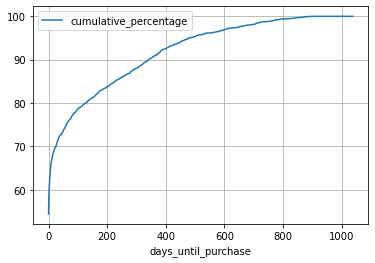

In [93]:
# Plot the cumulative percentage of the days until the sale
freq_df.plot(x = 'days_until_purchase', y = ['cumulative_percentage'], grid = True)

In [94]:
days_until_purchase_95_confidence = freq_df.loc[freq_df['cumulative_percentage'] <= 95, 'days_until_purchase'].max()
days_until_purchase_95_confidence

476

In [ ]:
#We will fit a random forest to be able to use the cumulative percentage as a variable later.

#from sklearn.ensemble import RandomForestRegressor

## Split the data into training and testing sets
#train_size = 0.8
#train_index = int(train_size * len(freq_df))
#train_data = freq_df.iloc[:train_index, :]
#test_data = freq_df.iloc[train_index:, :]

# Prepare the input and output data for training and testing
#X_train = train_data['days_until_purchase'].values.reshape(-1, 1)
#y_train = train_data['cumulative_percentage'].values
#X_test = test_data['days_until_purchase'].values.reshape(-1, 1)
#y_test = test_data['cumulative_percentage'].values

# Initialize the model and fit to the training data
#rf = RandomForestRegressor(n_estimators=100, random_state=42)
#rf.fit(X_train, y_train)

## Predict the cumulative percentage for the testing data
#y_pred = rf.predict(X_test)

# Evaluate the model performance on the testing data
#from sklearn.metrics import mean_squared_error, r2_score
#mse = mean_squared_error(y_test, y_pred)
#r2 = r2_score(y_test, y_pred)
#print("Mean squared error: {:.2f}".format(mse))
#print("R-squared: {:.2f}".format(r2))

In [ ]:
# Fit the model to all data
#X = freq_df['days_until_purchase'].values.reshape(-1, 1)
#y = freq_df['cumulative_percentage'].values
#rf.fit(X, y)

# Predict the cumulative percentage for all data
#y_pred = rf.predict(X)

# Plot the real curve and predicted curve
#plt.plot(X, y, label='Real')
#plt.plot(X, y_pred, label='Predicted')
#plt.xlabel('Days until purchase')
#plt.ylabel('Cumulative percentage')
#plt.legend()
#plt.show()

In [ ]:
# Define the value of days_until_purchase
#days_until_purchase = 326
#x = np.array([[days_until_purchase]])

# Use the random forest model to predict the cumulative percentage
#y_pred = rf.predict(x)

# Print the predicted value
#print("Predicted cumulative percentage for days_until_purchase = ",days_until_purchase,": {:.2f}".format(y_pred[0]))

### <font color='313187'>Two paths of evaluation: random test data selection and timeline-based approach<font><a class='anchor' id='TimelineBased'></a> [↑](#top)

When considering the methodology, it is crucial to take into account how the problem will be solved in a production environment. While this thesis has utilized a typical train-validation-test split with random shuffling of the data, it is important to acknowledge the need for a more realistic approach that considers timelines. Specifically, instead of randomly selecting the test data, it is recommended to use recent data as the test set.

Even when using random test data selection, we will still establish a "Today" date and remove all future data to avoid any data leakage. And we will also delete those users known as non clients that we would use a target in a backtesting scenario (all users registered 476 days before "today").

In [101]:
# Get date that splits non-buyers from target users
today_date = datetime.strptime("2021-01-27", '%Y-%m-%d')
days_to_subtract = days_until_purchase_95_confidence
splits_date = today_date - timedelta(days=days_to_subtract)

print(splits_date)

2019-10-09 00:00:00


As we can see in the cumulative percentage days until purchase plot, 95% of users buy before print 476 days. That means that if a user has not purchased in more than 491 days, we can classify this user as a "non-buyer" with a 95% confidence. As we have seen while checking the dates in the datasets, we will be able to use only some of the registered users where IND_CLIENTE = 0 as a "non-buyers". Let's say our "TODAY" = 2021-01-27. In that scenario, all users registered before 2019-09-24 can be classified as "non-buyers". And the users registered from 2019-10-09 upto 2021-01-27 would be the users we would need to predict in a back testing scenario when using a time-line based evaluation model to see if they can be clients or not. Let's see how many users we have in each bucket:

In [102]:
filtered_training = users[(users['FEC_REGISTRO'] < splits_date) & (users['IND_CLIENTE'] == 0)]
print('Number of Non-buyers:', filtered_training.shape[0])
filtered_target = users[(users['FEC_REGISTRO'] >= splits_date) & (users['IND_CLIENTE'] == 0)]
print('Number of target users:', filtered_target.shape[0])

Number of Non-buyers: 123465
Number of target users: 16595


### <font color='313187'>Board creation (feature engineering)<font><a class='anchor' id='Feature_engin'></a> [↑](#top)

After understanding the data and the problem to solve we will proceed creating the candidate variables to use in the model.

We first determine which is the "TODAY" date and the split_date, date that splits non buyers as non buyers or potential clients (target).

In [103]:
# Get date that splits non-buyers from target users
print('Todays date is:',today_date)
print('Splits date is:',splits_date)

Todays date is: 2021-01-27 00:00:00
Splits date is: 2019-10-09 00:00:00


And we eliminate any information we have in the future for all tables.

In [104]:
# Eliminate future data
users_without_future = users.copy() # fecha registro & fecha cliente <= today_date
promprod_sales_without_future = promotional_sales.copy() # FECHACONSUMO >= todaay_date
sessions_without_future = sessions.copy() # FECHA_SESION >= today_date
sales_without_future = sales.copy() # FECHAVENTA >= today_date

num_row = users_without_future.shape[0]
users_without_future = users_without_future[(pd.isnull(users_without_future['FEC_REGISTRO']) |
                                             (users_without_future['FEC_REGISTRO'] <= today_date)) &
                                            (pd.isnull(users_without_future['FEC_CLIENTE']) |
                                             (users_without_future['FEC_CLIENTE'] <= today_date))]
print('Users future lost: ',users_without_future.shape[0] - num_row)

num_row = promprod_sales_without_future.shape[0]
promprod_sales_without_future = promprod_sales_without_future[promprod_sales_without_future['FECHACONSUMO'] <= today_date]
print('Promotional product future lost: ',promprod_sales_without_future.shape[0] - num_row)

num_row = sessions_without_future.shape[0]
sessions_without_future = sessions_without_future[sessions_without_future['FECHA_SESION'] <= today_date]
print('Sessions future lost: ',sessions_without_future.shape[0] - num_row)

num_row = sales_without_future.shape[0]
sales_without_future = sales_without_future[sales_without_future['FECHAVENTA'] <= today_date]
print('Sales future lost: ',sales_without_future.shape[0] - num_row)

Users future lost:  0
Promotional product future lost:  0
Sessions future lost:  -1841
Sales future lost:  0


In [105]:
# Check how many users we have delete future data from
user_with_session_after_2021_01_27 = sessions[sessions['FECHA_SESION'] > today_date]['IDUSUARIO'].unique()
print('Number of users we deleted future data from: ',len(user_with_session_after_2021_01_27))

# Check how many of those are clients (should be none)
print('Total number of clients from which we deleted future data: ',len(np.intersect1d(user_with_session_after_2021_01_27, clients)))

Number of users we deleted future data from:  1571
Total number of clients from which we deleted future data:  0


#### <font color='313187'>Variables related to the user information<font><a class='anchor' id='Feature_engin_user'></a> [↑](#top)

Then we start with the variables related to the users:

We suggest the following variables (all of them by user):

- DONE: user_type
- DONE: registration_channel
- DONE: mail_type
- DONE: mail_validity
- DONE: user_company_type
- DONE: user_company_size
- DONE: user_company_ciiu
- DONE: user_company_status
- DONE: user_company_province

Variables affected by time:
- DONE: days_until_purchase*

*We will need it in order to create the different client types as we will apply different models to each type of client:
- client_0: clients that buy the same day of registration
- client_week: clients that buy from the second day of registration up to a week (7 days after day of registration)
- client_month: clients that buy from 7 days after registration up to a month (31 days after registration)
- client_other: clients that buy from 30 days after registration up to any moment.


In [143]:
# Create board with users features
df_board = users_without_future.copy()

# Create column to identify if a user is a target or part of the training-test-validation set
df_board['is_target'] = (df_board['FEC_REGISTRO'] >= splits_date) & (df_board['IND_CLIENTE'] == 0)

# Update client date column to have today as a date for those users that are not clients
# Set the values in FEC_CLIENTE to today's date for IND_CLIENTE == 0
df_board.loc[df_board['IND_CLIENTE'] == 0, 'FEC_CLIENTE'] = today_date

In [144]:
# Create variable that represents the number of days since registration until purchase (or today if it's not a client)
df_board['days_until_purchase'] = (df_board['FEC_CLIENTE'] - df_board['FEC_REGISTRO']).dt.days

In [146]:
## Classify clients by days until purchase

# Define the conditions
conditions = [
    (df_board['IND_CLIENTE'] == 1) & (df_board['days_until_purchase'] == 0),
    (df_board['IND_CLIENTE'] == 1) & (df_board['days_until_purchase'] >= 1) & (df_board['days_until_purchase'] < 7),
    (df_board['IND_CLIENTE'] == 1) & (df_board['days_until_purchase'] >= 7) & (df_board['days_until_purchase'] < 32),
    (df_board['IND_CLIENTE'] == 1) & (df_board['days_until_purchase'] >= 32),
    (df_board['IND_CLIENTE'] == 0)
]

# Define the labels for each condition
labels = ['client_0', 'client_week', 'client_month', 'client_other','no_client']

# Create the new column based on the conditions and labels
df_board['client_category'] = np.select(conditions, labels, default='unknown')

df_board.client_category.value_counts()

no_client       140060
client_0          1392
client_other       732
client_week        255
client_month       179
Name: client_category, dtype: int64

In [ ]:
# Add cumulative percentage of clients buying on the day untill purchase
#df_board = pd.merge(df_board, freq_df[['days_until_purchase','percentage','cumulative_percentage']],
#                    on=['days_until_purchase'],
#                    how='left')

### Impute missing values of cumulative percentage with trained random forest
# Identify rows where cumulative_percentage is missing
#missing_rows = df_board['cumulative_percentage'].isnull()

# Prepare input data for prediction
#X_missing = df_board[missing_rows]['days_until_purchase'].values.reshape(-1, 1)

# Make predictions using the trained random forest model
#y_missing = rf.predict(X_missing)

# Replace missing values with predicted values
#df_board.loc[missing_rows, 'cumulative_percentage'] = y_missing

In [147]:
# Rename columns
df_board = df_board.rename(columns={'IDUSUARIO': 'user_id',
                                    'IND_CLIENTE': 'is_client',
                                    'FEC_REGISTRO': 'registration_date',
                                    'FEC_CLIENTE': 'client_date',
                                    'CANAL_REGISTRO': 'registration_channel',
                                    'TIPOEMAIL': 'mail_type',
                                    'BONDAD_EMAIL': 'mail_validity',
                                    'TIPOUSUARIO': 'user_type',
                                    'USU_TIPO': 'user_company_type',
                                    'USU_TAMANIO': 'user_company_size',
                                    'USU_CIIU': 'user_company_ciiu',
                                    'USU_ESTADO': 'user_company_status',
                                    'USU_DEPARTAMENTO': 'user_company_province'})
                                    #'cumulative_percentage':'cum_perc_clients_buying_day_x'})

# Reorder columns
df_board = df_board[['user_id',
                     'is_client',
                     'client_category',
                     'is_target',
                     'registration_date',
                     'client_date',
                     'days_until_purchase',
                     #'cum_perc_clients_buying_day_x',
                     'registration_channel',
                     'mail_type',
                     'mail_validity',
                     'user_type',
                     'user_company_type',
                     'user_company_size',
                     'user_company_ciiu',
                     'user_company_status',
                     'user_company_province']]

In [148]:
print(df_board.shape)
df_board.head() 

(142618, 16)


,user_id,is_client,client_category,is_target,registration_date,client_date,days_until_purchase,registration_channel,mail_type,mail_validity,user_type,user_company_type,user_company_size,user_company_ciiu,user_company_status,user_company_province
0,7668403,0,no_client,False,2019-03-14,2021-01-27,685,3.0,gmail.com,20,PF,NaN,NaN,NaN,NaN,NaN
1,7667922,0,no_client,False,2019-03-14,2021-01-27,685,2.0,hotmail.com,20,PF,NaN,NaN,NaN,NaN,NaN
2,7721206,0,no_client,False,2019-04-10,2021-01-27,658,4.0,ilc.com.co,20,PJ,NaN,NaN,NaN,NaN,CALDAS
3,7667953,0,no_client,False,2019-03-14,2021-01-27,685,3.0,gmail.com,20,PJ,EMPRESARIO INDIVIDUAL,MC,M7110,ACTIVA,BOGOTA
4,7667971,0,no_client,False,2019-03-14,2021-01-27,685,3.0,acadia.com.co,20,PJ,SOCIEDAD COMERCIAL/INDUSTRIAL,PQ,L6810,ACTIVA,BOGOTA


In [149]:
# Check missing
df_board.isnull().sum()

user_id                       0
is_client                     0
client_category               0
is_target                     0
registration_date             0
client_date                   0
days_until_purchase           0
registration_channel       3520
mail_type                     0
mail_validity                 0
user_type                     0
user_company_type        109348
user_company_size        109347
user_company_ciiu        109347
user_company_status      109347
user_company_province    106711
dtype: int64

#### <font color='313187'>Variables related to the promotional products<font><a class='anchor' id='Feature_engin_promprod'></a> [↑](#top)

We continue with the variables related to the promotional products.

We suggest the following variables (all of them by user):

Absolute numbers:
- DONE: num_unique_promprod*
- DONE: num_unique_promprod_basic
- DONE: num_unique_promprod_profile
- DONE: num_visits_promprod*
- DONE: num_visits_promprod_basic
- DONE: num_visits_promprod_profile
- DONE: num_visits_company_state
- DONE: num_visited_companies
- DONE: num_unique_visits_dates

Variables affected by time (having more than one day where the user has consumed promotional products):
- DONE: days_until_first_promprod
- avg_days_between_promprod
- DONE: days_since_last_promprod
- days_since_first_promprod
- increment_of_promotional_products

*variables that can be obtained with a combination of others

In [155]:
# Get promprod_feat table
promprod_feat = promprod_sales_without_future.copy()
print(promprod_feat.shape)

(570892, 9)


Before generating the variables we check the behaviour of the visitors. Specifically we want to know if users visits to consume promotional products occur in different days or mainly in one day. This way we can identify how relevant the variables affected by time can be.

In [156]:
### Calculate number of different dates consuming by user

# Group by user ID and count the unique dates
num_dates_by_user = promprod_feat.groupby('IDUSUARIO')['FECHACONSUMO'].nunique()

# Create a new column with the number of different dates by user
promprod_feat['num_dates_by_user'] = promprod_feat['IDUSUARIO'].map(num_dates_by_user)

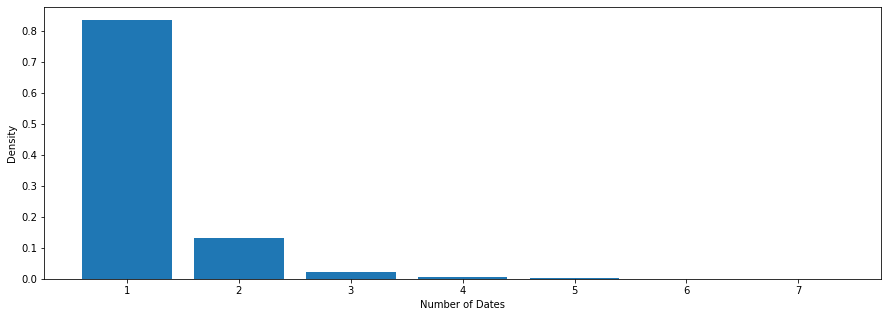

In [160]:
## Plot distribution of dates by user
# Create the figure with the desired figsize
fig = plt.figure(figsize=(15, 5))

# Get unique values to plot
to_plot = promprod_feat[['IDUSUARIO', 'num_dates_by_user']].drop_duplicates()

# Get the unique values and their frequencies
unique_values, frequencies = np.unique(to_plot['num_dates_by_user'], return_counts=True)

# Normalize frequencies to calculate density
density = frequencies / np.sum(frequencies)

# Filter the values up to 15
filtered_values = unique_values[unique_values <= 7]
filtered_density = density[:len(filtered_values)]

# Create the bar plot
plt.bar(filtered_values, filtered_density, width=0.8)

# Set the x-axis tick labels
plt.xticks(filtered_values)

# Set the axis labels
plt.xlabel('Number of Dates')
plt.ylabel('Density')

# Show the bar plot
plt.show()



We can see that 80% of users consume (visits the website to check) promotional products in one day. This means that the variables affected by time might not be as relevant as we could think. We will prioritize generating the other variables first.

In [173]:
promprod_feat.head(16)

,IDCONSUMO,IDUSUARIO,IDPRODUCTO,DESCPRODUCTO,FECHACONSUMO,EMPCONSUL_ID,EMPCONSUL_CIIU,EMPCONSUL_PROV,EMPCONSUL_EST,num_dates_by_user,user_prod_company_id,num_unique_promprod,num_unique_promprod_basic,num_unique_promprod_profile,num_visits_promprod,num_visits_promprod_basic,num_visits_promprod_profile,num_visited_companies
0,40057779,6868841,144920,Perfil Promocional,2018-01-01,2971771,P8544,BOGOTA,ACTIVA,1,6868841_144920_2971771,6,3.0,3.0,7,4.0,3.0,4
1,40057785,6868841,144917,Ficha Básica,2018-01-01,1520173,K6412,BOGOTA,CANCELACION,1,6868841_144917_1520173,6,3.0,3.0,7,4.0,3.0,4
2,40057775,6868841,144917,Ficha Básica,2018-01-01,2971771,P8544,BOGOTA,ACTIVA,1,6868841_144917_2971771,6,3.0,3.0,7,4.0,3.0,4
3,40057773,6868841,144917,Ficha Básica,2018-01-01,670007,7499,SANTANDER,ACTIVA,1,6868841_144917_670007,6,3.0,3.0,7,4.0,3.0,4
4,40057767,6868841,144917,Ficha Básica,2018-01-01,2971771,P8544,BOGOTA,ACTIVA,1,6868841_144917_2971771,6,3.0,3.0,7,4.0,3.0,4
5,40057758,6868841,144920,Perfil Promocional,2018-01-01,915924,S9609,BOGOTA,ACTIVA,1,6868841_144920_915924,6,3.0,3.0,7,4.0,3.0,4
6,40057786,6868841,144920,Perfil Promocional,2018-01-01,1520173,K6412,BOGOTA,CANCELACION,1,6868841_144920_1520173,6,3.0,3.0,7,4.0,3.0,4
7,40057765,6868844,144920,Perfil Promocional,2018-01-01,3830723,G4642,BOGOTA,ACTIVA,1,6868844_144920_3830723,1,NaN,1.0,1,NaN,1.0,1
8,40057847,6868850,144920,Perfil Promocional,2018-01-01,621535,9000,SANTANDER,ACTIVA,1,6868850_144920_621535,1,NaN,1.0,1,NaN,1.0,1
9,40057891,6868859,144920,Perfil Promocional,2018-01-01,2822732,N8010,SANTANDER,ACTIVA,2,6868859_144920_2822732,2,1.0,1.0,2,1.0,1.0,1


In [161]:
# Calculate how many unique promotional products has been consumed by user 
promprod_feat['user_prod_company_id'] = promprod_feat['IDUSUARIO'].astype(str) + '_' + promprod_feat['IDPRODUCTO'].astype(str) + '_' + promprod_feat['EMPCONSUL_ID'].astype(str)
num_prod_by_user = promprod_feat.groupby('IDUSUARIO')['user_prod_company_id'].nunique()
promprod_feat['num_unique_promprod'] = promprod_feat['IDUSUARIO'].map(num_prod_by_user)

In [163]:
# Calculate how many unique promotional products 'Ficha Básica' has been consumed by user 
num_prod_basic_by_user = promprod_feat[promprod_feat['DESCPRODUCTO'] == 'Ficha Básica'].groupby('IDUSUARIO')['user_prod_company_id'].nunique()
promprod_feat['num_unique_promprod_basic'] = promprod_feat['IDUSUARIO'].map(num_prod_basic_by_user)

In [164]:
# Calculate how many unique promotional products 'Perfil Promocional' has been consumed by user 
num_prod_profile_by_user = promprod_feat[promprod_feat['DESCPRODUCTO'] == 'Perfil Promocional'].groupby('IDUSUARIO')['user_prod_company_id'].nunique()
promprod_feat['num_unique_promprod_profile'] = promprod_feat['IDUSUARIO'].map(num_prod_profile_by_user)

In [166]:
# Calculate the number of visits consuming promotional products by user
promprod_feat['num_visits_promprod'] = promprod_feat.groupby('IDUSUARIO')['IDCONSUMO'].transform('count')

In [167]:
# Calculate the number of visits consuming promotional products 'Ficha Básica' by user
num_visits_basic_by_user = promprod_feat[promprod_feat['DESCPRODUCTO'] == 'Ficha Básica'].groupby('IDUSUARIO')['IDCONSUMO'].nunique()
promprod_feat['num_visits_promprod_basic'] = promprod_feat['IDUSUARIO'].map(num_visits_basic_by_user)

In [168]:
# Calculate the number of visits consuming promotional products 'Perfil Promocional' by user
num_visits_profile_by_user = promprod_feat[promprod_feat['DESCPRODUCTO'] == 'Perfil Promocional'].groupby('IDUSUARIO')['IDCONSUMO'].nunique()
promprod_feat['num_visits_promprod_profile'] = promprod_feat['IDUSUARIO'].map(num_visits_profile_by_user)

In [169]:
# Calculate how many companies consumed by user
promprod_feat['num_visited_companies'] = promprod_feat.groupby('IDUSUARIO')['EMPCONSUL_ID'].transform('nunique')

In [ ]:
# Calculate how many promotional products have been consumed by each user by company's state (ACTIVA, CANCELACION,...)
#for est in promprod_feat['EMPCONSUL_EST'].dropna().unique():
#    col_name = f'num_visits_company_{est.lower()}'
#    promprod_feat[col_name] = promprod_feat.groupby('IDUSUARIO')['EMPCONSUL_EST'].transform(lambda x: (x == est).sum())

In [174]:
### Calculate variables depending on time

promprod_feat_time_vars = promprod_feat.copy()

# Get first and last consume date by user
promprod_feat_time_vars['first_consume_date'] = promprod_feat_time_vars.groupby('IDUSUARIO')['FECHACONSUMO'].transform('min')
promprod_feat_time_vars['last_consume_date'] = promprod_feat_time_vars.groupby('IDUSUARIO')['FECHACONSUMO'].transform('max')

# Add registration date and purchase date from users table
promprod_feat_time_vars = pd.merge(promprod_feat_time_vars, df_board[['user_id', 'registration_date','client_date']], left_on=['IDUSUARIO'], right_on=['user_id'])

# Get days between the registration and the first consumed promotiontional product
promprod_feat_time_vars['days_until_first_promprod'] = (promprod_feat_time_vars['first_consume_date'] - promprod_feat_time_vars['registration_date']).dt.days

# Get days between the registration and the last consumed promotiontional product
promprod_feat_time_vars['days_until_last_promprod'] = (promprod_feat_time_vars['last_consume_date'] - promprod_feat_time_vars['registration_date']).dt.days


# Get days between the last consumed promotiontional product and purchase date
promprod_feat_time_vars['days_since_last_promprod'] = (promprod_feat_time_vars['client_date'] - promprod_feat_time_vars['last_consume_date']).dt.days

In [175]:
# Select the variables to keep 
final_promprod_vars = promprod_feat_time_vars[['IDUSUARIO',
                                     'first_consume_date',
                                     'last_consume_date',
                                     'num_dates_by_user',
                                     'days_until_first_promprod',
                                     'days_until_last_promprod',
                                     'days_since_last_promprod',
                                     'num_visited_companies',
                                     'num_unique_promprod',
                                     'num_unique_promprod_basic',
                                     'num_unique_promprod_profile',
                                     'num_visits_promprod',
                                     'num_visits_promprod_basic',
                                     'num_visits_promprod_profile']].drop_duplicates()
                                     #'num_visits_company_activa',
                                     #'num_visits_company_cancelacion',
                                     #'num_visits_company_liquidacion',
                                     #'num_visits_company_extinguida',
                                     #'num_visits_company_ley de insolvencia (reorganizacion empresarial)',
                                     #'num_visits_company_inactiva temporal',
                                     #'num_visits_company_intervenida',
                                     #'num_visits_company_reestructuracion o concordato',
                                     #'num_visits_company_coincidencia homografa lista clinton (sdnt ofac)',
                                     #'num_visits_company_anulaciën liquidaciën',
                                     #'num_visits_company_absorbida',
                                     #'num_visits_company_salida clinton (sdnt ofac)',
                                     #'num_visits_company_disuelta'

print(final_promprod_vars.shape)

(142591, 14)


We see that we have all the users in dt_board a part from the 27 (142618 - 142591) that haven't consumed any promotional product

In [176]:
# Rename columns
final_promprod_vars = final_promprod_vars.rename(columns={'IDUSUARIO': 'user_id',
                                                          'num_dates_by_user': 'num_unique_visits_dates'})
                                                          #'num_visits_company_ley de insolvencia (reorganizacion empresarial)':'num_visits_company_insolvencia',
                                                          #'num_visits_company_inactiva temporal': 'num_visits_company_inactiva_temporal',
                                                          #'num_visits_company_reestructuracion o concordato': 'num_visits_company_reestructuracion',
                                                          #'num_visits_company_coincidencia homografa lista clinton (sdnt ofac)': 'num_visits_company_coincidencia_homografa_lista_clinton',
                                                          #'num_visits_company_anulaciën liquidaciën':  'num_visits_company_anulacion_liquidacion',
                                                          #'num_visits_company_salida clinton (sdnt ofac)': 'num_visits_company_salida_clinton'})

In [177]:
# Check missing
final_promprod_vars.isnull().sum()

user_id                            0
first_consume_date                 0
last_consume_date                  0
num_unique_visits_dates            0
days_until_first_promprod          0
days_until_last_promprod           0
days_since_last_promprod           0
num_visited_companies              0
num_unique_promprod                0
num_unique_promprod_basic      38572
num_unique_promprod_profile    11305
num_visits_promprod                0
num_visits_promprod_basic      38572
num_visits_promprod_profile    11305
dtype: int64

All the previous missing comes from the fact of having an empty table when subseting promotional_sales by type product (basic or profile). So we will update those missing by 0. 

In [178]:
# Substitude missing by 0
final_promprod_vars.fillna(0, inplace=True)
final_promprod_vars.isnull().sum()

user_id                        0
first_consume_date             0
last_consume_date              0
num_unique_visits_dates        0
days_until_first_promprod      0
days_until_last_promprod       0
days_since_last_promprod       0
num_visited_companies          0
num_unique_promprod            0
num_unique_promprod_basic      0
num_unique_promprod_profile    0
num_visits_promprod            0
num_visits_promprod_basic      0
num_visits_promprod_profile    0
dtype: int64

In [179]:
# Merge with df_board
df_board_promprod = df_board.copy()
df_board_promprod = pd.merge(df_board, final_promprod_vars, on='user_id', how='left')

In [180]:
df_board_promprod.isnull().sum()

user_id                             0
is_client                           0
client_category                     0
is_target                           0
registration_date                   0
client_date                         0
days_until_purchase                 0
registration_channel             3520
mail_type                           0
mail_validity                       0
user_type                           0
user_company_type              109348
user_company_size              109347
user_company_ciiu              109347
user_company_status            109347
user_company_province          106711
first_consume_date                 27
last_consume_date                  27
num_unique_visits_dates            27
days_until_first_promprod          27
days_until_last_promprod           27
days_since_last_promprod           27
num_visited_companies              27
num_unique_promprod                27
num_unique_promprod_basic          27
num_unique_promprod_profile        27
num_visits_p

We see reflected the missing from the 27 users that didn't consume any promotional product.

#### <font color='313187'>Variables related to the consulted companies<font><a class='anchor' id='Feature_engin_companies'></a> [↑](#top)

We suggest the following variables (all of them by user):

Absolute numbers:
- DONE: num_users_visiting_checked_companies
- DONE: num_visits_checked_companies_receive
- DONE: num_clients_visiting_checked_companies
- DONE: num_clients_visits_checked_companies
- DONE: num_clients_by_users_visiting_checked_companies*
- DONE: num_clients_visits_by_visits_checked_companies*


*variables that can be obtained with a combination of others

In [181]:
# Get companies_feat table
companies_feat = promprod_sales_without_future.copy()
companies_feat.head()

,IDCONSUMO,IDUSUARIO,IDPRODUCTO,DESCPRODUCTO,FECHACONSUMO,EMPCONSUL_ID,EMPCONSUL_CIIU,EMPCONSUL_PROV,EMPCONSUL_EST
0,40057779,6868841,144920,Perfil Promocional,2018-01-01,2971771,P8544,BOGOTA,ACTIVA
1,40057785,6868841,144917,Ficha Básica,2018-01-01,1520173,K6412,BOGOTA,CANCELACION
2,40057775,6868841,144917,Ficha Básica,2018-01-01,2971771,P8544,BOGOTA,ACTIVA
3,40057773,6868841,144917,Ficha Básica,2018-01-01,670007,7499,SANTANDER,ACTIVA
4,40057767,6868841,144917,Ficha Básica,2018-01-01,2971771,P8544,BOGOTA,ACTIVA


In [182]:
# Add who is client and who is target
companies_feat = pd.merge(companies_feat, df_board[['user_id','is_client', 'is_target']], left_on=['IDUSUARIO'], right_on=['user_id'], how='left')

# Get the number of client visits (excluding target) by company
num_client_visits_by_company = companies_feat[companies_feat['is_client'] == 1].groupby('EMPCONSUL_ID')['IDCONSUMO'].nunique()
companies_feat['num_client_visits_by_company'] = companies_feat['EMPCONSUL_ID'].map(num_client_visits_by_company).fillna(0)

# Get the number of visits (excluding target) by company
num_visits_by_company = companies_feat[companies_feat['is_target'] == False].groupby('EMPCONSUL_ID')['IDCONSUMO'].nunique()
companies_feat['num_visits_by_company'] = companies_feat['EMPCONSUL_ID'].map(num_visits_by_company).fillna(0)

# Get number of clients (excluding target) visiting by company
num_clients_by_company = companies_feat[companies_feat['is_client'] == 1].groupby('EMPCONSUL_ID')['IDUSUARIO'].nunique()
companies_feat['num_clients_by_company'] = companies_feat['EMPCONSUL_ID'].map(num_clients_by_company).fillna(0)

# Get number of users (excluding target) visiting by company
num_users_by_company = companies_feat[companies_feat['is_target'] == False].groupby('EMPCONSUL_ID')['IDUSUARIO'].nunique()
companies_feat['num_users_by_company'] = companies_feat['EMPCONSUL_ID'].map(num_users_by_company).fillna(0)

# Calculate previous variables by checked companies for each user
companies_vars_by_user_company = companies_feat[['user_id',
                                                 'EMPCONSUL_ID',
                                                 'num_client_visits_by_company',
                                                 'num_visits_by_company',
                                                 'num_clients_by_company',
                                                 'num_users_by_company']].drop_duplicates()

companies_vars_by_user = companies_vars_by_user_company.drop("EMPCONSUL_ID", axis=1).groupby('user_id').sum()

#### Calculate the ratio
# Get  number of client visits (excluding target) by users visits
# Impute 0 for those companies that hasn't been consulted
companies_vars_by_user['num_clients_visits_by_visits'] = np.where(companies_vars_by_user['num_visits_by_company'] == 0, 0,
                                                                  companies_vars_by_user['num_client_visits_by_company'] / companies_vars_by_user['num_visits_by_company'])

# Get number of clients (excluding target) by number of users visiting promotion products
# Impute 0 for those companies that hasn't been consulted
companies_vars_by_user['num_clients_by_users_visiting'] = np.where(companies_vars_by_user['num_users_by_company'] == 0, 0, 
                                                                   companies_vars_by_user['num_clients_by_company'] / companies_vars_by_user['num_users_by_company'])

print(companies_vars_by_user.shape)
companies_vars_by_user.head()

(142591, 6)


,num_client_visits_by_company,num_visits_by_company,num_clients_by_company,num_users_by_company,num_clients_visits_by_visits,num_clients_by_users_visiting
user_id,,,,,,
6868841,0.0,18.0,0.0,13.0,0.0,0.0
6868844,0.0,13.0,0.0,4.0,0.0,0.0
6868850,0.0,1.0,0.0,1.0,0.0,0.0
6868859,0.0,5.0,0.0,4.0,0.0,0.0
6868870,0.0,25.0,0.0,12.0,0.0,0.0


In [183]:
# Merge with df_board
df_board_companies = df_board_promprod.copy()
df_board_companies = pd.merge(df_board_promprod, companies_vars_by_user, on='user_id', how='left')
print(df_board_companies.shape)

(142618, 35)


In [184]:
# Check missing
df_board_companies.isnull().sum()

user_id                               0
is_client                             0
client_category                       0
is_target                             0
registration_date                     0
client_date                           0
days_until_purchase                   0
registration_channel               3520
mail_type                             0
mail_validity                         0
user_type                             0
user_company_type                109348
user_company_size                109347
user_company_ciiu                109347
user_company_status              109347
user_company_province            106711
first_consume_date                   27
last_consume_date                    27
num_unique_visits_dates              27
days_until_first_promprod            27
days_until_last_promprod             27
days_since_last_promprod             27
num_visited_companies                27
num_unique_promprod                  27
num_unique_promprod_basic            27


#### <font color='313187'>Variables related to the sessions<font><a class='anchor' id='Feature_engin_sessions'></a> [↑](#top)

We suggest the following variables (all of them by user):

Absolute numbers:
- DONE: num_total_sessions
- DONE: num_unique_sessions_dates
- percentage_dates_sessions_consuming_promprod

Variables affected by time (having more than one day where the user has visited the webside):
- DONE: num_sessions_until_first_promprod
- avg_sessions_between_promoprod
- DONE: num_sessions_since_last_promprod
- num_sessions_since_first_promprod
- avg_days_between_sessions
- DONE: days_since_last_session
- increment_of_sessions

*variables that can be obtained with a combination of others

In [197]:
# Get sessions_feat table
sessions_feat = sessions_without_future.copy().sort_values(by='IDUSUARIO')
sessions_feat.head()

,IDUSUARIO,FECHA_SESION,SESIONES
0,6868841,2018-01-01,12
1,6868844,2018-01-01,4
2,6868850,2018-01-01,4
3,6868859,2018-01-01,3
4,6868859,2018-07-09,1


In [198]:
# Get number of total sessions by user
sessions_feat['num_total_sessions'] = sessions_feat.groupby('IDUSUARIO')['SESIONES'].transform('sum')

# Get number of unique session dates by user
num_dates_by_user = sessions_feat.groupby('IDUSUARIO')['FECHA_SESION'].nunique()
sessions_feat['num_unique_sessions_dates'] = sessions_feat['IDUSUARIO'].map(num_dates_by_user)

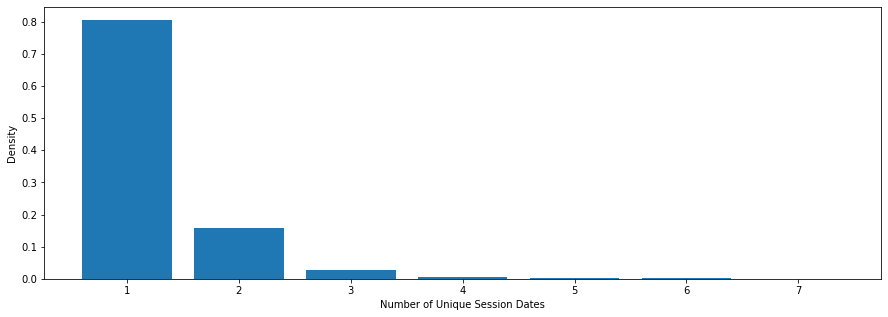

In [199]:
## Plot distribution of session dates by user
# Create the figure with the desired figsize
fig = plt.figure(figsize=(15, 5))

# Get unique values to plot
to_plot = sessions_feat[['IDUSUARIO', 'num_total_sessions', 'num_unique_sessions_dates']].drop_duplicates()

# Get the unique values and their frequencies
unique_values, frequencies = np.unique(to_plot['num_unique_sessions_dates'], return_counts=True)

# Normalize frequencies to calculate density
density = frequencies / np.sum(frequencies)

# Filter the values up to 15
filtered_values = unique_values[unique_values <= 7]
filtered_density = density[:len(filtered_values)]

# Create the bar plot
plt.bar(filtered_values, filtered_density, width=0.8)

# Set the x-axis tick labels
plt.xticks(filtered_values)

# Set the axis labels
plt.xlabel('Number of Unique Session Dates')
plt.ylabel('Density')

# Show the bar plot
plt.show()


We can see that most users only have conected 1 day.

In [196]:
# Create percentage_dates_sessions_consuming_promprod variable
date_session = sessions_feat[['IDUSUARIO','FECHA_SESION']].drop_duplicates()
date_promo = promprod_feat[['IDUSUARIO','FECHACONSUMO']].drop_duplicates()

df = pd.merge(date_session, date_promo, on='IDUSUARIO', how='outer')
print(df.shape)
print(df.isnull().sum())

(337707, 3)
IDUSUARIO        0
FECHA_SESION     0
FECHACONSUMO    31
dtype: int64


As we can see, almost in all sessions the users have consumed promotional products so the variable percentage_dates_sessions_consuming_promprod would not be usefull to the model. Which means the number unique sessions date will be almost the same as num_unique_visits_dates and we will need to drop one of them. The same will happend with days_since_last_session and days_since_last_promoprod.

In [200]:
# Add registration date and purchase date from board table
sessions_feat = pd.merge(sessions_feat,
                         df_board_companies[['user_id', 'client_date','first_consume_date','last_consume_date']], 
                         left_on=['IDUSUARIO'], right_on=['user_id'])

# Get first and last session date by user
sessions_feat['first_session_date'] = sessions_feat.groupby('IDUSUARIO')['FECHA_SESION'].transform('min')
sessions_feat['last_session_date'] = sessions_feat.groupby('IDUSUARIO')['FECHA_SESION'].transform('max')

# Get days between the last session and purchase date
sessions_feat['days_since_last_session'] = (sessions_feat['client_date'] - sessions_feat['last_session_date']).dt.days

# Get number of sessions until first promotional product consumed
num_sessions_until_first_consume_by_user = sessions_feat[sessions_feat['FECHA_SESION'] <= sessions_feat['first_consume_date']].groupby('IDUSUARIO')['SESIONES'].sum()
sessions_feat['num_sessions_until_first_promprod'] = sessions_feat['IDUSUARIO'].map(num_sessions_until_first_consume_by_user)

# Get number of sessions until last promotional product consumed
num_sessions_until_last_consume_by_user = sessions_feat[sessions_feat['FECHA_SESION'] <= sessions_feat['last_consume_date']].groupby('IDUSUARIO')['SESIONES'].sum()
sessions_feat['num_sessions_until_last_promprod'] = sessions_feat['IDUSUARIO'].map(num_sessions_until_last_consume_by_user)

# Get number of sessions since last promotional product consumed
num_sessions_since_last_promprod_by_user = sessions_feat[sessions_feat['FECHA_SESION'] >= sessions_feat['last_consume_date']].groupby('IDUSUARIO')['SESIONES'].sum()
sessions_feat['num_sessions_since_last_promprod'] = sessions_feat['IDUSUARIO'].map(num_sessions_since_last_promprod_by_user)


sessions_feat.head(6)

,IDUSUARIO,FECHA_SESION,SESIONES,num_total_sessions,num_unique_sessions_dates,user_id,client_date,first_consume_date,last_consume_date,first_session_date,last_session_date,days_since_last_session,num_sessions_until_first_promprod,num_sessions_until_last_promprod,num_sessions_since_last_promprod
0,6868841,2018-01-01,12,12,1,6868841,2021-01-27,2018-01-01,2018-01-01,2018-01-01,2018-01-01,1122,12.0,12.0,12.0
1,6868844,2018-01-01,4,4,1,6868844,2021-01-27,2018-01-01,2018-01-01,2018-01-01,2018-01-01,1122,4.0,4.0,4.0
2,6868850,2018-01-01,4,4,1,6868850,2021-01-27,2018-01-01,2018-01-01,2018-01-01,2018-01-01,1122,4.0,4.0,4.0
3,6868859,2018-01-01,3,4,2,6868859,2021-01-27,2018-01-01,2018-07-09,2018-01-01,2018-07-09,933,3.0,4.0,1.0
4,6868859,2018-07-09,1,4,2,6868859,2021-01-27,2018-01-01,2018-07-09,2018-01-01,2018-07-09,933,3.0,4.0,1.0
5,6868870,2018-01-01,10,10,1,6868870,2021-01-27,2018-01-01,2018-01-01,2018-01-01,2018-01-01,1122,10.0,10.0,10.0


In [201]:
# Select final variables from sessions
sessions_feat_final_vars = sessions_feat[['user_id',
                                          'first_session_date',
                                          'last_session_date',
                                          'num_total_sessions',
                                          'num_unique_sessions_dates',
                                          'days_since_last_session',
                                          'num_sessions_until_first_promprod',
                                          'num_sessions_until_last_promprod',
                                          'num_sessions_since_last_promprod']].drop_duplicates()

In [202]:
# Merge with df_board
df_board_final = df_board_companies.copy()
df_board_final = pd.merge(df_board_companies, sessions_feat_final_vars, on='user_id', how='left')
print(df_board_final.shape)

(142618, 43)


### <font color='313187'>Dealing with missing<font><a class='anchor' id='Missing'></a> [↑](#top)

Having created the candidate variables, now it is time to review and impute the missing values and outliers.

In [203]:
# Check missing
df_board_final.isnull().sum()

user_id                                   0
is_client                                 0
client_category                           0
is_target                                 0
registration_date                         0
client_date                               0
days_until_purchase                       0
registration_channel                   3520
mail_type                                 0
mail_validity                             0
user_type                                 0
user_company_type                    109348
user_company_size                    109347
user_company_ciiu                    109347
user_company_status                  109347
user_company_province                106711
first_consume_date                       27
last_consume_date                        27
num_unique_visits_dates                  27
days_until_first_promprod                27
days_until_last_promprod                 27
days_since_last_promprod                 27
num_visited_companies           

#### <font color='313187'>Registration_channel missing<font><a class='anchor' id='missingRegistrationChannel'></a> [↑](#top)

In [204]:
# Check user type distribution for the rows with missing values in registration channel
subset = df_board_final[df_board_final['registration_channel'].isnull()]
freq = subset['user_type'].value_counts()
freq

PF    2636
PJ     780
PX     104
Name: user_type, dtype: int64

It seems like this missing are real missing (and not "not aplicable values"). As a simple approach, we will use a mode imputation (replacing missing values with the most frequent category) which as we can see below is 3 even within the different user types.

In [205]:
# Check registration channel classes and distribution
df_board_final.registration_channel.value_counts()

3.0    38199
1.0    29176
2.0    23954
7.0    13556
4.0    13535
8.0    13535
6.0     4741
9.0     2402
Name: registration_channel, dtype: int64

In [206]:
# Get registration channel mode by user type
mode_registration_channel_by_user_type = df_board_final.groupby('user_type')['registration_channel'].agg(lambda x: x.mode()[0]).reset_index()
mode_registration_channel_by_user_type

,user_type,registration_channel
0,PF,3.0
1,PJ,3.0
2,PX,3.0


In [207]:
# Impute missing values with mode
df_board_final['registration_channel'] = df_board_final['registration_channel'].fillna(df_board_final['registration_channel'].mode()[0])

#### <font color='313187'>User company variables missing<font><a class='anchor' id='missingUserCompanyVars'></a> [↑](#top)

In [85]:
df_board_final = pd.read_csv(path + 'df_board_final.csv')

In [208]:
# Check user company type for the rows with missing values in user company's variables
subset = df_board_final[df_board_final['user_company_type'].isnull()]
freq = subset['user_type'].value_counts()
freq

PF    101682
PX      4847
PJ      2819
Name: user_type, dtype: int64

In [87]:
df_board_final['user_company_type'].value_counts()

not_applicable                     106529
SOCIEDAD COMERCIAL/INDUSTRIAL       18817
EMPRESARIO INDIVIDUAL               14620
ENTIDAD FINANCIERA O DE SEGUROS      1063
ENTIDAD SIN ANIMO DE LUCRO           1011
ORGANISMO ESTATAL                     262
HOLDING                               177
ENTIDAD EXTRANJERA                    132
SOCIEDAD NO COMERCIAL                   5
INDUSTRIA / COMERCIO                    2
Name: user_company_type, dtype: int64

In [209]:
# Check user type distribution for the rows with missing values in user company's variables
subset = df_board_final[df_board_final['user_company_size'].isnull()]
freq = subset['user_type'].value_counts()
freq

PF    101682
PX      4847
PJ      2818
Name: user_type, dtype: int64

In [89]:
df_board_final['user_company_size'].value_counts()

not_applicable    106529
MC                 25892
PQ                  4377
MD                  2609
GR                  2522
SD                   689
Name: user_company_size, dtype: int64

In [210]:
# Check user type distribution for the rows with missing values in user company's variables
subset = df_board_final[df_board_final['user_company_ciiu'].isnull()]
freq = subset['user_type'].value_counts()
freq

PF    101682
PX      4847
PJ      2818
Name: user_type, dtype: int64

In [211]:
# Check user type distribution for the rows with missing values in user company's variables
subset = df_board_final[df_board_final['user_company_status'].isnull()]
freq = subset['user_type'].value_counts()
freq

PF    101682
PX      4847
PJ      2818
Name: user_type, dtype: int64

In [212]:
# Check user type distribution for the rows with missing values in user company's variables
subset = df_board_final[df_board_final['user_company_province'].isnull()]
freq = subset['user_type'].value_counts()
freq

PF    101682
PX      4847
PJ       182
Name: user_type, dtype: int64

It seems like the main missing comes from the fact that the user is a natural person (not representing any company). In this case the missing values are "not applicable" values rather than missing values. We will impute a new category for PF and PX as "not applicable", and the mode imputation for the PJ.

In [213]:
### Impute missing values

# Define categorical columns to impute missing
cols_to_impute = ['user_company_type', 'user_company_size', 'user_company_ciiu','user_company_status','user_company_province']

# Impute missing values with mode for PJ users
for col in cols_to_impute:
    mode_value = df_board_final[df_board_final['user_type']=='PJ'][col].mode()[0]
    df_board_final.loc[df_board_final['user_type'] == 'PJ', col] = df_board_final.loc[df_board_final['user_type'] == 'PJ', col].fillna(mode_value)

# Impute missing values with "not applicable" for PF and PX user types
value = 'not_applicable'
for col in cols_to_impute:
    df_board_final.loc[df_board_final['user_type'].isin(['PX', 'PF']), col] = df_board_final.loc[df_board_final['user_type'].isin(['PX', 'PF']), col].fillna(value)

In [214]:
# Check missing
df_board_final.isnull().sum()

user_id                               0
is_client                             0
client_category                       0
is_target                             0
registration_date                     0
client_date                           0
days_until_purchase                   0
registration_channel                  0
mail_type                             0
mail_validity                         0
user_type                             0
user_company_type                     0
user_company_size                     0
user_company_ciiu                     0
user_company_status                   0
user_company_province                 0
first_consume_date                   27
last_consume_date                    27
num_unique_visits_dates              27
days_until_first_promprod            27
days_until_last_promprod             27
days_since_last_promprod             27
num_visited_companies                27
num_unique_promprod                  27
num_unique_promprod_basic            27


#### <font color='313187'>Users without promotional products visits missing<font><a class='anchor' id='missingUsersPromprod'></a> [↑](#top)

The rest of the missing we have in the board table are because some users didn't consume (visit) any promotional product.
We will impute those missing values with 0s for the numerical columns and with a new category called "not_applicable" for columns first_consume_date and last_consume_date.

In [215]:
# Impute missing values with "not applicable" for first_consume_date and last_consume_date columns 
# Define categorical columns to impute missing
cols_to_impute = ['first_consume_date','last_consume_date']

value = 'not_applicable'
for col in cols_to_impute:
    df_board_final[col].fillna(value, inplace=True)

# Replace missing values with 0 for numerical columns
df_board_final.fillna(0, inplace=True)

In [216]:
# Check missing
df_board_final.isnull().sum()

user_id                              0
is_client                            0
client_category                      0
is_target                            0
registration_date                    0
client_date                          0
days_until_purchase                  0
registration_channel                 0
mail_type                            0
mail_validity                        0
user_type                            0
user_company_type                    0
user_company_size                    0
user_company_ciiu                    0
user_company_status                  0
user_company_province                0
first_consume_date                   0
last_consume_date                    0
num_unique_visits_dates              0
days_until_first_promprod            0
days_until_last_promprod             0
days_since_last_promprod             0
num_visited_companies                0
num_unique_promprod                  0
num_unique_promprod_basic            0
num_unique_promprod_profi

In [546]:
# Save board to a csv file
path = 'C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/MASTER/UOC/16 - Projecte final de master/outputs_dataframe/'
df_board_final.to_csv(path + 'df_board_final.csv', index=False)

### <font color='313187'>Exclude target users<font><a class='anchor' id='ExcludeTargetUsers'></a> [↑](#top)

In [547]:
# Delete target people as we still dont know if they are clients or not
df_board_analysis = df_board_final[df_board_final['is_target'] == 0].copy()
df_board_analysis.shape

(126023, 43)

In [548]:
# Save board to a csv file
path = 'C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/MASTER/UOC/16 - Projecte final de master/outputs_dataframe/'
df_board_analysis.to_csv(path + 'df_board_analysis.csv', index=False)

### <font color='313187'>Univariate analysis<font><a class='anchor' id='Univariate'></a> [↑](#top)

In [84]:
# Read board
path = 'C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/MASTER/UOC/16 - Projecte final de master/outputs_dataframe/'
df_board_analysis = pd.read_csv(path + 'df_board_analysis.csv')

In [8]:
df_board_analysis.shape

(126023, 43)

First we will check de distribution of how many days users conect by each client category. 

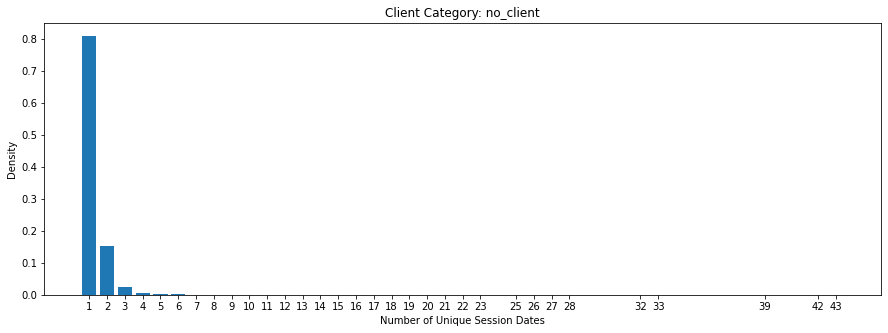

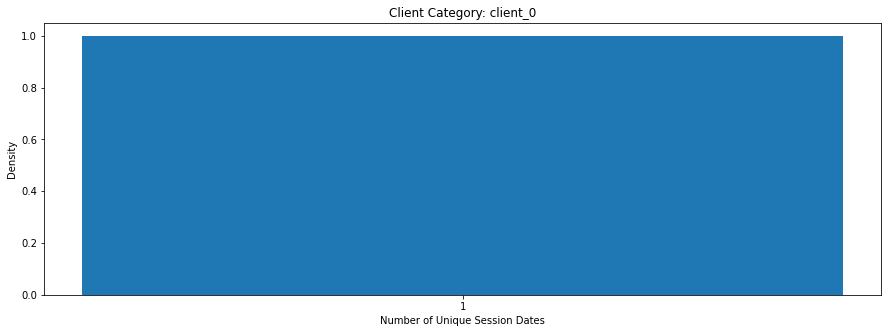

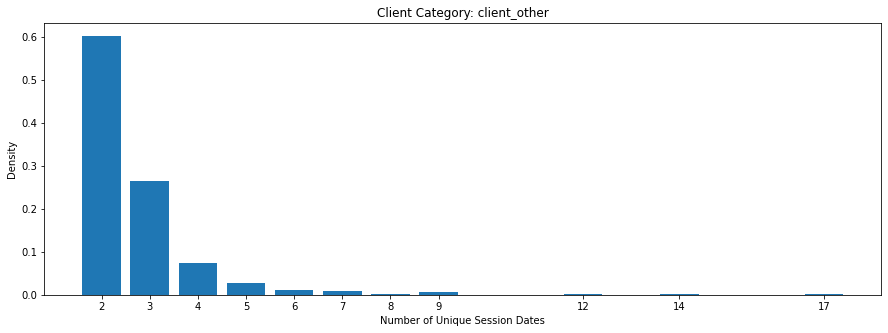

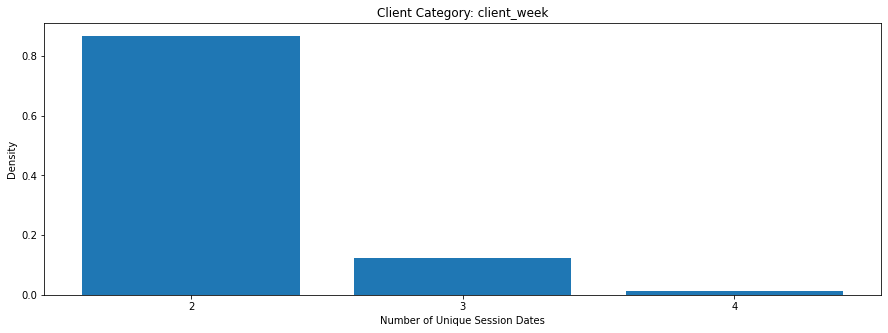

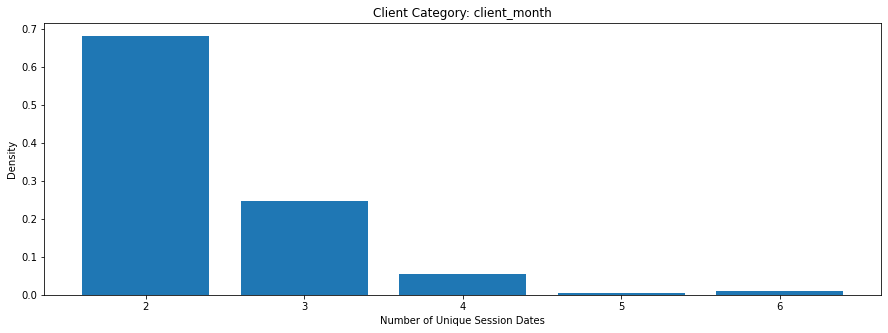

In [258]:
# Get unique values to plot
to_plot = df_board_analysis[['user_id', 'client_category', 'num_total_sessions', 'num_unique_sessions_dates']].drop_duplicates()

# Iterate over each client category
for category in to_plot['client_category'].unique():
    # Filter the data for the current client category
    category_data = to_plot[to_plot['client_category'] == category]

    # Get the unique values and their frequencies
    unique_values, frequencies = np.unique(category_data['num_unique_sessions_dates'], return_counts=True)

    # Normalize frequencies to calculate density
    density = frequencies / np.sum(frequencies)

    # Filter the values up to 50
    filtered_values = unique_values[unique_values <= 50]
    filtered_density = density[:len(filtered_values)]

    # Create the figure with the desired figsize
    fig, ax = plt.subplots(figsize=(15, 5))

    # Create the bar plot
    ax.bar(filtered_values, filtered_density, width=0.8)

    # Set the x-axis tick labels
    ax.set_xticks(filtered_values)

    # Set the axis labels
    ax.set_xlabel('Number of Unique Session Dates')
    ax.set_ylabel('Density')

    # Set the title
    ax.set_title(f'Client Category: {category}')

    # Show the bar plot
    plt.show()


As we can see from the previous plots, most of the users have connected only in one or two days.

Now we will chech the number of sessions:

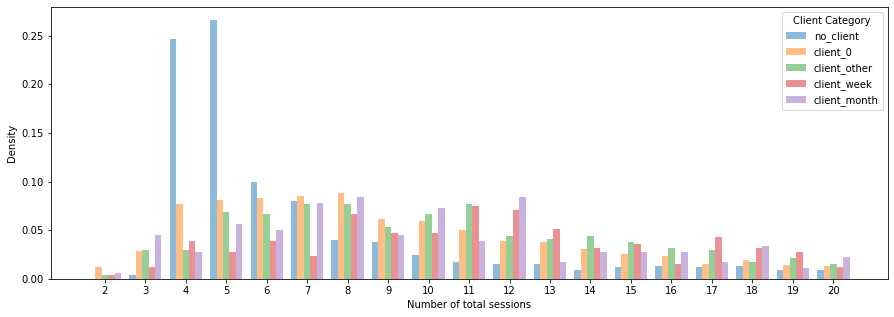

In [259]:
# Create the figure with the desired figsize
fig = plt.figure(figsize=(15, 5))

# Get unique values to plot
to_plot = df_board_analysis[['user_id', 'client_category', 'num_total_sessions', 'num_unique_sessions_dates']].drop_duplicates()

var_to_plot = 'num_total_sessions'
# Get the unique values and their frequencies
unique_values, frequencies = np.unique(to_plot[var_to_plot], return_counts=True)

# Filter the values up to 15
filtered_values = unique_values[unique_values <= 20]

# Calculate the width for each bar
bar_width = 0.8 / len(to_plot['client_category'].unique())

# Calculate the offset for each category
offset = bar_width * (len(to_plot['client_category'].unique()) - 1) / 2

# Iterate over each client category
for i, category in enumerate(to_plot['client_category'].unique()):
    # Filter the data for the current client category
    category_data = to_plot[to_plot['client_category'] == category]

    # Get the unique values and their frequencies
    unique_values, frequencies = np.unique(category_data[var_to_plot], return_counts=True)

    # Normalize frequencies to calculate density
    density = frequencies / np.sum(frequencies)

    # Filter the values up to 15
    filtered_density = density[:len(filtered_values)]

    # Calculate the adjusted x-coordinates for the bars
    x = filtered_values - offset + i * bar_width

    # Create the bar plot
    plt.bar(x, filtered_density, width=bar_width, alpha=0.5, label=category)

# Set the x-axis tick labels
plt.xticks(filtered_values)

# Set the axis labels
plt.xlabel('Number of total sessions')
plt.ylabel('Density')

# Add a legend
plt.legend(title='Client Category')

# Show the bar plot
plt.show()


#### <font color='313187'>Distributions for numerical variables<font><a class='anchor' id='DistributionsNumVars'></a> [↑](#top)

In [14]:
def plot_histogram(df, feature, xaxiscut):
    # Preparing the figure with a single plot
    fig, ax = plt.subplots(figsize=(8, 5))

    # Define the bin edges using linspace
    bin_edges = np.linspace(0, 1, 21)  # 20 evenly spaced bins

    # Plot histogram by client/non_client
    for client in df["is_client"].unique():
        color = 'C1' if client == 1 else 'C0'  # set color based on client value
        ax.hist(df.loc[df["is_client"] == client, feature],
                alpha=0.75,
                label="Client" if client == 1 else "Non-client",
                color=color,
                bins=range(int(df[feature].min()), xaxiscut, 1),
                width=0.5,
                density=True)
        ax.set_title(feature)
        ax.legend(loc='upper right')
        ax.set_ylabel('Density')

        # Format x-axis tick labels
        ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: format(int(x), ',')))

    # Adjusting the spacing between subplots
    fig.tight_layout()

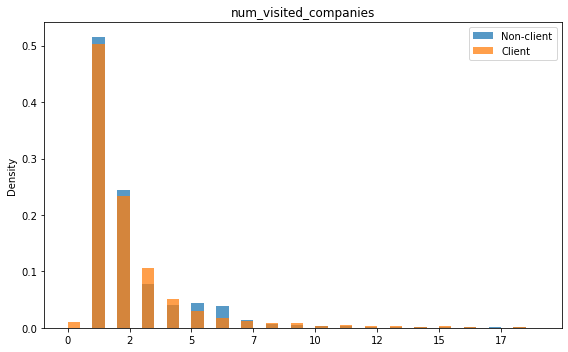

In [485]:
# PLot distribution for numerical variables
feat_to_explore = 'num_visited_companies'
plot_histogram(df_board_analysis, feat_to_explore, 20)

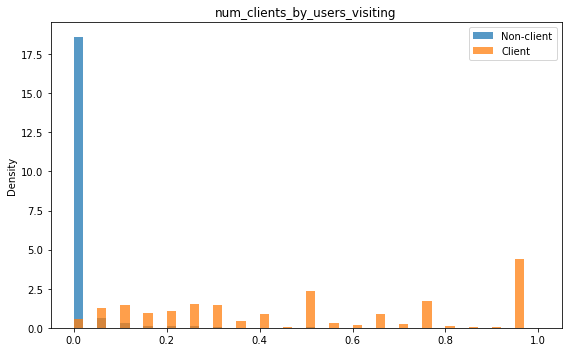

In [7]:
import matplotlib.ticker as mtick
# Select column to explore
feat_to_explore = 'num_clients_by_users_visiting'

# Preparing the figure with a single plot
fig, ax = plt.subplots(figsize=(8,5))

# Define the bin edges using linspace
bin_edges = np.linspace(0, 1, 21)  # 20 evenly spaced bins

# Plot histogram by client/non_client
for client in df_board_analysis["is_client"].unique():
    color = 'C1' if client == 1 else 'C0' # set color based on client value
    ax.hist(df_board_analysis.loc[df_board_analysis["is_client"]==client, feat_to_explore], 
            alpha=0.75, 
            label="Client" if client==1 else "Non-client", 
            color=color,
            #bins=range(int(df_board_analysis[feat_to_explore].min()), 20,1),
            bins=bin_edges,
            width=0.02,
            density=True)
    ax.set_title(feat_to_explore)
    ax.legend(loc='upper right')
    ax.set_ylabel('Density')
    
    # Format x-axis tick labels
    #ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: format(int(x), ',')))

# Adjusting the spacing between subplots
fig.tight_layout()

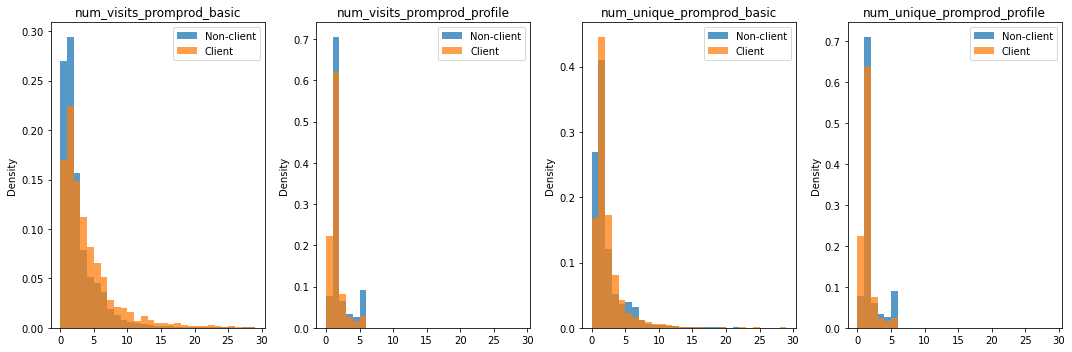

In [265]:
import matplotlib.ticker as mtick

# Select columns to explore
feat_to_explore = ['num_visits_promprod_basic', 'num_visits_promprod_profile','num_unique_promprod_basic','num_unique_promprod_profile']

# Preparing the figure with multiple subplots
fig, axes = plt.subplots(nrows=1, ncols=len(feat_to_explore), figsize=(15, 5))

# Plot histograms by client/non_client for each selected feature
for i, feat in enumerate(feat_to_explore):
    for client in df_board_analysis["is_client"].unique():
        color = 'C1' if client == 1 else 'C0' # set color based on client value
        axes[i].hist(df_board_analysis.loc[df_board_analysis["is_client"]==client, feat], 
                alpha=0.75, 
                label="Client" if client==1 else "Non-client", 
                color=color,
                bins=range(int(df_board_analysis[feat].min()), 30, 1),
                density=True)
        axes[i].set_title(feat)
        axes[i].legend(loc='upper right')
        axes[i].set_ylabel('Density')

        # Format x-axis tick labels
        axes[i].xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: format(int(x), ',')))

# Adjusting the spacing between subplots
fig.tight_layout()


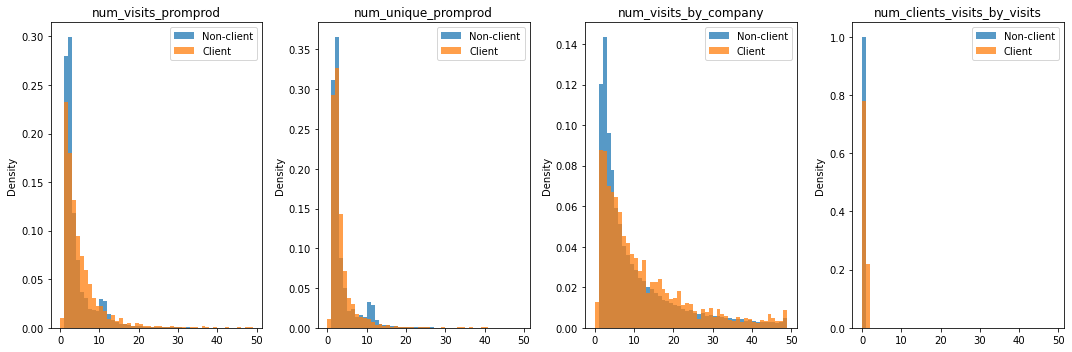

In [9]:
import matplotlib.ticker as mtick

# Select columns to explore
feat_to_explore = ['num_visits_promprod_basic',
                   'num_visits_promprod_profile',
                   'num_unique_promprod_basic',
                   'num_unique_promprod_profile']

# Preparing the figure with multiple subplots
fig, axes = plt.subplots(nrows=1, ncols=len(feat_to_explore), figsize=(15, 5))

# Plot histograms by client_category for each selected feature
for i, feat in enumerate(feat_to_explore):
    for category in ['no_client','client_0', 'client_week', 'client_month','client_other']:
        color = 'C0' if category == 'no_client' else 'C1' # set color based on client_category value
        category_data = df_board_analysis[df_board_analysis['client_category'] == category]
        axes[i].hist(category_data[feat], 
                     alpha=0.75, 
                     label=category, 
                     color=color,
                     bins=range(int(df_board_analysis[feat].min()), 50, 1),
                     density=True)
    axes[i].set_title(feat)
    axes[i].legend(loc='upper right')
    axes[i].set_ylabel('Density')

    # Format x-axis tick labels
    axes[i].xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: format(int(x), ',')))

# Adjusting the spacing between subplots
fig.tight_layout()


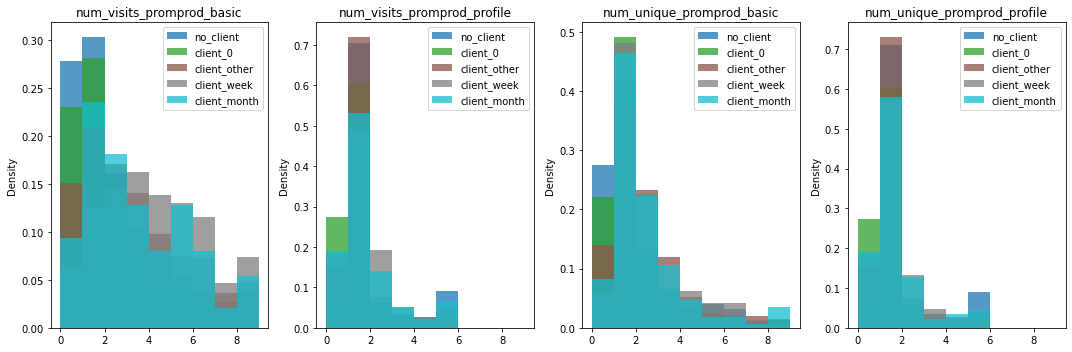

In [268]:
import matplotlib.ticker as mtick
import matplotlib.cm as cm

# Select columns to explore
feat_to_explore = ['num_visits_promprod_basic',
                   'num_visits_promprod_profile',
                   'num_unique_promprod_basic',
                   'num_unique_promprod_profile']

# Preparing the figure with multiple subplots
fig, axes = plt.subplots(nrows=1, ncols=len(feat_to_explore), figsize=(15, 5))

# Define a colormap for client_category
colormap = cm.get_cmap('tab10', len(df_board_analysis['client_category'].unique()))

# Plot histograms by client_category for each selected feature
for i, feat in enumerate(feat_to_explore):
    for j, category in enumerate(df_board_analysis['client_category'].unique()):
        category_data = df_board_analysis[df_board_analysis['client_category'] == category]
        axes[i].hist(category_data[feat], 
                     alpha=0.75, 
                     label=category, 
                     color=colormap(j),
                     bins=range(int(df_board_analysis[feat].min()), 10, 1),
                     density=True)
    axes[i].set_title(feat)
    axes[i].legend(loc='upper right')
    axes[i].set_ylabel('Density')

    # Format x-axis tick labels
    axes[i].xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: format(int(x), ',')))

# Adjusting the spacing between subplots
fig.tight_layout()


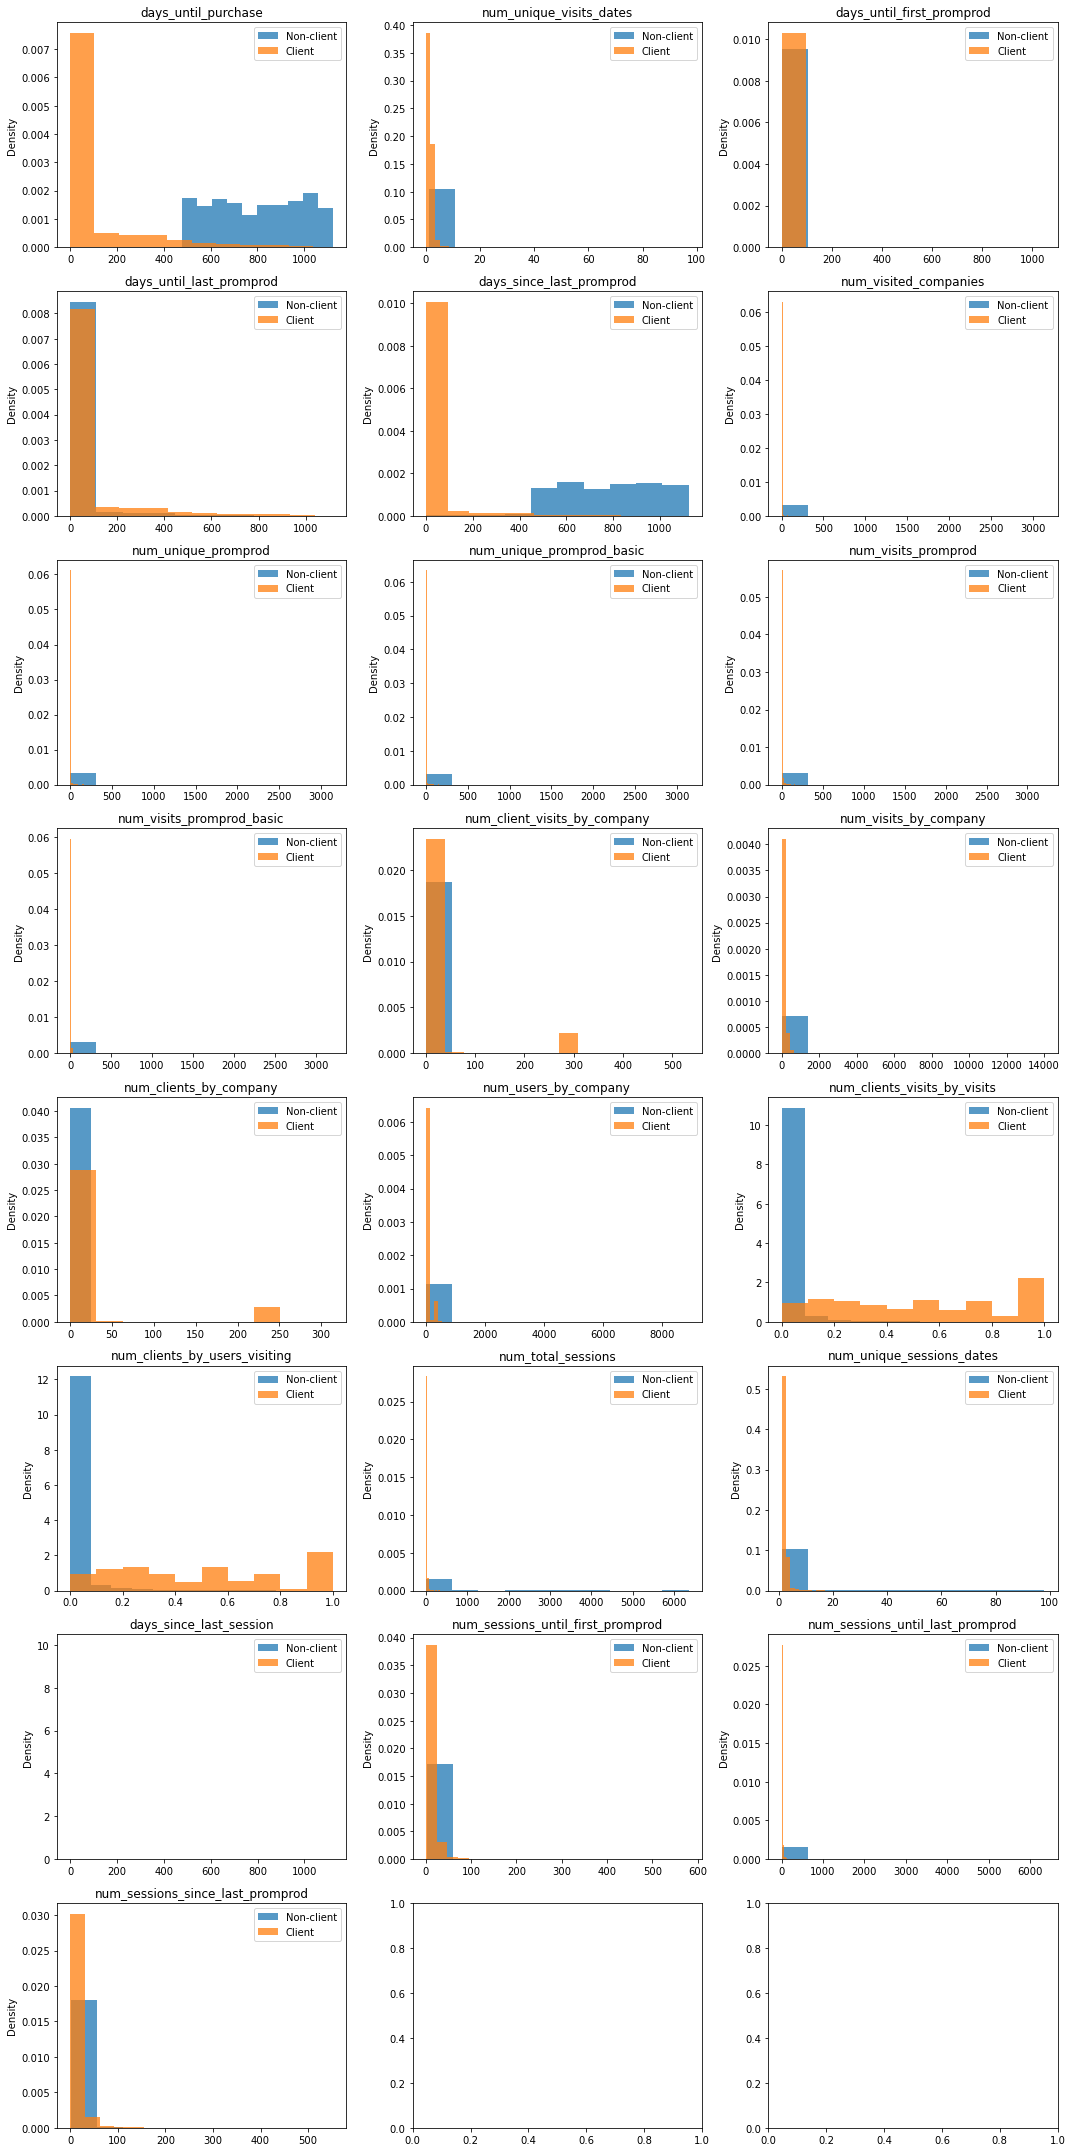

In [261]:
### Plot distribution for numerical variables by client/non_buyer

# Select columns to explore
not_to_explore = ['user_id','is_client','registration_channel','mail_validity',
                  'num_visits_promprod_profile','num_unique_promprod_profile'] # They can only have 5 different values as 
                                                                                #users can only get 5 profiles for free
feats_to_explore = [col for col in df_board_analysis.select_dtypes(include=np.number).columns.tolist() if col not in not_to_explore]

# Preparing the figure with subplots
num_cols = 3
num_rows = math.ceil(len(feats_to_explore)/num_cols)
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15,30))

# Iterate through each subplot and plot the corresponding histogram
for i, featName in enumerate(feats_to_explore):
    row = i // num_cols
    col = i % num_cols
    
    # One histogram by is_client
    for client in df_board_analysis["is_client"].unique():
        color = 'C1' if client == 1 else 'C0' # set color based on client value
        axs[row, col].hist(df_board_analysis.loc[df_board_analysis["is_client"]==client,featName],
                           alpha=0.75,
                           label="Client" if client==1 else "Non-client",
                           color=color,
                           #bins=range(int(df_board_analysis[featName].min()), 50,1),
                           density=True)
        axs[row, col].set_title(featName)
        axs[row, col].legend(loc='upper right')
        axs[row, col].set_ylabel('Density')

# Adjusting the spacing between subplots
fig.tight_layout()

#### <font color='313187'>Distributions for categorical variables<font><a class='anchor' id='DistributionsCategVars'></a> [↑](#top)

In [271]:
# Define a list of categorical features to plot
cat_feats = ['registration_channel', 'mail_validity',
             'user_type',  'user_company_size',
             'user_company_ciiu', 'user_company_status', 'user_company_province',
             'user_company_type',
             'num_visits_promprod_profile', 'num_unique_promprod_profile']
             #'mail_type',

In [272]:
for feat in cat_feats:
    df_board_analysis[feat] = df_board_analysis[feat].astype('category')

C:\Users\Laura\anaconda3\lib\site-packages\pandas\io\formats\format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
C:\Users\Laura\anaconda3\lib\site-packages\pandas\io\formats\format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


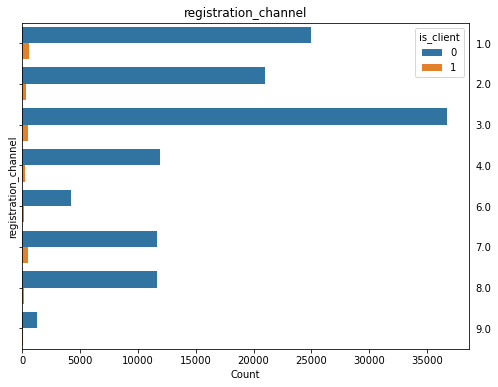

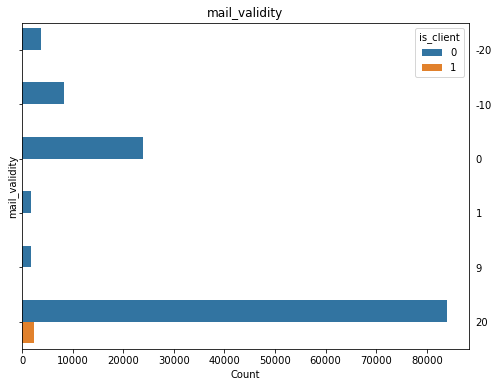

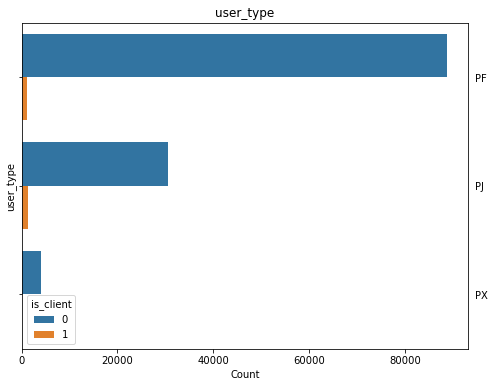

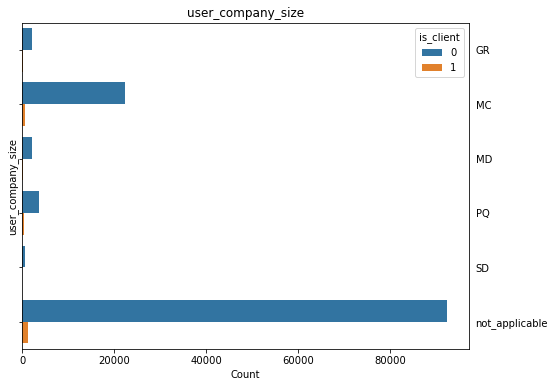

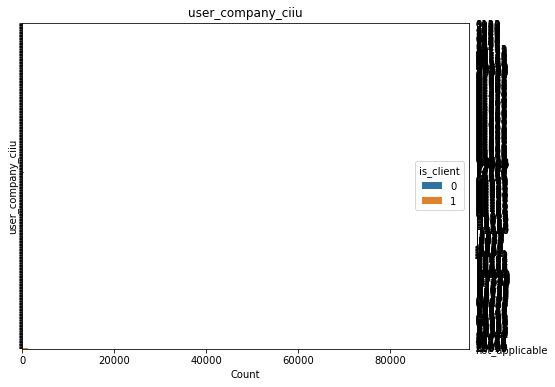

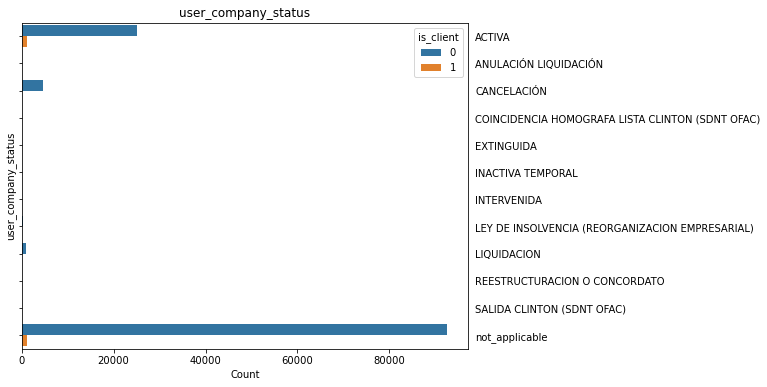

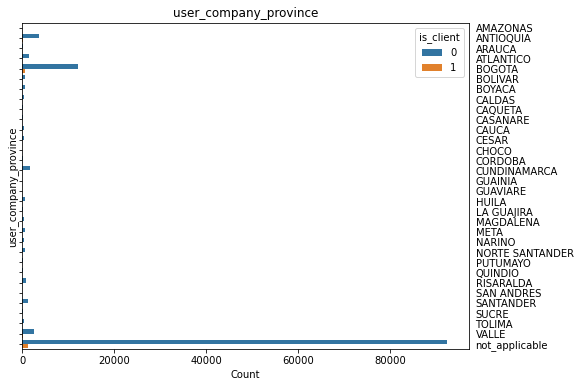

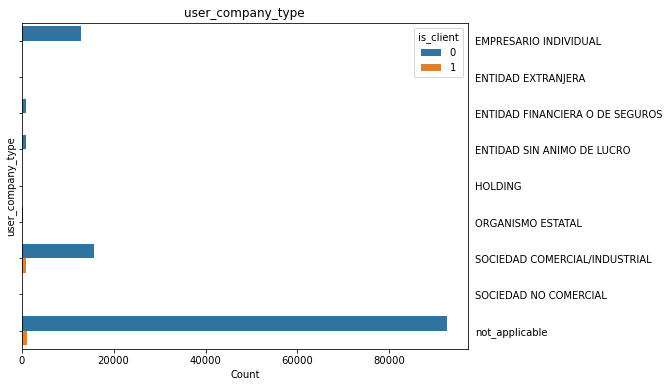

C:\Users\Laura\anaconda3\lib\site-packages\pandas\io\formats\format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
C:\Users\Laura\anaconda3\lib\site-packages\pandas\io\formats\format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


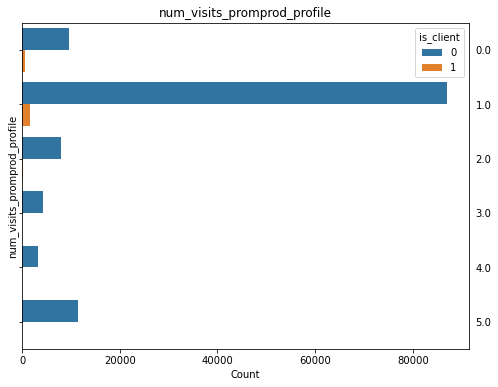

C:\Users\Laura\anaconda3\lib\site-packages\pandas\io\formats\format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


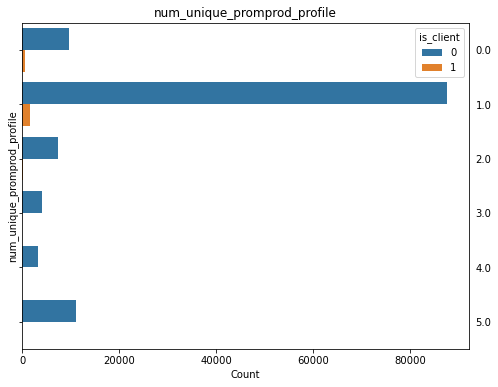

In [273]:
### Get categorical variables distribution

# Loop over the categorical features and create a count plot for each
for feat in cat_feats:
    # Set up the plot
    fig, ax = plt.subplots(figsize=(8, 6))

    # Create the count plot with two colors based on the is_client column
    sns.countplot(y=feat, hue='is_client', data=df_board_analysis, ax=ax)

    # Set the axis labels and title
    ax.set_xlabel('Count')
    ax.set_ylabel(feat)
    ax.set_title(feat)

    # Adjust the position of the y-axis labels
    ax.tick_params(axis='y', labelright=True, labelleft=False)

    # Show the plot
    plt.show()


Percentage of clients inside each class of variable:  registration_channel


C:\Users\Laura\anaconda3\lib\site-packages\pandas\io\formats\format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


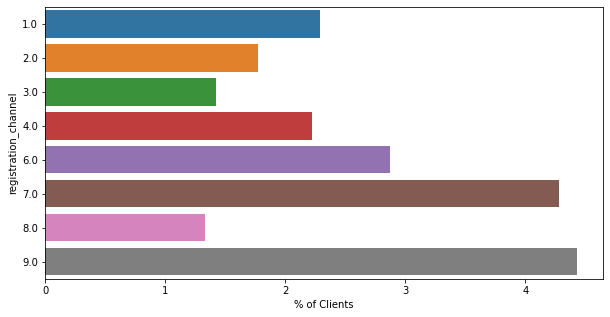

Percentage of clients inside each class of variable:  mail_validity


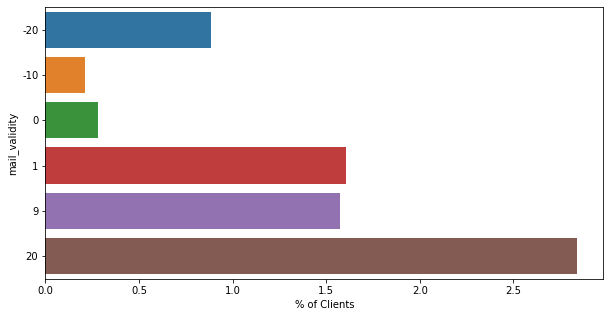

Percentage of clients inside each class of variable:  user_type


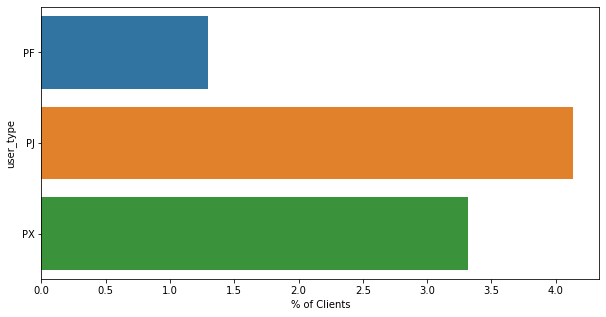

Percentage of clients inside each class of variable:  user_company_size


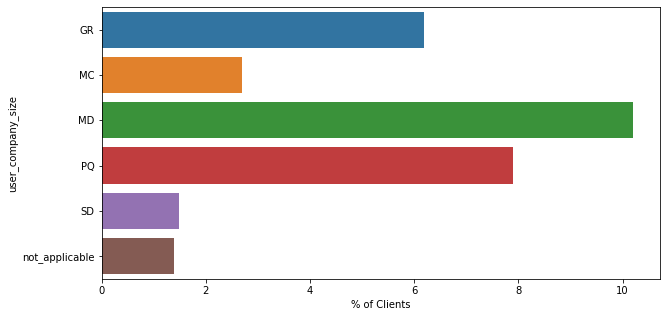

Percentage of clients inside each class of variable:  user_company_ciiu


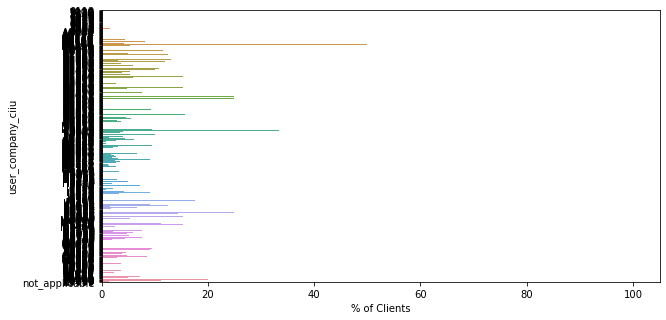

Percentage of clients inside each class of variable:  user_company_status


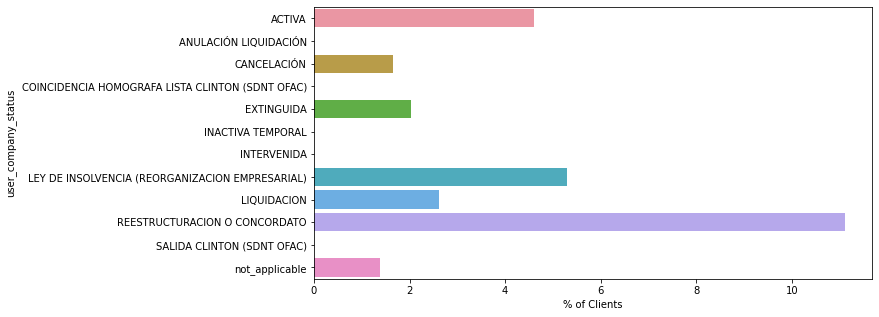

Percentage of clients inside each class of variable:  user_company_province


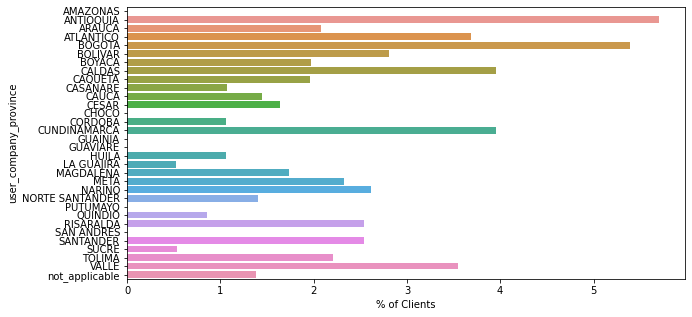

Percentage of clients inside each class of variable:  user_company_type


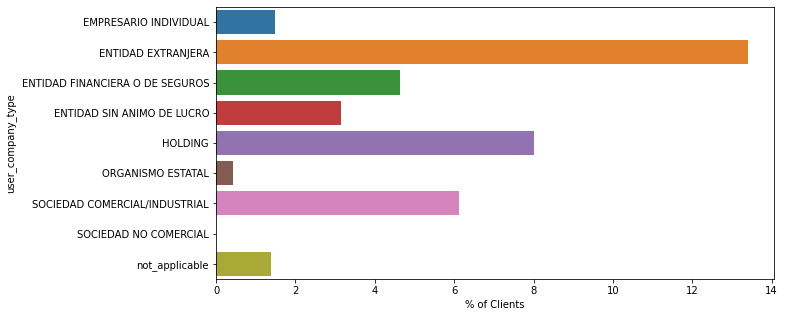

Percentage of clients inside each class of variable:  num_visits_promprod_profile


C:\Users\Laura\anaconda3\lib\site-packages\pandas\io\formats\format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


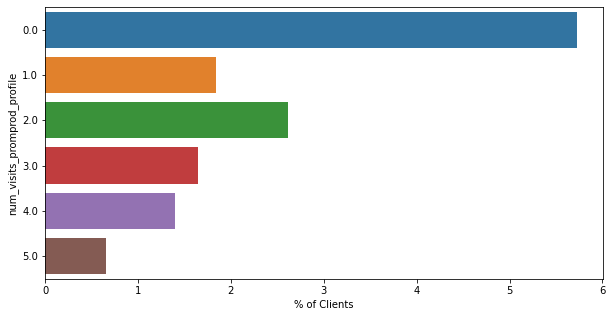

C:\Users\Laura\anaconda3\lib\site-packages\pandas\io\formats\format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


Percentage of clients inside each class of variable:  num_unique_promprod_profile


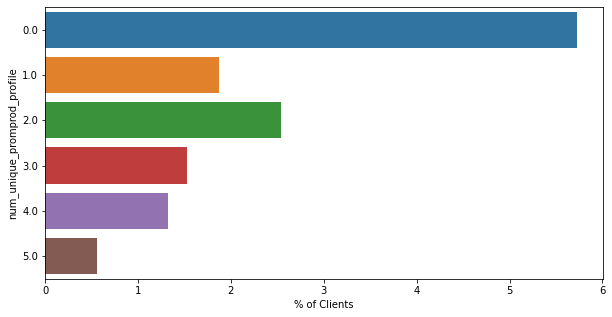

In [21]:
### Get the percentage of clients inside each class for each variable
# Loop over the categorical features and create a count plot for each
for feat in cat_feats:
    # set up the figure
    fig, ax = plt.subplots(figsize=(10, 5))

    # create the plot
    sns.barplot(data=df_board_analysis, x='is_client', y=feat, estimator=lambda x: sum(x) / len(x) * 100, ci=None)

    # set the axis labels and title
    ax.set_xlabel('% of Clients')
    ax.set_ylabel(feat)
    ax.set_title(print('Percentage of clients inside each class of variable: ', feat))

    # show the plot
    plt.show()

### <font color='313187'>Getting boards by client types<font><a class='anchor' id='ClientTypesBoards'></a> [↑](#top)

In [283]:
#We will apply different models for each type of client. 
#client_type = ['no_client','client_0', 'client_week', 'client_month', 'client_other']

#board_client_dict = {}

#for client in client_type:
#        board_client_dict['board_' + client] = df_board_clean[df_board_clean['client_category'].isin(['no_client', client])]


### <font color='313187'>Training, validation and test splits<font><a class='anchor' id='TrainValTest'></a> [↑](#top)

The scaling of variables and handling outliers as well as encoding should be performed only on the training set and then replicate the same methodology in the validation and test sets. This ensures not using any information from the validation or test sets during these preprocessing steps. So before going further, we will proceed to do the set splits.

When dealing with imbalanced data, it is recommended to use a stratified sampling approach for splitting the data into training, validation, and test sets. In stratified sampling, the data is split in such a way that the class distribution is maintained in each subset. This ensures that each subset (training, validation, and test) has a similar class distribution, which can help to reduce bias and improve model performance.

We will adopt an 80-10-10 split for our dataset, allocating 80% of the data to the training set, 10% to the validation set, and the remaining 10% to the test set. This split allows us to train our models on a majority of the data while reserving portions for model evaluation.

Within the training set, we will further apply cross-validation as a good practice. This involves dividing the training set into multiple subsets (folds) and iteratively training the model on different combinations of these folds while evaluating its performance. Cross-validation helps provide a more reliable estimate of the model's performance and prevents overfitting.

Additionally, we will set aside an extra validation set outside of the cross-validation process. This separate validation set will serve as a baseline once we have identified the best model and determined other parameters, such as the appropriate number of folds and handling of class imbalance. We will use this baseline to conduct further tests and explore techniques to enhance its performance.

Once we have finalized the selection of the best model, along with its optimal parameters and hyperparameters, we will evaluate its performance using the dedicated test set. This final evaluation on the test set provides a robust measure of the model's effectiveness and its ability to generalize to unseen data.

In [14]:
# Read board
path = 'C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/MASTER/UOC/16 - Projecte final de master/outputs_dataframe/'
df_board_analysis = pd.read_csv(path + 'df_board_analysis.csv')

In [134]:
# Test results without clients 0
#df_board_clean = df_board_clean[df_board_clean['client_category'].isin(['no_client', "client_week",'client_month'])]

In [135]:
#df_board_clean.client_category.unique()

In [15]:
# Define the target variable
target = 'is_client'

# Split the data into training and test sets (90% for training-validation and 10% for testing)
X_train_val, X_test, y_train_val, y_test = train_test_split(df_board_analysis.drop(target, axis=1), 
                                                            df_board_analysis[target], 
                                                            test_size=0.1, 
                                                            stratify=df_board_analysis[target], 
                                                            random_state=42)

# Split the training and validation sets (80% for training and 10% for validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, 
                                                  y_train_val, 
                                                  test_size=0.111, 
                                                  stratify=y_train_val, 
                                                  random_state=42)


In [16]:
print(df_board_analysis.shape)
print(X_train.shape[0] + X_val.shape[0] + X_test.shape[0])
X_train.shape[0]

(126023, 43)
126023


100830

In [57]:
X_train.head()

,user_id,client_category,is_target,registration_date,client_date,days_until_purchase,registration_channel,mail_type,mail_validity,user_type,user_company_type,user_company_size,user_company_ciiu,user_company_status,user_company_province,first_consume_date,last_consume_date,num_unique_visits_dates,days_until_first_promprod,days_until_last_promprod,days_since_last_promprod,num_visited_companies,num_unique_promprod,num_unique_promprod_basic,num_unique_promprod_profile,num_visits_promprod,num_visits_promprod_basic,num_visits_promprod_profile,num_client_visits_by_company,num_visits_by_company,num_clients_by_company,num_users_by_company,num_clients_visits_by_visits,num_clients_by_users_visiting,first_session_date,last_session_date,num_total_sessions,num_unique_sessions_dates,days_since_last_session,num_sessions_until_first_promprod,num_sessions_until_last_promprod,num_sessions_since_last_promprod
75515,7563112,no_client,False,2019-01-28,2021-01-27,730,8.0,hotmail.com,20,PF,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,2019-01-28 00:00:00,2019-01-28 00:00:00,1.0,0.0,0.0,730.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,28.0,1.0,17.0,0.071429,0.058824,2019-01-28,2019-01-28,6,1,730,6.0,6.0,6.0
46139,7112627,no_client,False,2018-05-08,2021-01-27,995,2.0,gmail.com,20,PF,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,2018-05-08 00:00:00,2018-05-08 00:00:00,1.0,0.0,0.0,995.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,5.0,0.0,4.0,0.000000,0.000000,2018-05-08,2018-05-08,5,1,995,5.0,5.0,5.0
60550,7533565,no_client,False,2019-01-09,2021-01-27,749,6.0,gmail.com,20,PF,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,2019-01-09 00:00:00,2019-01-09 00:00:00,1.0,0.0,0.0,749.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.000000,0.000000,2019-01-09,2019-01-09,5,1,749,5.0,5.0,5.0
82431,7306378,no_client,False,2018-08-13,2021-01-27,898,3.0,hotmail.com,20,PF,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,2018-08-13 00:00:00,2019-06-06 00:00:00,2.0,0.0,297.0,601.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,0.0,3.0,0.0,2.0,0.000000,0.000000,2018-08-13,2019-06-06,7,2,601,6.0,7.0,1.0
79724,8058811,no_client,False,2019-09-30,2021-01-27,485,1.0,gmail.com,20,PF,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,2019-09-30 00:00:00,2019-09-30 00:00:00,1.0,0.0,0.0,485.0,3.0,3.0,2.0,1.0,3.0,2.0,1.0,0.0,19.0,0.0,10.0,0.000000,0.000000,2019-09-30,2019-09-30,7,1,485,7.0,7.0,7.0


In [11]:
y_train.value_counts()

0    98784
1     2046
Name: is_client, dtype: int64

In [32]:
y_val.value_counts()

0    12334
1      256
Name: is_client, dtype: int64

In [33]:
y_test.value_counts()

0    12347
1      256
Name: is_client, dtype: int64

### <font color='313187'>Data preprocessing<font><a class='anchor' id='DataPreprocessing'></a> [↑](#top)

#### <font color='313187'>Dealing with outliers<font><a class='anchor' id='Outliers'></a> [↑](#top)

In [25]:
#num_vars = ('days_until_first_promprod',
#        'days_until_last_promprod',
#        'num_visits_promprod_profile',
#        'num_total_sessions',
#        'num_unique_sessions_dates',
#        'num_sessions_until_first_promprod')

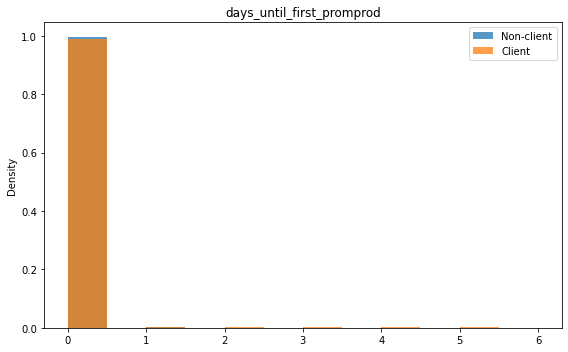

In [17]:
# PLot distribution for numerical variables
#feat_to_explore = 'days_until_first_promprod'
#plot_histogram(df_board_analysis, feat_to_explore, 7)

In [11]:
#df_board_outliers = df_board_analysis.copy()

# Select columns to detect outliers from
#not_in_outliers = ['user_id','is_client','registration_channel','mail_validity',
#                   'num_visits_promprod_profile','num_unique_promprod_profile'] # They can only have 5 different values as 
                                                                                #users can only get 5 profiles for free
#cols_to_impute = [col for col in df_board_outliers.select_dtypes(include=np.number).columns.tolist() if col not in not_in_outliers]

# calculate the upper and lower bounds for each numeric column
#outlier_bounds = {}
#for col in cols_to_impute:
#    q1 = df_board_outliers[col].quantile(0.25)
#    q3 = df_board_outliers[col].quantile(0.75)
#    iqr = q3 - q1
#    outlier_bounds[col] = (q1 - 1.5 * iqr, q3 + 1.5 * iqr)

# add boolean columns for each column to identify outliers
#for col in cols_to_impute:
#    lb, ub = outlier_bounds[col]
#    df_board_outliers[f"{col}_outlier"] = ((df_board_outliers[col] < lb) | (df_board_outliers[col] > ub))
    

### Get number of outliers by column
# create an empty dictionary to store outlier counts by column
#outlier_counts = {}

# loop through columns and count the number of outliers
#for col in cols_to_impute:
#    outlier_counts[col] = df_board_outliers[f"{col}_outlier"].sum()

# print the outlier counts
#print(df_board_outliers.shape[0])
#outlier_counts

In [14]:
# Replace the outliers with the upper or lower bound values
#for col in cols_to_impute:
#    lb, ub = outlier_bounds[col]
#    df_board_outliers[col] = np.where(df_board_outliers[col] < lb, lb, df_board_outliers[col])
#    df_board_outliers[col] = np.where(df_board_outliers[col] > ub, ub, df_board_outliers[col])

In [ ]:
# List of columns to apply logarithmic transformation
#columns = ['column1', 'column2', 'column3']

# Apply logarithmic transformation to the selected columns
#df[columns] = np.log(df[columns])


#### <font color='313187'>Scaling numerical variables<font><a class='anchor' id='Scaling'></a> [↑](#top)

In [77]:
X_train.shape

(100830, 42)

In [57]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# List of columns to standardize
columns = ['days_until_first_promprod',
           'days_until_last_promprod',
           'num_visits_promprod_profile',
           'num_total_sessions',
           'num_unique_sessions_dates',
           'num_sessions_until_first_promprod']

# Create a StandardScaler object
scaler = StandardScaler()

# Fit and transform the selected columns in the training set
scaled_X_train = scaler.fit_transform(X_train[columns])

# Transform the selected columns in the validation and test sets using the fitted scaler
scaled_X_val = scaler.transform(X_val[columns])
scaled_X_test = scaler.transform(X_test[columns])

# Convert the scaled arrays back to DataFrames
scaled_X_train = pd.DataFrame(scaled_X_train, columns=columns, index=X_train.index)
scaled_X_val = pd.DataFrame(scaled_X_val, columns=columns, index=X_val.index)
scaled_X_test = pd.DataFrame(scaled_X_test, columns=columns, index=X_test.index)

# Copy the remaining columns from the original dataframes to the scaled dataframes
X_train_scaled = pd.concat([X_train.reset_index(drop=True).drop(columns=columns), scaled_X_train.reset_index(drop=True)], axis=1)
X_val_scaled = pd.concat([X_val.reset_index(drop=True).drop(columns=columns), scaled_X_val.reset_index(drop=True)], axis=1)
X_test_scaled = pd.concat([X_test.reset_index(drop=True).drop(columns=columns), scaled_X_test.reset_index(drop=True)], axis=1)

print(X_train_scaled.shape)

# Print means before scaling
print('Variables mean values:\n', scaler.mean_)

(100830, 69)
Variables mean values:
 [ 0.63079441 23.396747    1.49355351  9.07895468  1.2658435   7.91956759]


#### <font color='313187'>Checking correlation between categorical variables<font><a class='anchor' id='CorrelationCatVars'></a> [↑](#top)

In [11]:
# Categorical variables
#from scipy.stats import chi2_contingency
#cat_feats = ['registration_channel', 'user_type', 'user_company_type', 'user_company_size', 'mail_validity']

#categorical_vars = X_train[cat_feats].astype(str)
#cols = categorical_vars.columns.values.tolist()

#chi2_results = pd.DataFrame(columns=["Var1", "Var2", "Stat", "p", "dof"])
#for i in range(0, len(cols)):
#    for j in range (i+1, len(cols)):
#         print(i, j)
#        contigency = pd.crosstab(categorical_vars[cols[i]], categorical_vars[cols[j]])
#        stat, p, dof, expected = chi2_contingency(contigency) 
#        chi2_results.loc[len(chi2_results)] = [cols[i], cols[j], stat, round(p, 4), dof]
#print(chi2_results)

                   Var1               Var2           Stat    p dof
0  registration_channel          user_type    4793.341795  0.0  14
1  registration_channel  user_company_type    4538.992761  0.0  56
2  registration_channel  user_company_size    4401.476917  0.0  35
3  registration_channel      mail_validity   24334.050969  0.0  35
4             user_type  user_company_type   99094.321200  0.0  16
5             user_type  user_company_size   99079.842041  0.0  10
6             user_type      mail_validity    3374.591403  0.0  10
7     user_company_type  user_company_size  129661.455365  0.0  40
8     user_company_type      mail_validity    3394.014539  0.0  40
9     user_company_size      mail_validity    3456.937324  0.0  25


#### <font color='313187'>Encoding categorical variables<font><a class='anchor' id='Encoding'></a> [↑](#top)

We will encode all categorical variables candidates to use in the model as non ordinal as we don't have the numbers behind the variable user_company_size or the meaning of the numerical classes of mail_validity.

In [17]:
import category_encoders as ce
import pandas as pd

def encode_categorical_features(X_train, X_val, X_test, cat_feats, encoding='onehot'):
    """
    Encode categorical features using the specified encoding type.

    Parameters:
    - X_train (pd.DataFrame): Training set.
    - X_val (pd.DataFrame): Validation set.
    - X_test (pd.DataFrame): Test set.
    - cat_feats (list): List of categorical feature names.
    - encoding (str, optional): Encoding type. Can be 'binary' or 'onehot'. Defaults to 'onehot'.

    Returns:
    - Encoded training, validation, and test sets.
    """
    if encoding == 'binary':
        # Create the binary encoder
        encoder = ce.BinaryEncoder(cols=cat_feats)
    elif encoding == 'onehot':
        # Create the one-hot encoder with 'return_df=True' and 'use_cat_names=True'
        encoder = ce.OneHotEncoder(cols=cat_feats, return_df=True, use_cat_names=True)
    else:
        raise ValueError("Invalid encoding type. Supported types: 'binary', 'onehot'")

    # Fit the encoder on the training set
    encoder.fit(X_train)

    # Transform the training set
    X_train_encoded = encoder.transform(X_train)

    # Transform the validation set
    X_val_encoded = encoder.transform(X_val)

    # Transform the test set
    X_test_encoded = encoder.transform(X_test)

    return X_train_encoded, X_val_encoded, X_test_encoded


In [18]:
# Define the features to encode
cat_feats = ['registration_channel', 'user_type', 'user_company_type', 'user_company_size', 'mail_validity']

# Choose type of encoding
encoding = 'onehot'  # binary, onehot

# Encode the categorical features
X_train_encoded, X_val_encoded, X_test_encoded = encode_categorical_features(X_train,
                                                                             X_val,
                                                                             X_test,
                                                                             cat_feats,
                                                                             encoding)

# View the encoded datasets
print("Encoded Training Set:")
#print(X_train_encoded.columns)
X_train_encoded.head()

Encoded Training Set:


,user_id,client_category,is_target,registration_date,client_date,days_until_purchase,registration_channel_8.0,registration_channel_2.0,registration_channel_6.0,registration_channel_3.0,...,num_clients_visits_by_visits,num_clients_by_users_visiting,first_session_date,last_session_date,num_total_sessions,num_unique_sessions_dates,days_since_last_session,num_sessions_until_first_promprod,num_sessions_until_last_promprod,num_sessions_since_last_promprod
75515,7563112,no_client,False,2019-01-28,2021-01-27,730,1,0,0,0,...,0.071429,0.058824,2019-01-28,2019-01-28,6,1,730,6.0,6.0,6.0
46139,7112627,no_client,False,2018-05-08,2021-01-27,995,0,1,0,0,...,0.000000,0.000000,2018-05-08,2018-05-08,5,1,995,5.0,5.0,5.0
60550,7533565,no_client,False,2019-01-09,2021-01-27,749,0,0,1,0,...,0.000000,0.000000,2019-01-09,2019-01-09,5,1,749,5.0,5.0,5.0
82431,7306378,no_client,False,2018-08-13,2021-01-27,898,0,0,0,1,...,0.000000,0.000000,2018-08-13,2019-06-06,7,2,601,6.0,7.0,1.0
79724,8058811,no_client,False,2019-09-30,2021-01-27,485,0,0,0,0,...,0.000000,0.000000,2019-09-30,2019-09-30,7,1,485,7.0,7.0,7.0


### <font color='313187'>Saving clean data sets ready to use for modelling<font><a class='anchor' id='SavingCleanDatasetSPlits'></a> [↑](#top) 

In [19]:
# Save datasets to a csv file
to_save = [X_train_encoded, X_val_encoded, X_test_encoded, y_train, y_val, y_test]
file_names = ['X_train_encoded.csv', 'X_val_encoded.csv', 'X_test_encoded.csv', 'y_train.csv', 'y_val.csv', 'y_test.csv']

path = 'C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/MASTER/UOC/16 - Projecte final de master/outputs_dataframe/'

for data, file_name in zip(to_save, file_names):
    file_path = path + file_name
    data.to_csv(file_path, index=False)

print("Datasets saved successfully!")

Datasets saved successfully!


### <font color='313187'>Variable selection<font><a class='anchor' id='VariableSelection'></a> [↑](#top)

In this section we will perform some tests such as multicollinearity and chi-squared to get a preliminary variable selection. We will exclude variables that introduce multicollinearity and check which are the categorical variables more correlated with the target. After this first selection, some tests will be run to check the performance of the models and decide the final variables to use in the final model.

#### <font color='313187'>Preliminary variable selection<font><a class='anchor' id='PreliminaryVars'></a> [↑](#top)

In [20]:
path = 'C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/MASTER/UOC/16 - Projecte final de master/outputs_dataframe/'
encoding = 'onehot'  # binary, onehot

In [21]:
# File paths
file_paths = [
    path + 'X_train_encoded.csv',
    path + 'X_val_encoded.csv',
    path + 'X_test_encoded.csv',
    path + 'y_train.csv',
    path + 'y_val.csv',
    path + 'y_test.csv',
    path + 'df_board_analysis.csv'
]

# Read CSV files into dataframes
dataframes = []
for file_path in file_paths:
    df = pd.read_csv(file_path)
    dataframes.append(df)

# Assign dataframes to variables
X_train = dataframes[0]
X_val = dataframes[1]
X_test = dataframes[2]
y_train = dataframes[3]['is_client'] # [is_client] ->To ensure is a Series intead of a dataframe
y_val = dataframes[4]['is_client']
y_test = dataframes[5]['is_client']
df_board_analysis = dataframes[6]


In [22]:
X_train.head()

,user_id,client_category,is_target,registration_date,client_date,days_until_purchase,registration_channel_8.0,registration_channel_2.0,registration_channel_6.0,registration_channel_3.0,...,num_clients_visits_by_visits,num_clients_by_users_visiting,first_session_date,last_session_date,num_total_sessions,num_unique_sessions_dates,days_since_last_session,num_sessions_until_first_promprod,num_sessions_until_last_promprod,num_sessions_since_last_promprod
0,7563112,no_client,False,2019-01-28,2021-01-27,730,1,0,0,0,...,0.071429,0.058824,2019-01-28,2019-01-28,6,1,730,6.0,6.0,6.0
1,7112627,no_client,False,2018-05-08,2021-01-27,995,0,1,0,0,...,0.000000,0.000000,2018-05-08,2018-05-08,5,1,995,5.0,5.0,5.0
2,7533565,no_client,False,2019-01-09,2021-01-27,749,0,0,1,0,...,0.000000,0.000000,2019-01-09,2019-01-09,5,1,749,5.0,5.0,5.0
3,7306378,no_client,False,2018-08-13,2021-01-27,898,0,0,0,1,...,0.000000,0.000000,2018-08-13,2019-06-06,7,2,601,6.0,7.0,1.0
4,8058811,no_client,False,2019-09-30,2021-01-27,485,0,0,0,0,...,0.000000,0.000000,2019-09-30,2019-09-30,7,1,485,7.0,7.0,7.0


In [23]:
# Select variables to use as predictors

# Define numerical variables
num_variables_to_include = [
        #'num_unique_visits_dates', # correlated with num_unique_sessions_dates
        'days_until_first_promprod',
        'days_until_last_promprod',
        #'num_visited_companies', #correlated with num_unique_promprod_basic and num_total_sessions
        #'num_unique_promprod',
        #'num_unique_promprod_basic', #correlated with num_total_sessions and num_visited_companies
        #'num_unique_promprod_profile', # correlated with num_visits_promprod_profile
        #'num_visits_promprod', #correlated with num_total_sessions and num_visited_companies
        #'num_visits_promprod_basic', #correlated with num_total_sessions and num_visited_companies
        'num_visits_promprod_profile',
        'num_total_sessions',
        'num_unique_sessions_dates',
        'num_sessions_until_first_promprod',
        #'num_sessions_until_last_promprod' # correlated with num_total_sessions
]

# Define categorical variables
if encoding == 'binary':
    
    cat_variables_to_include = [
                            'registration_channel_0', 
                            'registration_channel_1',
                            'registration_channel_2',
                            'registration_channel_3',
                            'mail_validity', 
                            'user_type_0', 
                            'user_type_1',
                            'user_company_type_0',
                            'user_company_type_1',
                            'user_company_type_2', 
                            'user_company_type_3',
                            'user_company_size']

elif encoding =='onehot':
    
    cat_variables_to_include = [
        'registration_channel_1.0',
        'registration_channel_2.0',
        'registration_channel_3.0',
        'registration_channel_4.0',
        'registration_channel_6.0',
        'registration_channel_7.0',
        'registration_channel_8.0',
        'registration_channel_9.0',
        'user_type_PF',
        'user_type_PJ',
        'user_type_PX',
        'user_company_type_EMPRESARIO INDIVIDUAL',
        'user_company_type_ENTIDAD EXTRANJERA',
        'user_company_type_ENTIDAD FINANCIERA O DE SEGUROS',
        'user_company_type_ENTIDAD SIN ANIMO DE LUCRO',
        'user_company_type_HOLDING',
        'user_company_type_ORGANISMO ESTATAL',
        'user_company_type_SOCIEDAD COMERCIAL/INDUSTRIAL',
        'user_company_type_SOCIEDAD NO COMERCIAL',
        'user_company_type_not_applicable',
        'user_company_size_GR',
        'user_company_size_MC',
        'user_company_size_MD',
        'user_company_size_PQ',
        'user_company_size_SD',
        'user_company_size_not_applicable',
        'mail_validity_-20.0',
        'mail_validity_-10.0',
        'mail_validity_0.0',
        'mail_validity_1.0',
        'mail_validity_9.0',
        'mail_validity_20.0']
        

#### <font color='313187'>Check multicollinearity on numerical variables<font><a class='anchor' id='Multicollinearity'></a> [↑](#top)

In [24]:
# Check multicollinearity on numerical variables

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

X = X_train[num_variables_to_include]
calc_vif(X)

,variables,VIF
0,days_until_first_promprod,1.029609
1,days_until_last_promprod,1.237189
2,num_visits_promprod_profile,3.123098
3,num_total_sessions,1.417422
4,num_unique_sessions_dates,2.153304
5,num_sessions_until_first_promprod,2.820120


#### <font color='313187'>Plot selected numerical variables distribution<font><a class='anchor' id='PlotSelectedNumvars'></a> [↑](#top)

After applying the data preprocessing and having selected the numerical variables to include in the model, we will plot their distribution again.

In [25]:
def plot_histogram(df, feature, xaxiscut):
    # Preparing the figure with a single plot
    fig, ax = plt.subplots(figsize=(8, 5))

    # Define the bin edges using linspace
    bin_edges = np.linspace(0, 1, 21)  # 20 evenly spaced bins

    # Plot histogram by client/non_client
    for client in df["is_client"].unique():
        color = 'C1' if client == 1 else 'C0'  # set color based on client value
        ax.hist(df.loc[df["is_client"] == client, feature],
                alpha=0.75,
                label="Client" if client == 1 else "Non-client",
                color=color,
                bins=range(int(df[feature].min()), xaxiscut, 1),
                width=0.5,
                density=True)
        ax.set_title(feature)
        ax.legend(loc='upper right')
        ax.set_ylabel('Density')

        # Format x-axis tick labels
        ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: format(int(x), ',')))

    # Adjusting the spacing between subplots
    fig.tight_layout()

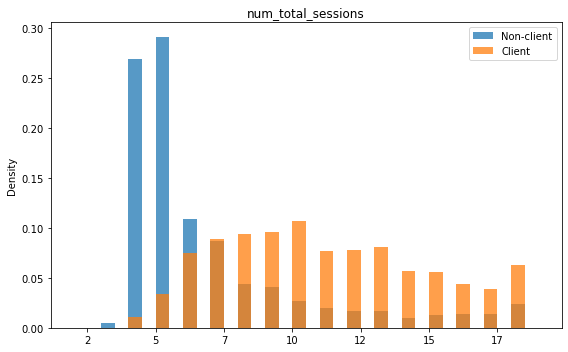

In [498]:
# PLot distribution for numerical variables
feat_to_explore = 'num_total_sessions'
plot_histogram(df_board_analysis, feat_to_explore,20)

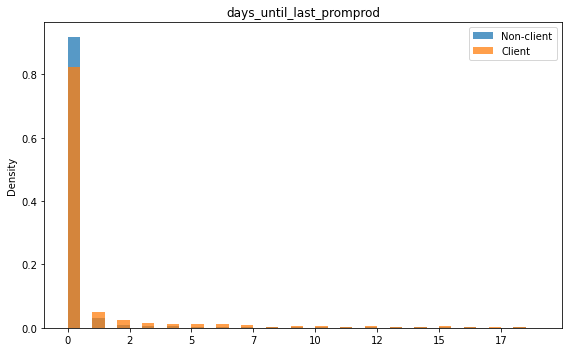

In [157]:
# PLot distribution for numerical variables
feat_to_explore = 'days_until_last_promprod'
plot_histogram(df_board_analysis, feat_to_explore, 20)

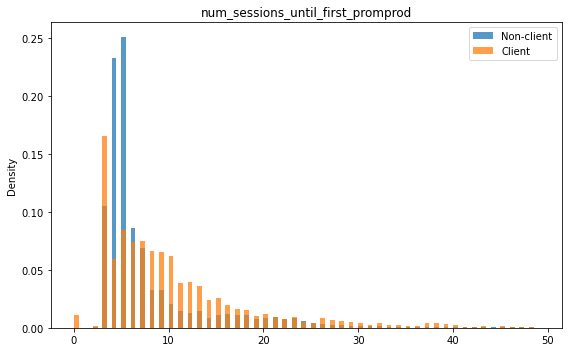

In [21]:
# PLot distribution for numerical variables
feat_to_explore = 'num_sessions_until_first_promprod'
plot_histogram(df_board_analysis, feat_to_explore, 50)

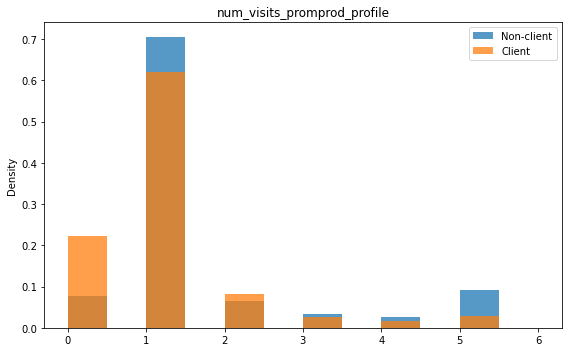

In [23]:
# PLot distribution for numerical variables
df_board_analysis = df_board_analysis.astype({"num_visits_promprod_profile": int, "num_unique_promprod_profile": int})
feat_to_explore = 'num_visits_promprod_profile'
plot_histogram(df_board_analysis, feat_to_explore, 7)

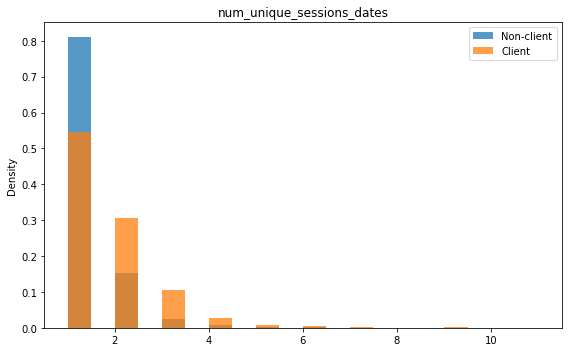

In [500]:
# PLot distribution for numerical variables
feat_to_explore = 'num_unique_sessions_dates'
plot_histogram(df_board_analysis, feat_to_explore,12)

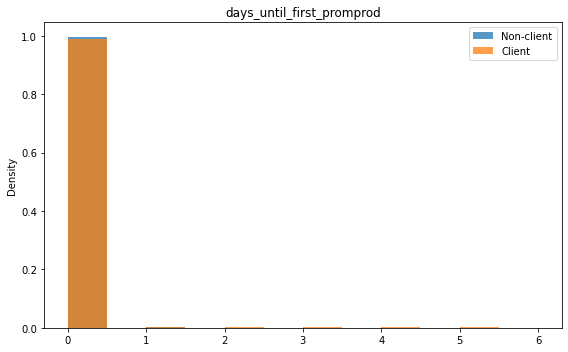

In [18]:
# PLot distribution for numerical variables
feat_to_explore = 'days_until_first_promprod'
plot_histogram(df_board_analysis, feat_to_explore, 7)

#### <font color='313187'>Excluding non informative categorical variables <font><a class='anchor' id=' ExcludingCatVars'></a> [↑](#top)

We will perform a Chi-Square test to see the correlation of the categorical variables with the target and exclude the non informative variables based on this test.

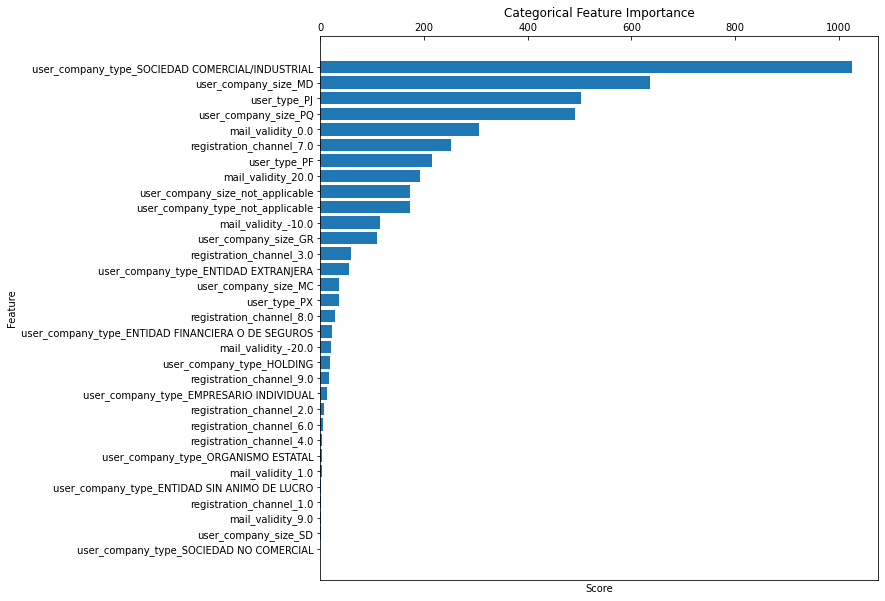

In [26]:
# feature selection
def select_categorical_features(X_train, y_train, feature_names):
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X_train, y_train)
    selected_features = [feature_names[i] for i in fs.get_support(indices=True)]
    return fs, selected_features

# feature selection
fs, selected_features = select_categorical_features(X_train[cat_variables_to_include],
                                                    y_train,
                                                    cat_variables_to_include)

# Create a dataframe with feature names and scores
feature_scores = pd.DataFrame({'Feature': selected_features, 'Score': fs.scores_})

# Sort the feature scores in ascending order
feature_scores = feature_scores.sort_values(by='Score', ascending=True)

# Plot the feature scores
plt.figure(figsize=(10, 10))
plt.barh(feature_scores['Feature'], feature_scores['Score'])
plt.xlabel('Score')
plt.ylabel('Feature')
plt.title('Categorical Feature Importance')

# Move the x-axis ticks and tick labels to the top
plt.tick_params(axis='x', direction='in', which='both', top=True, bottom=False, labelbottom=False, labeltop=True)

plt.show()

We will perform different tests to know which variable selection is better.

In [27]:
# Combine numerical and categorical variables to include in the model
#variables_to_include = feature_scores.sort_values(by='Score', ascending=False)[:12]['Feature'].tolist()
variables_to_include = feature_scores.sort_values(by='Score', ascending=False)['Feature'].tolist()
variables_to_include += num_variables_to_include

if 1 :
    var_imp = path + 'Results_all_variable_importance.csv'
    var_imp = pd.read_csv(var_imp)
    variables_to_include = var_imp[(var_imp['test_name'] == 'LGBM_all_num_all_onehot') &
           (var_imp['undersample_ratio'] == '15:1') &
           (var_imp['fold'] == 'aggregate')].sort_values(by=['importance'], ascending=[False])['feature'][:15].tolist()

print('Predictors:')
print(len(variables_to_include))
variables_to_include

Predictors:
15


['num_total_sessions',
 'days_until_last_promprod',
 'num_sessions_until_first_promprod',
 'num_visits_promprod_profile',
 'num_unique_sessions_dates',
 'registration_channel_1.0',
 'days_until_first_promprod',
 'registration_channel_7.0',
 'user_company_type_SOCIEDAD COMERCIAL/INDUSTRIAL',
 'registration_channel_3.0',
 'user_type_PF',
 'registration_channel_8.0',
 'registration_channel_2.0',
 'mail_validity_20.0',
 'user_company_size_MC']

### <font color='313187'>Handling an imbalanced dataset with cross validation<font><a class='anchor' id='Imbalance'></a> [↑](#top)

As seen in [Eirik_Lodoen_Halsteinslid_thesis] under-sampling seemed to help random forest comparing to other balancing techniques (SMOTE and random over-sampling). Hence we will choose undersampling as a method to handle the imbalanced dataset. 
We will try different ratios on the undersampling technique (e.g., 1:1, 1:5, 1:10, 1:20, original)

When combining re-sampling with cross validation one need to pay attention. One approach is to perform re-sampling on the training set prior to the cross-validation procedure, and then run cross validation as one normally would. This can be harmful to the training process when performing both under-sampling and over-sampling. If we under-sample before applying cross validation, the validation set will be balanced. This can be problematic when the measure of predictive performance used is sensitive to the class balance. If we over-sample, the effects of re-sampling prior to the cross-validation procedure can be even more harmful. First note that we will have the same problem as the one explained above, since the balance of the test set in the cross validation procedure does not resemble that of the final test set. But an even more troubling issue is when we might have the same instance in the training and the validation set at the same time. This introduces bias in the estimation of model
performance, and will lead to over-fitting.

Due to this, we will apply the undersample after the cross-validation ensuring validation and test sets are imbalanced.

In [28]:
def undersample_train_data(ratios, X_train, y_train, print_fold=False):
    # Undersample the training set for each ratio and store the results in a dictionary
    undersampled_train = {}
    for ratio in ratios:
        if print_fold:
            print(f"Undersampling for ratio {ratio}:")
        # Define the undersampler
        undersampling_ratio = min(len(y_train[y_train==1])*ratio, len(y_train[y_train==0]))
        undersampler = RandomUnderSampler(sampling_strategy={0: undersampling_ratio, 1: len(y_train[y_train==1])}, random_state=42)

        # Undersample the training set
        X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train, y_train)

        # Print the class distribution after undersampling
        #print(f'Class distribution after undersampling {ratio}:')
        #print(y_train_undersampled.value_counts(normalize=True))

        # Store the results in a dictionary
        undersampled_train[f'{ratio}:1'] = (X_train_undersampled, y_train_undersampled)

    # Add the original data
    # Print the class distribution after undersampling and store the dataset
    #print(f'Class distribution after undersampling original:')
    #print(y_train.value_counts(normalize=True))
    undersampled_train[f'original'] = (X_train, y_train)
    
    return undersampled_train


In [29]:
def get_kfold_splits(X, y, k, X_val, X_test, y_val, y_test, 
                     undersample=False, 
                     ratios=None, 
                     print_fold=False,
                     check_str_data = False):
    
    # Dictionary to store test, validation and train and cross validation sets for each fold
    fold_data = {}  
    
    # Add validation and test data
    fold_data['X_train'] = X
    fold_data['X_val'] = X_val
    fold_data['X_test'] = X_test
    fold_data['y_train'] = y
    fold_data['y_val'] = y_val
    fold_data['y_test'] = y_test
    
    # Apply stratified k-fold cross validation to the training data
    fold_no = 1
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    for train_index, val_index in kfold.split(X, y):
        if print_fold:
            print(f"Fold  {fold_no}:")
        X_cross_train, X_cross_val = X.iloc[train_index], X.iloc[val_index]
        y_cross_train, y_cross_val = y.iloc[train_index], y.iloc[val_index]

        fold_key = 'fold_' + str(fold_no)
        fold_data[fold_key] = {'X_cross_train': X_cross_train,
                               'X_cross_val': X_cross_val,
                               'y_cross_train': y_cross_train,
                               'y_cross_val': y_cross_val}

        if undersample:
            # Undersample the training set for each fold
            undersampled_train = undersample_train_data(ratios, X_cross_train, y_cross_train, print_fold)
            fold_data[fold_key]['undersampled_train'] = undersampled_train

        fold_no += 1
    
    # Check the structure of fold_data
    if check_str_data:
        check_structure_data(fold_data)
        
    return fold_data

In [30]:
def check_structure_data(fold_data):
    print("X_train shape:", fold_data['X_train'].shape)
    print("X_validation shape:", fold_data['X_val'].shape)
    print("X_test shape:", fold_data['X_test'].shape)
    print("y_train shape:", fold_data['y_train'].shape)
    print("y_validation shape:", fold_data['y_val'].shape)
    print("y_test shape:", fold_data['y_test'].shape)
    print("-------------------")
    for fold_key, fold_values in fold_data.items():
        if fold_key.startswith('fold'):
            print(f"Fold: {fold_key}")
            print("X_cross_train shape:", fold_values['X_cross_train'].shape)
            print("X_cross_val shape:", fold_values['X_cross_val'].shape)
            print("y_cross_train shape:", fold_values['y_cross_train'].shape)
            print("y_cross_val shape:", fold_values['y_cross_val'].shape)

            if 'undersampled_train' in fold_values:
                undersampled_train = fold_values['undersampled_train']
                for ratio_key, ratio_values in undersampled_train.items():
                    print(f"Undersampled Train Data for Ratio: {ratio_key}")
                    X_train_undersampled, y_train_undersampled = ratio_values
                    print("X_train_undersampled shape:", X_train_undersampled.shape)
                    print("y_train_undersampled shape:", y_train_undersampled.shape)
                    print("Class distribution:\n", y_train_undersampled.value_counts(normalize=True))
            print("-------------------")


### <font color='313187'>Model selection and evaluation pipeline<font><a class='anchor' id='Modelling'></a> [↑](#top)

In [31]:
def fit_model(model_name, X_train_modelling, y_train, X_val_modelling, y_val, class_weight, output_dict=False):
    # Initialize the model
    models = get_models(class_weight)
    model = models[model_name]
 
    # Fit the model to the data
    model.fit(X_train_modelling, y_train)
    
    # Get the feature importances
    importances = None
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    
    # Get results
    y_train_pred = model.predict(X_train_modelling)
    y_val_pred = model.predict(X_val_modelling)
    cr_val = classification_report(y_val, y_val_pred, output_dict=output_dict)
    cr_train = classification_report(y_train, y_train_pred, output_dict=output_dict)

    return y_train_pred, y_val_pred, cr_val, cr_train, importances

In [32]:
def evaluate_cross_validation(fold_data, model_name, hyperparameters, class_weight):
    # Define a dictionary to store the results of each run
    results_dict = {}

    for fold_key, fold_data_x in fold_data.items():
        # Select only the folds keys in the dictionary
        if fold_key.startswith('fold'):
            # Get the validation sets for the current fold
            X_val = fold_data_x['X_cross_val']
            y_val = fold_data_x['y_cross_val']

            for name, train_set in fold_data_x['undersampled_train'].items():
                print(f"Classification report for {model_name} for {name} in {fold_key}:")
                y_train_pred, y_val_pred, val_results, train_results, importances = fit_model(
                    model_name,
                    train_set[0],
                    train_set[1],
                    X_val,
                    y_val,
                    class_weight,
                    output_dict=True
                )

                # Add the results in the dictionary
                if fold_key not in results_dict:
                    results_dict[fold_key] = {}

                results_dict[fold_key][name] = {
                    'undersampled_train': train_set,
                    'x_val': X_val,
                    'y_val': y_val,
                    'y_train_pred': y_train_pred,
                    'y_predicted': y_val_pred,
                    'classification_report_train': train_results,
                    'classification_report_val': val_results,
                    'importances': importances
                }
    
    return results_dict



In [33]:
def generate_results_dataframe(test_name,
                               model_name,
                               feature_names,
                               variable_importance_df,
                               results_df, 
                               fold_data,
                               hyperparameters,
                               class_weight):
    
    # Get results on cross validation
    results_dict = evaluate_cross_validation(fold_data = fold_data,
                                             model_name = model_name,
                                             hyperparameters = hyperparameters,
                                             class_weight = class_weight)
    # Initialize actual results list
    new_results_list = []
   
    # Get number of folds in cross validation
    fold_keys = [key for key in results_dict.keys() if key.startswith('fold')]
    num_folds = len(fold_keys)

    
    # Calculate results for each fold and ratio
    for fold_key, fold_results in results_dict.items():
        if fold_key.startswith('fold'):
            for ratio, ratio_results in fold_results.items():
                
                if ratio_results['importances'] is not None:
                    # Prepare variable importance table
                    df_importance_entry = pd.DataFrame({'test_name': test_name,
                                                        'model_name':model_name,
                                                        'num_folds': num_folds,
                                                        'fold': fold_key,
                                                        'undersample_ratio': ratio,
                                                        'feature': feature_names,
                                                        'importance': ratio_results['importances']})
                    variable_importance_df = variable_importance_df.append(df_importance_entry, ignore_index=True)

                for label in range(2):
                    precision_val = ratio_results['classification_report_val'][str(label)]['precision']
                    recall_val = ratio_results['classification_report_val'][str(label)]['recall']
                    f1_score_val = ratio_results['classification_report_val'][str(label)]['f1-score']
                    support_val = ratio_results['classification_report_val'][str(label)]['support']

                    precision_train = ratio_results['classification_report_train'][str(label)]['precision']
                    recall_train = ratio_results['classification_report_train'][str(label)]['recall']
                    f1_score_train = ratio_results['classification_report_train'][str(label)]['f1-score']
                    support_train = ratio_results['classification_report_train'][str(label)]['support']
                    
                    # Prepare results table
                    results_dict_entry = {'test_name': test_name,
                                          'model_name': model_name,
                                          'num_folds': num_folds,
                                          'fold': fold_key,
                                          'undersample_ratio': ratio,
                                          'class': label,
                                          'precision_val': precision_val,
                                          'precision_train': precision_train,
                                          'recall_val': recall_val,
                                          'recall_train': recall_train,
                                          'f1_score_val': f1_score_val,
                                          'f1_score_train': f1_score_train,
                                          'support_val': support_val,
                                          'support_train': support_train}

                    new_results_list.append(results_dict_entry)

    # Create dataframe from the updated list of dictionaries
    new_results_df = pd.DataFrame(new_results_list)
    results_df = results_df.append(new_results_df, ignore_index=True)


    # Round up numerical variables to 4 decimal places
    numeric_cols = results_df.select_dtypes(include=np.number).columns
    results_df[numeric_cols] = results_df[numeric_cols].round(4)
    numeric_cols = variable_importance_df.select_dtypes(include=np.number).columns
    variable_importance_df[numeric_cols] = variable_importance_df[numeric_cols].round(4)


    # Drop duplicates if exist
    results_df.drop_duplicates(inplace=True)
    variable_importance_df.drop_duplicates(inplace=True)
    variable_importance_df.drop_duplicates(inplace=True)
    
    return variable_importance_df, results_df


In [34]:
def calculate_aggregated_results(results_df, variable_importance_df):
    # Calculate mean results scores for each ratio and feature
    results_mean = results_df.groupby(['test_name','model_name', 'num_folds', 'undersample_ratio', 'class'])[['precision_val',
                                                                                        'precision_train',
                                                                                        'recall_val',
                                                                                        'recall_train',
                                                                                        'f1_score_val',
                                                                                        'f1_score_train',
                                                                                        'support_val',
                                                                                        'support_train']].mean()
    results_mean = results_mean.reset_index()
    results_mean['fold'] = 'aggregate'

    # Calculate mean variable importance for each model, ratio and feature
    var_imp_mean = variable_importance_df.groupby(['test_name','model_name', 'num_folds', 'undersample_ratio', 'feature'])['importance'].mean()
    var_imp_mean = var_imp_mean.reset_index()
    var_imp_mean['fold'] = 'aggregate'

    # Round up numerical variables to 4 decimal places
    numeric_cols = results_mean.select_dtypes(include=np.number).columns
    results_mean[numeric_cols] = results_mean[numeric_cols].round(4)
    numeric_cols = var_imp_mean.select_dtypes(include=np.number).columns
    var_imp_mean[numeric_cols] = var_imp_mean[numeric_cols].round(4)

    # Add aggregated results 
    variable_importance_df = variable_importance_df.append(var_imp_mean, ignore_index=True)
    results_df = results_df.append(results_mean, ignore_index=True)

    # Drop duplicates if exist
    results_df.drop_duplicates(inplace=True)
    variable_importance_df.drop_duplicates(inplace=True)
    
    return variable_importance_df, results_df

In [35]:
def save_results_test(test_name, feature_scores, new_variable_importance, new_results, path):
   

    # Sort the feature scores in ascending order
    new_cat_var_importance = feature_scores.sort_values(by='Score', ascending=False)
    new_cat_var_importance['test_name'] = test_name
    
    # Check if the existing result files exist
    cat_var_imp_file = path + 'Results_categorical_variable_importance.csv'
    var_imp_file = path + 'Results_all_variable_importance.csv'
    results_file = path + 'Results_scores.csv'
    
    if os.path.exists(cat_var_imp_file):
        cat_variable_importance_df = pd.read_csv(cat_var_imp_file)
    else:
        cat_variable_importance_df = pd.DataFrame()

    if os.path.exists(var_imp_file):
        variable_importance_df = pd.read_csv(var_imp_file)
    else:
        variable_importance_df = pd.DataFrame()

    if os.path.exists(results_file):
        results_df = pd.read_csv(results_file)
    else:
        results_df = pd.DataFrame()
    
    # Update results with actual test results
    cat_variable_importance_df = cat_variable_importance_df.append(new_cat_var_importance, ignore_index=True)
    variable_importance_df = variable_importance_df.append(new_variable_importance, ignore_index=True)
    results_df = results_df.append(new_results, ignore_index=True)
    
    # Delete duplicates if exist
    cat_variable_importance_df.drop_duplicates(inplace=True)
    variable_importance_df.drop_duplicates(inplace=True)
    results_df.drop_duplicates(inplace=True)
    
    # Save updated tables
    cat_variable_importance_df.to_csv(cat_var_imp_file, index=False)
    variable_importance_df.to_csv(var_imp_file, index=False)
    results_df.to_csv(results_file, index=False)


In [36]:
# Function to load models
def get_models(class_weight, models=dict()):  
    
    if class_weight:
        models['knn'] = KNeighborsClassifier()
        models['gaussian_nb'] = GaussianNB()
        models['lr'] = LogisticRegression(class_weight='balanced', random_state=42)
        models['svc'] = SVC(class_weight='balanced', random_state=42)
        models['rf'] = RandomForestClassifier(class_weight='balanced', random_state=42)
        models['lgbm'] = lgbm.LGBMClassifier(class_weight='balanced', random_state=42)
    else: 
        models['knn'] = KNeighborsClassifier()
        models['gaussian_nb'] = GaussianNB()
        models['lr'] = LogisticRegression(random_state=42)
        models['svc'] = SVC(random_state=42)
        models['rf'] = RandomForestClassifier(random_state=42)
        models['lgbm'] = lgbm.LGBMClassifier(random_state=42)
    return models


C:\Users\Laura\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


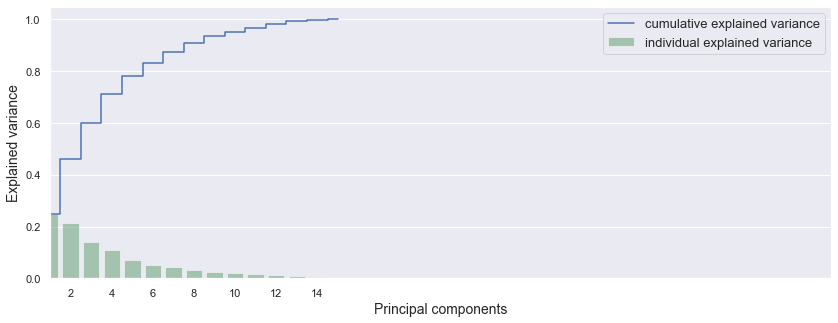

In [58]:
from sklearn.decomposition import PCA
X_train_modelling = X_train_scaled[variables_to_include].copy()
pca = PCA()
pca.fit(X_train_modelling)
pca_samples = pca.transform(X_train_modelling)

# Plot the accumulative explained variance by each principal component
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(X_train_modelling.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,X_train_modelling.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 38)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

In [27]:
# Get the number of components to use for modelling
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
num_components = np.argmax(cumulative_variance >= 0.95) + 1

print("Number of components explaining 95% of variance:", num_components)

Number of components explaining 95% of variance: 10


In [59]:
### Define parameters of the test
# Select the variables to train the model with
X_train_modelling = X_train[variables_to_include].copy()
X_val_modelling = X_val[variables_to_include].copy()
X_test_modelling = X_test[variables_to_include].copy()

use_pca = False
if use_pca:
    # Perform PCA with the desired number of components
    pca = PCA(n_components=num_components)
    pca.fit(X_train[variables_to_include])

    # Transform the original data using the fitted PCA model
    X_train_modelling = pd.DataFrame(pca.transform(X_train[variables_to_include]), columns=[f'PC{i+1}' for i in range(num_components)])
    X_val_modelling = pd.DataFrame(pca.transform(X_val[variables_to_include]), columns=[f'PC{i+1}' for i in range(num_components)])
    X_test_modelling = pd.DataFrame(pca.transform(X_test[variables_to_include]), columns=[f'PC{i+1}' for i in range(num_components)])

# Define ratios to undersample the majority class
ratios = [15]

# Define the number of folds
kfold = 10

# Define if we use class_weight in the models or not
class_weight = False
outliers = 'No treatment'
scaling = 'No treatment' #standardization
variable_selection = 'best_15' #all_num_12bestonehot, all_num_all_onehot, best_10, PCA_14_from_all_num_all_onehot
                                           # PCA_14_from_best_15
decoding = encoding

# Define test name
test_name =  'LGBM_no_scaling_' + variable_selection


# Define models to try
model_names = [
     #'rf',
    'lgbm'
    #'gaussian_nb'
    #'lr',
    #'svc',
    #'knn'
]


# Define hyperparameters for best model
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

In [39]:
# Apply stratified k fold cross validation into the train dataset
fold_data = get_kfold_splits(X = X_train_modelling,
                             y = y_train,
                             k= kfold,
                             X_val = X_val_modelling, 
                             X_test = X_test_modelling, 
                             y_val = y_val, 
                             y_test = y_test,
                             undersample=True,
                             ratios = ratios,
                             print_fold = False,
                             check_str_data = False)

In [41]:
# Save fold_data
path = 'C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/MASTER/UOC/16 - Projecte final de master/outputs_dataframe/'
with open(path + 'fold_data.pickle', 'wb') as file:
    pickle.dump(fold_data, file)

In [42]:
# Get results and variable importance tables:
# Define the vector of model names

# Initialize dataframes
variable_importance_df = pd.DataFrame()
results_df = pd.DataFrame()
cat_variable_importance_df = pd.DataFrame()

# Iterate over each model name
for model_name in model_names:
    # Get results and variable importance tables
    test_name = test_name
    feature_names = list(X_train_modelling.columns)
    variable_importance_df, results_df = generate_results_dataframe(test_name, 
                                                                    model_name,
                                                                    feature_names,
                                                                    variable_importance_df, 
                                                                    results_df,  
                                                                    fold_data.copy(),
                                                                    param_grid,
                                                                    class_weight)
# Calculate aggregated results
variable_importance_df, results_df = calculate_aggregated_results(results_df, variable_importance_df)

# Add test identifier columns
results_df['class_weight'] = class_weight
results_df['outliers'] = outliers
results_df['scaling'] = scaling
results_df['decoding'] = decoding
results_df['variable_selection'] = variable_selection
variable_importance_df['class_weight'] = class_weight
variable_importance_df['outliers'] = outliers
variable_importance_df['scaling'] = scaling
variable_importance_df['decoding'] = decoding
variable_importance_df['variable_selection'] = variable_selection
    
print("Results have finished successfully!")

Classification report for lgbm for 15:1 in fold_1:
Classification report for lgbm for original in fold_1:
Classification report for lgbm for 15:1 in fold_2:
Classification report for lgbm for original in fold_2:
Classification report for lgbm for 15:1 in fold_3:
Classification report for lgbm for original in fold_3:
Classification report for lgbm for 15:1 in fold_4:
Classification report for lgbm for original in fold_4:
Classification report for lgbm for 15:1 in fold_5:
Classification report for lgbm for original in fold_5:
Classification report for lgbm for 15:1 in fold_6:
Classification report for lgbm for original in fold_6:
Classification report for lgbm for 15:1 in fold_7:
Classification report for lgbm for original in fold_7:
Classification report for lgbm for 15:1 in fold_8:
Classification report for lgbm for original in fold_8:
Classification report for lgbm for 15:1 in fold_9:
Classification report for lgbm for original in fold_9:
Classification report for lgbm for 15:1 in fol

In [43]:
### Display the updated results table sorted by best results
results_df[(results_df['fold'] == 'aggregate')].sort_values(by=['class', 'f1_score_val'], ascending=[False, False])

,test_name,model_name,num_folds,fold,undersample_ratio,class,precision_val,precision_train,recall_val,recall_train,f1_score_val,f1_score_train,support_val,support_train,class_weight,outliers,scaling,decoding,variable_selection
41,LGBM_no_scaling_best_15,lgbm,10,aggregate,15:1,1,0.4193,0.8350,0.4546,0.5653,0.4361,0.6741,204.6,1841.4,False,No treatment,No treatment,onehot,best_15
43,LGBM_no_scaling_best_15,lgbm,10,aggregate,original,1,0.6085,0.8156,0.2273,0.3274,0.3307,0.4672,204.6,1841.4,False,No treatment,No treatment,onehot,best_15
42,LGBM_no_scaling_best_15,lgbm,10,aggregate,original,0,0.9842,0.9862,0.9970,0.9985,0.9906,0.9923,9878.4,88905.6,False,No treatment,No treatment,onehot,best_15
40,LGBM_no_scaling_best_15,lgbm,10,aggregate,15:1,0,0.9887,0.9716,0.9869,0.9926,0.9878,0.9820,9878.4,27621.0,False,No treatment,No treatment,onehot,best_15


['lgbm']


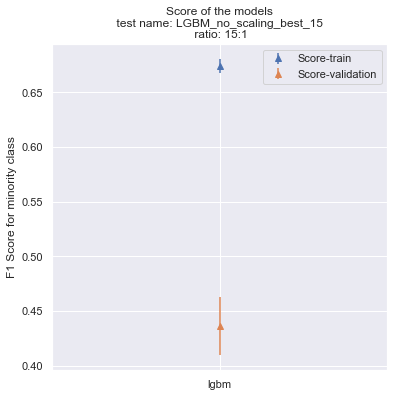

In [44]:
subset = results_df[(results_df['fold'] == 'aggregate') & (results_df['class'] == 1)]
best_score_ratio = subset.loc[subset['f1_score_val'].idxmax(), 'undersample_ratio']

# Filter the DataFrame based on the desired conditions
filtered_df = results_df[(results_df['test_name'] == test_name) &
                         (results_df['fold'] != 'aggregate') &
                         (results_df['undersample_ratio'] == best_score_ratio) &
                         (results_df['class'] == 1)]

# Get unique model names
model_names = filtered_df['model_name'].unique()
print(model_names)

x = np.arange(len(model_names))

fig = plt.figure(figsize=(6, 6))

# Calculate mean and standard deviation for f1_score_train
mean_train = [filtered_df[filtered_df['model_name'] == model]['f1_score_train'].mean() for model in model_names]
std_train = [filtered_df[filtered_df['model_name'] == model]['f1_score_train'].std() for model in model_names]
plt.errorbar(x, mean_train, std_train,
             label='Score-train',
             linestyle='None',
             marker='^')

# Calculate mean and standard deviation for f1_score_val
mean_val = [filtered_df[filtered_df['model_name'] == model]['f1_score_val'].mean() for model in model_names]
std_val = [filtered_df[filtered_df['model_name'] == model]['f1_score_val'].std() for model in model_names]
plt.errorbar(x, mean_val, std_val,
             label='Score-validation',
             linestyle='None',
             marker='^')

plt.ylabel('F1 Score for minority class')
plt.title('Score of the models' + '\n test name: ' + test_name + ' \n ratio: ' + best_score_ratio)
plt.xticks(x, model_names)
plt.legend()
plt.show()


In [177]:
# Display results to check each fold and aggregated scores 
#results_df.sort_values(by=['model_name','undersample_ratio','class'], ascending=[False,False, False])

In [45]:
### Display the updated variable importance table sorted by most important variables

variable_importance_df[(variable_importance_df['undersample_ratio']== best_score_ratio) &
                       (variable_importance_df['test_name']==test_name) 
                       & (variable_importance_df['fold']=='aggregate')
                      ].sort_values(by=['test_name','undersample_ratio','importance'], 
                                   ascending=[False, False, False])

,test_name,model_name,num_folds,fold,undersample_ratio,feature,importance,class_weight,outliers,scaling,decoding,variable_selection
304,LGBM_no_scaling_best_15,lgbm,10,aggregate,15:1,num_total_sessions,696.9,False,No treatment,No treatment,onehot,best_15
301,LGBM_no_scaling_best_15,lgbm,10,aggregate,15:1,days_until_last_promprod,568.1,False,No treatment,No treatment,onehot,best_15
303,LGBM_no_scaling_best_15,lgbm,10,aggregate,15:1,num_sessions_until_first_promprod,483.4,False,No treatment,No treatment,onehot,best_15
306,LGBM_no_scaling_best_15,lgbm,10,aggregate,15:1,num_visits_promprod_profile,311.7,False,No treatment,No treatment,onehot,best_15
305,LGBM_no_scaling_best_15,lgbm,10,aggregate,15:1,num_unique_sessions_dates,183.5,False,No treatment,No treatment,onehot,best_15
313,LGBM_no_scaling_best_15,lgbm,10,aggregate,15:1,user_company_type_SOCIEDAD COMERCIAL/INDUSTRIAL,96.4,False,No treatment,No treatment,onehot,best_15
310,LGBM_no_scaling_best_15,lgbm,10,aggregate,15:1,registration_channel_7.0,88.9,False,No treatment,No treatment,onehot,best_15
300,LGBM_no_scaling_best_15,lgbm,10,aggregate,15:1,days_until_first_promprod,87.3,False,No treatment,No treatment,onehot,best_15
314,LGBM_no_scaling_best_15,lgbm,10,aggregate,15:1,user_type_PF,84.7,False,No treatment,No treatment,onehot,best_15
307,LGBM_no_scaling_best_15,lgbm,10,aggregate,15:1,registration_channel_1.0,81.5,False,No treatment,No treatment,onehot,best_15


In [55]:
# Create a dataframe with feature names and scores
#feature_scores = pd.DataFrame({'Feature': selected_features, 'Score': fs.scores_})

path = 'C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/MASTER/UOC/16 - Projecte final de master/outputs_dataframe/'
results_file = path + 'Results_all_variable_importance.csv'
variable_importance_df = pd.read_csv(results_file)

feature_scores = variable_importance_df[(variable_importance_df['undersample_ratio']== '15:1') 
                                        &(variable_importance_df['test_name']=='LGBM_no_scaling_best_15')
                                        & (variable_importance_df['fold']=='aggregate')]
#feature_scores = feature_scores[['feature', 'importance']]

# Sort the feature scores in ascending order
feature_scores = feature_scores.sort_values(by='importance', ascending=True)
feature_scores

,test_name,model_name,num_folds,fold,undersample_ratio,feature,importance,class_weight,scaling,outliers,variable_selection,decoding
34063,LGBM_no_scaling_best_15,lgbm,10,aggregate,15:1,registration_channel_8.0,47.4,False,No treatment,No treatment,best_15,onehot
34060,LGBM_no_scaling_best_15,lgbm,10,aggregate,15:1,registration_channel_2.0,54.4,False,No treatment,No treatment,best_15,onehot
34054,LGBM_no_scaling_best_15,lgbm,10,aggregate,15:1,mail_validity_20.0,64.3,False,No treatment,No treatment,best_15,onehot
34064,LGBM_no_scaling_best_15,lgbm,10,aggregate,15:1,user_company_size_MC,72.6,False,No treatment,No treatment,best_15,onehot
34061,LGBM_no_scaling_best_15,lgbm,10,aggregate,15:1,registration_channel_3.0,78.9,False,No treatment,No treatment,best_15,onehot
34059,LGBM_no_scaling_best_15,lgbm,10,aggregate,15:1,registration_channel_1.0,81.5,False,No treatment,No treatment,best_15,onehot
34066,LGBM_no_scaling_best_15,lgbm,10,aggregate,15:1,user_type_PF,84.7,False,No treatment,No treatment,best_15,onehot
34052,LGBM_no_scaling_best_15,lgbm,10,aggregate,15:1,days_until_first_promprod,87.3,False,No treatment,No treatment,best_15,onehot
34062,LGBM_no_scaling_best_15,lgbm,10,aggregate,15:1,registration_channel_7.0,88.9,False,No treatment,No treatment,best_15,onehot
34065,LGBM_no_scaling_best_15,lgbm,10,aggregate,15:1,user_company_type_SOCIEDAD COMERCIAL/INDUSTRIAL,96.4,False,No treatment,No treatment,best_15,onehot


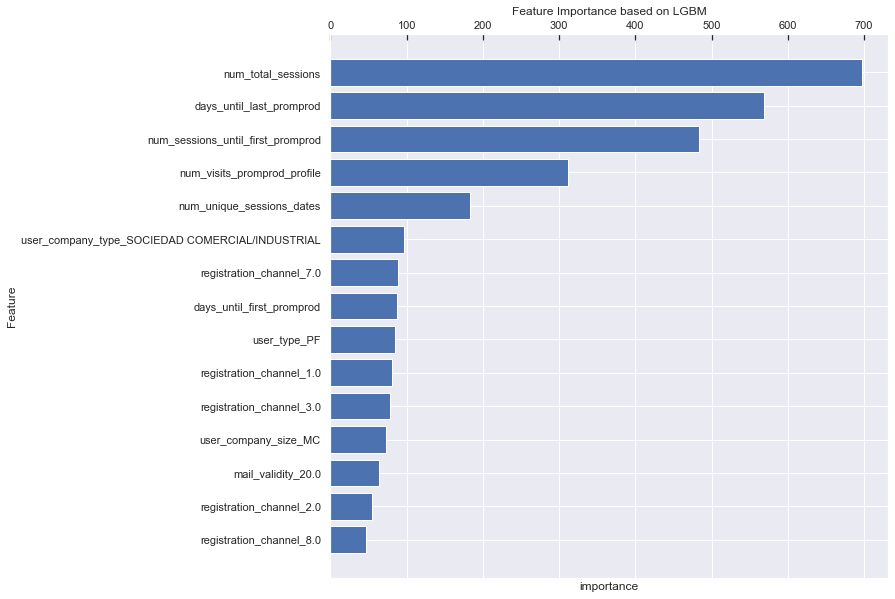

In [56]:

# Plot the feature scores
plt.figure(figsize=(10, 10))
plt.barh(feature_scores['feature'], feature_scores['importance'])
plt.xlabel('importance')
plt.ylabel('Feature')
plt.title('Feature Importance based on LGBM')

# Move the x-axis ticks and tick labels to the top
plt.tick_params(axis='x', direction='in', which='both', top=True, bottom=False, labelbottom=False, labeltop=True)

plt.show()

In [46]:
# Save results of this test
path = 'C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/MASTER/UOC/16 - Projecte final de master/outputs_dataframe/'
save_results_test(test_name = test_name,
                  feature_scores = feature_scores,
                  new_variable_importance = variable_importance_df,
                  new_results = results_df,
                  path = path)

### <font color='313187'>Tests<font><a class='anchor' id='Tests'></a> [↑](#top)

In [28]:
def plot_results_by_column(data, x_column, y_column):
    # Define colors based on the 'model_name' column
    model_colors = {
        #'knn': 'red', 
        'gaussian_nb': 'blue',
        #'lr': 'green',
        #'svc': 'orange',
        'rf': 'purple',
        'lgbm': 'cyan'}
    
    plt.figure(figsize=(10, 6)) 
    plt.scatter(data[x_column], data[y_column], c=[model_colors[model] for model in data['model_name']])
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.title(f'{y_column} vs {x_column}')

    # Set x-ticks to unique values from the specified column
    x_ticks = sorted(data[x_column].unique())
    plt.xticks(x_ticks)

    # Create a legend for the model colors
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=model, markerfacecolor=color, markersize=8) for model, color in model_colors.items()]
    plt.legend(handles=legend_elements)

    # Rotate x-axis tick labels by 45 degrees
    plt.xticks(rotation=70)
    
    plt.show()


In [29]:
def plot_results_by_column_model(data, x_column, y_column):
    # Define colors based on the 'model_name' column
    model_colors = {
        #'knn': 'red', 
        'gaussian_nb': 'blue',
        #'lr': 'green',
        #'svc': 'orange',
        'rf': 'purple',
        'lgbm': 'cyan'}
    
     # Add a new column for the concatenation of model_name and x_column
    #data['x_model'] = data['model_name'] + ' ' + data[x_column].astype(str)
    data.loc[:, 'x_model'] = data['model_name'] + ' ' + data[x_column].astype(str)

    
    plt.figure(figsize=(20, 6))
    plt.scatter(data['x_model'], data[y_column], c=[model_colors[model] for model in data['model_name']])
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.title(f'{y_column} vs {x_column}')

    # Set x-ticks to unique values from the specified column
    x_ticks = sorted(data['x_model'].unique())
    plt.xticks(x_ticks)

    # Create a legend for the model colors
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=model, markerfacecolor=color, markersize=8) for model, color in model_colors.items()]
    plt.legend(handles=legend_elements)


    plt.show()  

In [5]:
def highlight_statistics(statistics):
    # Highlight the maximum values in green for 'mean', 'median', 'min', and 'max' columns
    styled_table = statistics.style.highlight_max(color='green', subset=['mean', 'median', 'min', 'max'])

    # Highlight the minimum value in green for 'std' column
    styled_table = styled_table.highlight_min(color='green', subset=['std'])

    return styled_table

In [7]:
### Display the updated results table sorted by best results
path = 'C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/MASTER/UOC/16 - Projecte final de master/outputs_dataframe/'
results_file = path + 'Results_scores.csv'
all_results_df = pd.read_csv(results_file)
columns = ['test_name', 'precision_val','precision_train', 'recall_val', 'recall_train','f1_score_val', 'f1_score_train']
filtered_results = all_results_df[(all_results_df['fold'] == 'aggregate') &
               (all_results_df['test_name'].str.startswith('LGBM')) &
               (all_results_df['undersample_ratio'] == '15:1') &
              (all_results_df['class'] == 1)].sort_values(by=['class', 'f1_score_val'], ascending=[False, False])
filtered_results[columns]

,test_name,precision_val,precision_train,recall_val,recall_train,f1_score_val,f1_score_train
2865,LGBM_best_15,0.4255,0.8325,0.4541,0.5663,0.4391,0.6740
3041,LGBM_no_scaling_best_15,0.4193,0.8350,0.4546,0.5653,0.4361,0.6741
2645,LGBM_all_num_all_onehot,0.4143,0.8338,0.4556,0.5752,0.4337,0.6808
2909,LGBM_best_20,0.4122,0.8307,0.4550,0.5690,0.4324,0.6754
2997,LGBM_best_14,0.4122,0.8283,0.4536,0.5578,0.4316,0.6666
2953,LGBM_best_13,0.4124,0.8241,0.4482,0.5477,0.4294,0.6581
2733,LGBM_best_10,0.4138,0.8241,0.4404,0.5389,0.4264,0.6516
2689,LGBM_all_num_12bestonehot,0.3996,0.8170,0.4511,0.5569,0.4235,0.6623
2777,LGBM_PCA_14_from_all_num_all_onehot,0.3650,0.8853,0.3251,0.5225,0.3435,0.6571
2821,LGBM_PCA_10_from_best_15,0.3468,0.8746,0.3250,0.5266,0.3346,0.6573


#### <font color='313187'>Number of K-folds<font><a class='anchor' id='NumKFolds'></a> [↑](#top)

Checking the following results, it seems like the number of folds doesn't have a huge impact. We will keep k = 10.

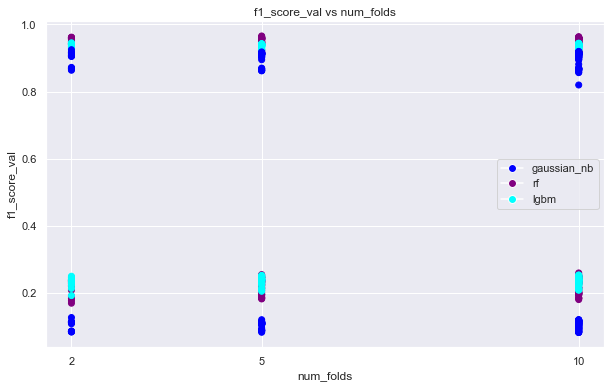

In [103]:
to_plot = all_results_df[(all_results_df['test_name'].isin(['kfold_2_onehot12_no_colinearity',
                                                            'kfold_5_onehot12_no_colinearity',
                                                            'kfold_10_onehot12_no_colinearity'])) &
                        
                        (all_results_df['fold'] != 'aggregate')]

# Plot results bu number of folds
by_var = 'num_folds'
plot_results_by_column(to_plot, by_var , 'f1_score_val')

In [104]:
# Calculate the statistics
statistics = to_plot[to_plot['class'] == 1].groupby([by_var])['f1_score_val'].agg(['mean','median', 'std', 'min', 'max', 'count'])

# Apply conditional formatting to highlight the largest values in each column
# And display the styled table
highlight_statistics(statistics)

,mean,median,std,min,max,count
num_folds,,,,,,
2,0.182529,0.216100,0.061644,0.083100,0.249200,42
5,0.187507,0.222000,0.061417,0.082100,0.254100,105
10,0.187587,0.222100,0.061768,0.081500,0.259000,210


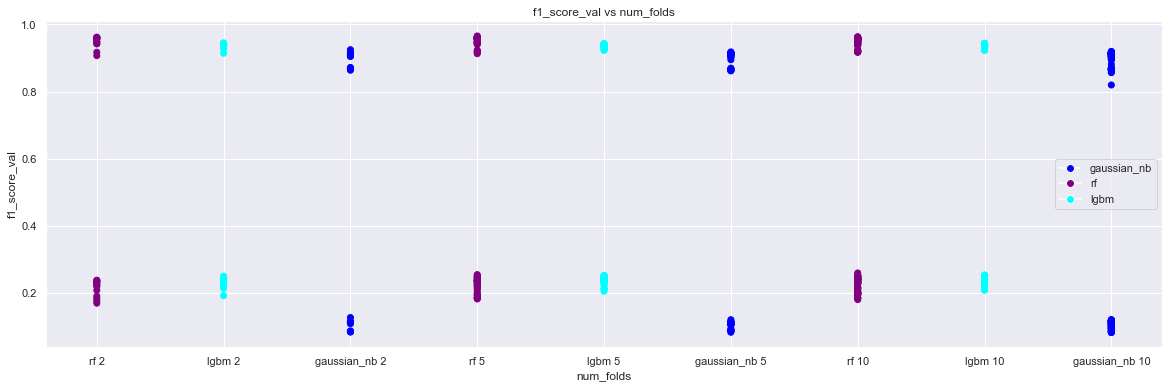

In [106]:
# Plot results by number of folds
plot_results_by_column_model(to_plot, by_var, 'f1_score_val')

In [107]:
# Calculate the statistics
statistics = to_plot[to_plot['class'] == 1].groupby([by_var, 'model_name'])['f1_score_val'].agg(['mean', 'median', 'std', 'min', 'max', 'count'])

# Apply conditional formatting to highlight the largest values in each column
# And display the styled table
highlight_statistics(statistics)


#### <font color='313187'>Class imbalance approach<font><a class='anchor' id='ImbalancedApproach'></a> [↑](#top)

Between using weights in the models to deal with the unbalance problem and undersampling, we can see the undersamlping works better.  

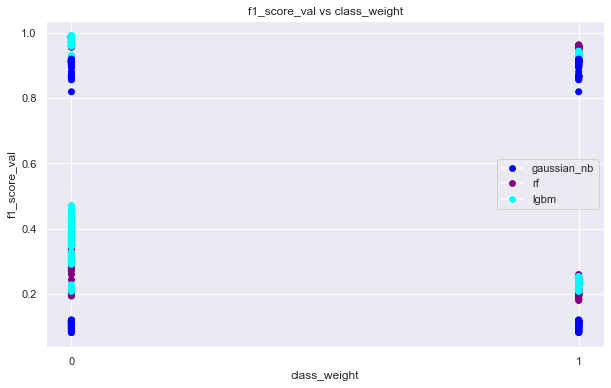

In [108]:
to_plot = all_results_df[(all_results_df['test_name'].isin(['kfold_10_onehot12_no_colinearity',
                                                           'no_class_weight_kfold_10_onehot12_no_colinearity'])) &
                        
                        (all_results_df['fold'] != 'aggregate')]
# Plot results classs weight vs undersampling
by_var = 'class_weight'
plot_results_by_column(to_plot,by_var , 'f1_score_val')

In [109]:
# Calculate the statistics
statistics = to_plot[to_plot['class'] == 1].groupby([by_var])['f1_score_val'].agg(['mean','median', 'std', 'min', 'max', 'count'])

# Apply conditional formatting to highlight the largest values in each column
# And display the styled table
highlight_statistics(statistics)

,mean,median,std,min,max,count
class_weight,,,,,,
False,0.259149,0.294300,0.126067,0.081500,0.470000,210
True,0.187587,0.222100,0.061768,0.081500,0.259000,210


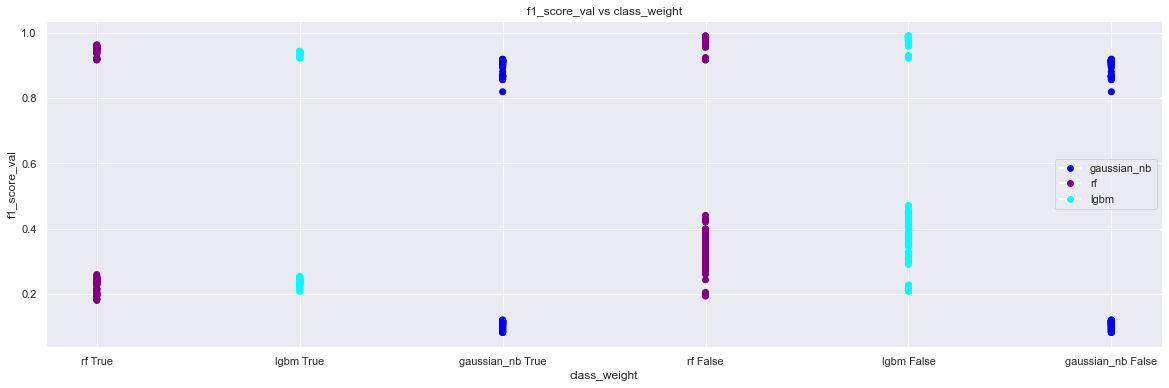

In [110]:
# Plot results classs weight vs undersampling
plot_results_by_column_model(to_plot, by_var, 'f1_score_val')

In [111]:
# Calculate the statistics
statistics = to_plot[to_plot['class'] == 1].groupby([by_var, 'model_name'])['f1_score_val'].agg(['mean', 'median', 'std', 'min', 'max', 'count'])

# Apply conditional formatting to highlight the largest values in each column
# And display the styled table
highlight_statistics(statistics)


#### <font color='313187'>Undersample ratio<font><a class='anchor' id='UndersampleRatio'></a> [↑](#top)

By now seems like the ratios 10, 15 and 20 are the ones that works better. As the model that performs better is lgbm and it also overfitts less, we will keep the 15:1 ratio as is the one that works better for it.

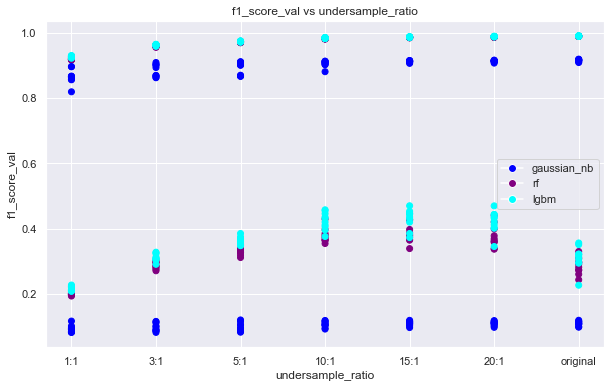

In [112]:
to_plot = all_results_df[(all_results_df['test_name'].isin(['no_class_weight_kfold_10_onehot12_no_colinearity'])) &
                        
                        (all_results_df['fold'] != 'aggregate')]

# Plot results by undersample ratio
by_var = 'undersample_ratio'
plot_results_by_column(to_plot, by_var, 'f1_score_val')

In [113]:
# Calculate the statistics
statistics = to_plot[to_plot['class'] == 1].groupby([by_var])['f1_score_val'].agg(['mean','median', 'std', 'min', 'max', 'count'])

# Apply conditional formatting to highlight the largest values in each column
# And display the styled table
highlight_statistics(statistics)

,mean,median,std,min,max,count
undersample_ratio,,,,,,
10:1,0.302843,0.373700,0.143757,0.091800,0.457600,30
15:1,0.307920,0.376250,0.145935,0.096400,0.470000,30
1:1,0.168887,0.197500,0.056222,0.081500,0.226900,30
20:1,0.301977,0.361600,0.142526,0.097100,0.469700,30
3:1,0.231987,0.285700,0.097866,0.081600,0.327600,30
5:1,0.265437,0.330900,0.120102,0.082200,0.385000,30
original,0.234990,0.277100,0.094495,0.097700,0.355900,30


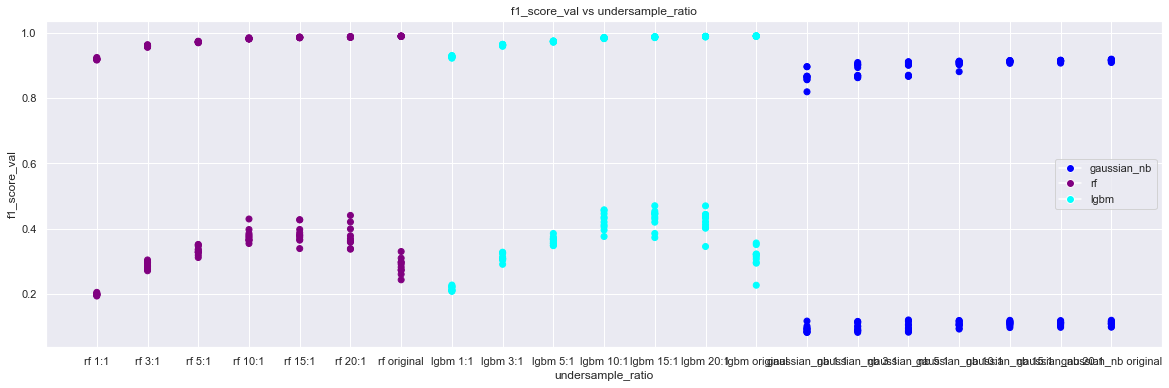

In [114]:
# Plot results by undersample ratio
plot_results_by_column_model(to_plot, by_var, 'f1_score_val')

In [115]:
# Calculate the statistics
statistics = to_plot[to_plot['class'] == 1].groupby([by_var, 'model_name'])['f1_score_val'].agg(['mean', 'median', 'std', 'min', 'max', 'count'])

# Apply conditional formatting to highlight the largest values in each column
# And display the styled table
highlight_statistics(statistics)


#### <font color='313187'>Encoding method<font><a class='anchor' id='EncodingMethod'></a> [↑](#top)

TODO

#### <font color='313187'>Scaling method<font><a class='anchor' id='ScalingMethod'></a> [↑](#top)

Since scaling the data does not lead to significant improvements in the performance of the LGBM model, we have decided to not apply scaling. This decision is primarily driven by our priority to preserve the simplicity when interpreting the variable importance results, which can provide valuable insights in understanding the model's behavior and impact of different features.

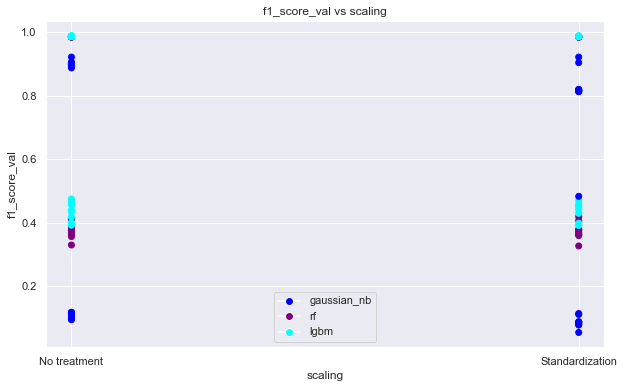

In [116]:
to_plot = all_results_df[(all_results_df['test_name'].isin(['no_class_weight_kfold_10_all_num_all_onehot_no_colinearity',
                                                           'Satandarization_no_class_weight_kfold_10_all_num_all_onehot_no_colinearity'])) &
                        (all_results_df['undersample_ratio'] == '15:1') &
                        
                        (all_results_df['fold'] != 'aggregate')]

# Plot results by undersample ratio
by_var = 'scaling'
plot_results_by_column(to_plot, by_var, 'f1_score_val')

In [117]:
# Calculate the statistics
statistics = to_plot[to_plot['class'] == 1].groupby([by_var])['f1_score_val'].agg(['mean','median', 'std', 'min', 'max', 'count'])

# Apply conditional formatting to highlight the largest values in each column
# And display the styled table
highlight_statistics(statistics)

,mean,median,std,min,max,count
scaling,,,,,,
No treatment,0.307680,0.372100,0.147633,0.095000,0.475300,30
Standardization,0.298427,0.372100,0.155783,0.054700,0.471100,30


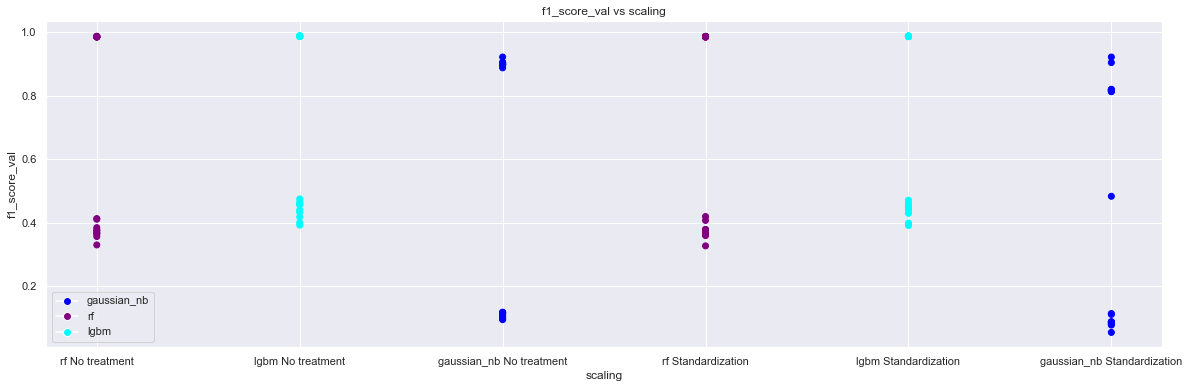

In [118]:
# Plot results by undersample ratio
plot_results_by_column_model(to_plot, 'scaling', 'f1_score_val')

In [119]:
# Calculate the statistics
statistics = to_plot[to_plot['class'] == 1].groupby([by_var, 'model_name'])['f1_score_val'].agg(['mean', 'median', 'std', 'min', 'max', 'count'])

# Apply conditional formatting to highlight the largest values in each column
# And display the styled table
highlight_statistics(statistics)

### <font color='313187'>Overfitting check<font><a class='anchor' id='Overfitting'></a> [↑](#top)

We can clearly see that random forest is overfitting and that gaussian naive bayes is not performing well most probably because the most important variables doesn't follow a gaussian distribution. Hence, we will select lgbm as best model and continue our test only with this model.

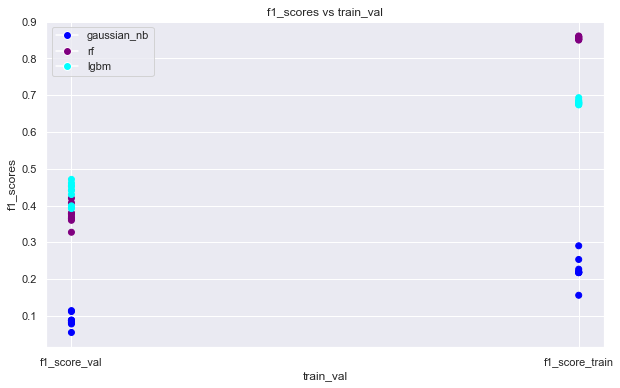

In [120]:
# Create a new DataFrame in long format
train_val_subset = all_results_df[(all_results_df['class'] == 1) &
                                 (all_results_df['test_name'] == 'Satandarization_no_class_weight_kfold_10_all_num_all_onehot_no_colinearity') & 
                                 (all_results_df['undersample_ratio'] == '15:1') &
                                 #(all_results_df['model_name'] == 'lgbm') &
                                  (all_results_df['class_weight'] == False) &
                        
                                (all_results_df['fold'] != 'aggregate')]

train_val_df = pd.melt(train_val_subset, id_vars=['model_name'],
                  value_vars=['f1_score_val', 'f1_score_train'],
                  var_name='train_val', value_name='f1_scores')

plot_results_by_column(train_val_df, 'train_val',  'f1_scores')

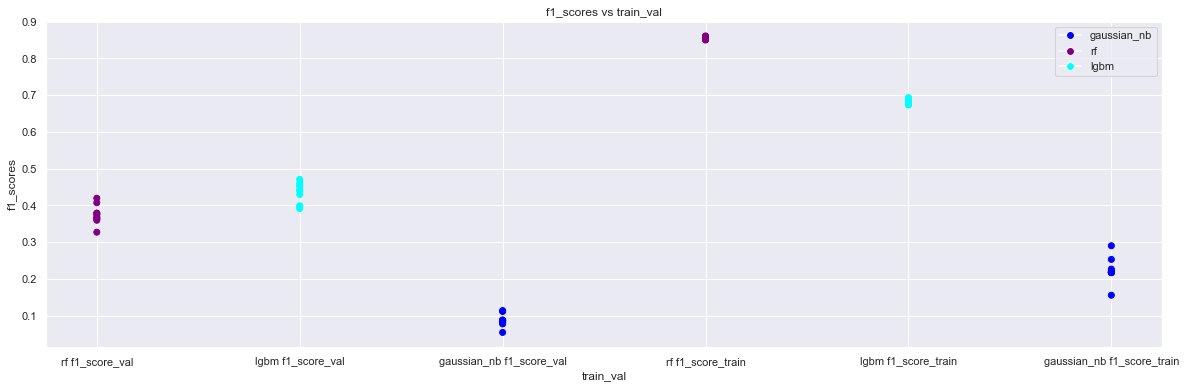

In [121]:
# Plot results by undersample ratio
plot_results_by_column_model(train_val_df, 'train_val',  'f1_scores')

In [122]:
train_val_df.head()

,model_name,train_val,f1_scores,x_model
0,rf,f1_score_val,0.3753,rf f1_score_val
1,rf,f1_score_val,0.3790,rf f1_score_val
2,rf,f1_score_val,0.4198,rf f1_score_val
3,rf,f1_score_val,0.4075,rf f1_score_val
4,rf,f1_score_val,0.3789,rf f1_score_val


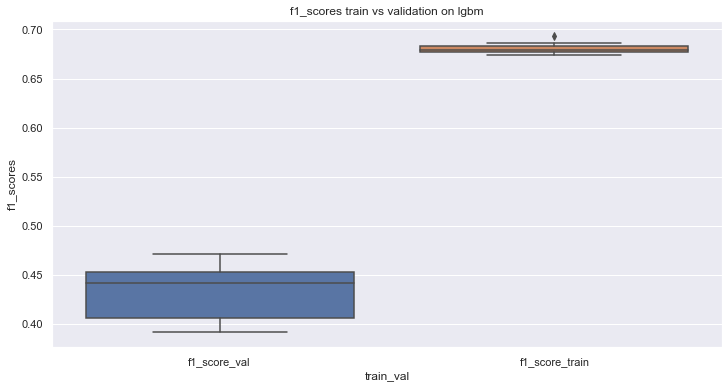

In [123]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Add a new column for the concatenation of model_name and x_column
train_val_df['x_model'] = train_val_df['model_name'] + ' ' + train_val_df['f1_scores'].astype(str)

plt.figure(figsize=(12, 6))  # Set the figure size

# Create the boxplot using matplotlib
to_plot = train_val_df[train_val_df['model_name'] =='lgbm']
sns.boxplot(data=to_plot, x='train_val', y='f1_scores')

plt.xlabel('train_val')
plt.ylabel('f1_scores')
plt.title('f1_scores train vs validation on lgbm')

plt.show()



### <font color='313187'>Variable selection on best test combination<font><a class='anchor' id='VarSelectionTest'></a> [↑](#top)

From this point onwards, we will perform tests in order to keep the minimum variables as possible that gives us the best results. To do that we will keep stable k = 10, undersample method with 15:1 ratio and lgbm as a model and we will also keep the scaling method as it will be needed for the clustering later and it doesn't have a huge impact on the results of the classification on lgbm.

From this results we can see that the PCA does not help with the performance. We will keep the best 15 variables as is the variable selection that has less variable performing better.

In [26]:
### Plot styling
#import seaborn as sns; sns.set()  # for plot styling
#%matplotlib inline
#plt.style.use('ggplot')
sns.set(font_scale=1)

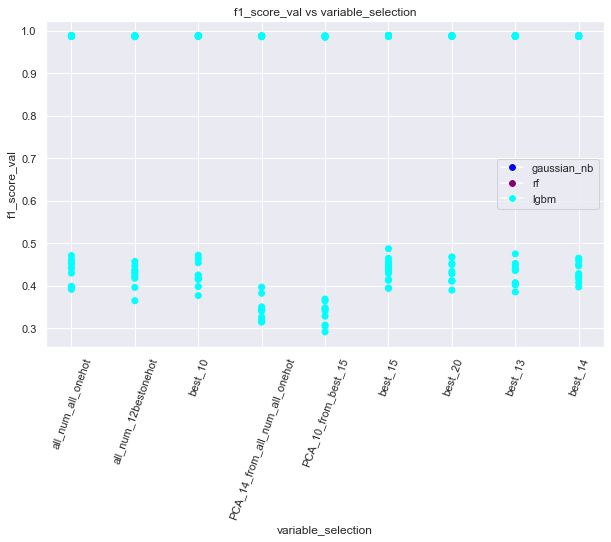

In [27]:
to_plot = all_results_df[(all_results_df['test_name'].str.startswith('LGBM')) &
                         (all_results_df['undersample_ratio'] == '15:1') &
                        
                         (all_results_df['fold'] != 'aggregate')]

# Plot results by undersample ratio
by_var = 'variable_selection'
plot_results_by_column(to_plot, by_var, 'f1_score_val')


In [30]:
# Calculate the statistics
statistics = to_plot[(to_plot['class'] == 1)].groupby([by_var])['f1_score_val'].agg(['mean','median', 'std', 'min', 'max', 'count'])

# Apply conditional formatting to highlight the largest values in each column
# And display the styled table
highlight_statistics(statistics)

,mean,median,std,min,max,count
variable_selection,,,,,,
PCA_10_from_best_15,0.334580,0.342800,0.025800,0.291600,0.368900,10
PCA_14_from_all_num_all_onehot,0.343530,0.341150,0.027675,0.314700,0.396900,10
all_num_12bestonehot,0.423540,0.429100,0.026505,0.364900,0.457300,10
all_num_all_onehot,0.433730,0.441600,0.028805,0.391700,0.471100,10
best_10,0.426370,0.420950,0.029472,0.377000,0.472000,10
best_13,0.429350,0.437450,0.027836,0.385500,0.475100,10
best_14,0.431620,0.426050,0.022741,0.397300,0.465200,10
best_15,0.437595,0.439150,0.021863,0.394400,0.487100,20
best_20,0.432370,0.430900,0.026526,0.389900,0.467800,10


### <font color='313187'>Hyperparameter tunning on best model, parameters and variable selection<font><a class='anchor' id='HyperparameterTunning'></a> [↑](#top)

Overall, the lgbm model is the one that performs better and does not overfit. Hence, we will proceed with this model for hyperparameter tuning. 

We will first set a base to compare checking the results of the default hyperparameters on the validation set:

In [39]:
# Load the saved dictionary from the file
path = 'C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/MASTER/UOC/16 - Projecte final de master/outputs_dataframe/'
with open(path + 'fold_data.pickle', 'rb') as file:
    fold_data = pickle.load(file)


In [41]:
# Get train and validation data
X_train_hyper = fold_data['X_train']
y_train_hyper = fold_data['y_train']
X_val_hyper = fold_data['X_val']
y_val_hyper = fold_data['y_val']

# Define the undersampler
ratio = 15
undersampling_ratio = min(len(y_train_hyper[y_train_hyper==1])*ratio, len(y_train_hyper[y_train_hyper==0]))
undersampler = RandomUnderSampler(sampling_strategy={0: undersampling_ratio, 1: len(y_train_hyper[y_train_hyper==1])},
                                  random_state=42)

# Undersample the training set
X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train_hyper, y_train_hyper)


model = lgbm.LGBMClassifier(random_state=42)
   
# Fit the model to the data
model.fit(X_train_undersampled, y_train_undersampled)
    
# Get results
y_train_pred = model.predict(X_train_undersampled)
y_val_pred = model.predict(X_val_hyper)
cr_val = classification_report(y_val_hyper, y_val_pred, output_dict=True)
cr_train = classification_report(y_train_undersampled, y_train_pred, output_dict=True)

f1_score_train_base = round(cr_train['1']['f1-score'],4)
f1_score_val_base = round(cr_val['1']['f1-score'],4)
print('BASE F1_score train:')
print(f1_score_train_base)
print()
print('BASE F1_score validation:')
print(f1_score_val_base)

BASE F1_score train:
0.6802

BASE F1_score validation:
0.4362


In [52]:
from optuna.integration import LightGBMPruningCallback
import optuna
import warnings

# Suppress LightGBM warning messages
warnings.filterwarnings("ignore", category=UserWarning)

def objective(trial, fold_data):
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
       # "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
     #   "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 10000, step=100),
     #   "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
     #   "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
     #   "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
     #   "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 0.95, step=0.1),
     #   "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
     #  "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95, step=0.1),
    }

    count = sum(key.startswith('fold') for key in fold_data.keys())
    cv_scores = np.empty(count)
    for fold_key, fold_data_x in fold_data.items():
        # Select only the folds keys in the dictionary
        if fold_key.startswith('fold'):
            # Get the validation sets for the current fold
            X_test = fold_data_x['X_cross_val']
            y_test = fold_data_x['y_cross_val']
            X_train = fold_data_x['undersampled_train']['15:1'][0]
            y_train = fold_data_x['undersampled_train']['15:1'][1]

            model = lgbm.LGBMClassifier(objective="binary", **param_grid, verbose=-1)
            model.fit(
                X_train,
                y_train,
                eval_set=[(X_test, y_test)],
                eval_metric="f1",
                early_stopping_rounds=100,
                #callbacks=[LightGBMPruningCallback(trial, "binary_logloss")],  # Add a pruning callback
            )
            y_test_pred = model.predict(X_test)

            cr_val = classification_report(y_test, y_test_pred, output_dict=True) 
            fold_idx = int(fold_key.split('_')[1])
            cv_scores[fold_idx - 1] = cr_val['1']['f1-score']

    return np.mean(cv_scores)

In [54]:
study = optuna.create_study(direction="maximize", study_name="LGBM Classifier_no_scaling")
func = lambda trial: objective(trial, fold_data)

[I 2023-05-28 08:43:41,202] A new study created in memory with name: LGBM Classifier_no_scaling


In [55]:
import io
import sys
import logging

#%%time

# Create a dummy StringIO object to redirect output
dummy_output = io.StringIO()

# Store the original stdout and stderr
original_stdout = sys.stdout
original_stderr = sys.stderr

# Redirect stdout and stderr to the dummy output
sys.stdout = dummy_output
sys.stderr = dummy_output

# Disable logging messages from Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Run the optimization process
study.optimize(func, n_trials=300) #300 +

# Restore the original stdout and stderr
sys.stdout = original_stdout
sys.stderr = original_stderr


In [60]:
print(f"Base f1-score    : {f1_score_val_base:.4f}")
print(f"\tBest value (f1-score): {study.best_value:.4f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

Base f1-score    : 0.4362
	Best value (f1-score): 0.4495
	Best params:
		learning_rate: 0.2057695271449768
		num_leaves: 2380
		min_data_in_leaf: 720


In [78]:
# Retrieve the best parameters from the study
best_params = study.best_params

# Create the LightGBM classifier with the best parameters
model = lgbm.LGBMClassifier(random_state=42, **best_params)
   
# Fit the model to the data
model.fit(X_train_undersampled, y_train_undersampled)
    
# Get results
y_train_pred = model.predict(X_train_undersampled)
y_val_pred = model.predict(X_val_hyper)

cr_train = classification_report(y_train_undersampled, y_train_pred, output_dict=True)
cr_val = classification_report(y_val_hyper, y_val_pred, output_dict=True)

f1_score_train_hyper = round(cr_train['1']['f1-score'],4)
f1_score_val_hyper = round(cr_val['1']['f1-score'],4)
print('F1_score minority class train BASE:')
print(f1_score_train_base)
print()
print('F1_score minority class validation BASE:')
print(f1_score_val_base)
print()
print('F1_score minority class training Hyperparameter tuning:')
print(f1_score_train_hyper)
print()
print('F1_score minority class validation Hyperparameter tuning:')
print(f1_score_val_hyper)



y_train_prob = model.predict_proba(X_train_undersampled)[:, 1]
y_val_prob = model.predict_proba(X_val_hyper)[:, 1]

[LightGBM] [Warning] min_data_in_leaf is set=720, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=720
F1_score train BASE:
0.6802

F1_score validation BASE:
0.4362

F1_score training Hyperparameter tunning:
0.645

F1_score validation Hyperparameter tunning:
0.4422


In [44]:
# Retrieve the best parameters from the study
best_params = study.best_params

# Create the LightGBM classifier with the best parameters
model = lgbm.LGBMClassifier(random_state=42, **best_params)
   
# Fit the model to the data
model.fit(X_train_undersampled, y_train_undersampled)
 
X_test_hyper = fold_data['X_test']
y_test_hyper = fold_data['y_test']

y_test_pred = model.predict(X_test_hyper)

cr_test = classification_report(y_test_hyper, y_test_pred, output_dict=True)


f1_score_test_hyper = round(cr_test['1']['f1-score'],4)
print('F1_score minority class test set:')
print(f1_score_test_hyper)

# Get predicted probabilities
y_test_prob = model.predict_proba(X_test_hyper)[:, 1]

[LightGBM] [Warning] min_data_in_leaf is set=720, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=720
F1_score minority class test set:
0.4288


In [62]:
## Save models

# Create a directory to save the files if it doesn't exist
save_dir = 'C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/MASTER/UOC/16 - Projecte final de master/models'

# Save the trained model
model_path = os.path.join(save_dir, 'trained_model.pkl')
joblib.dump(model, model_path)

# Save the Optuna study object
study_path = os.path.join(save_dir, 'optuna_study.pkl')
with open(study_path, 'wb') as f:
    pickle.dump(study, f)

In [58]:
## Read models

save_dir = 'C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/MASTER/UOC/16 - Projecte final de master/models'

# Load the trained model
model_path = save_dir + '/trained_model.pkl'  # Update with the actual file path
model = joblib.load(model_path)

# Load the Optuna study object
study_path = save_dir + '/optuna_study.pkl'  # Update with the actual file path
with open(study_path, 'rb') as f:
    study = pickle.load(f)

### <font color='313187'>Extracting Business Insights<font><a class='anchor' id='BusinessInsights'></a> [↑](#top)

#### <font color='313187'>SHAP Summary Plot- LightGBM<font><a class='anchor' id='ShapSummary'></a> [↑](#top)

In [96]:
#!pip install numpy==1.20
#!pip install --user shap
#import shap

In [97]:
#explainerlgbmc = shap.TreeExplainer(model)
#shap_values_LightGBM_test = explainerlgbmc.shap_values(X_test)
#shap_values_LightGBM_train = explainerlgbmc.shap_values(X_train)

In [ ]:
#shap.summary_plot(shap_values_LightGBM_train, X_train, plot_type="bar")

#### <font color='313187'>Visualizing Aggregated Trees from the Model<font><a class='anchor' id='PlotTree'></a> [↑](#top)

In [32]:
# Get number of trees
num_trees = model.n_estimators
print(f"The number of trees in the model: {num_trees}")

The number of trees in the model: 100


In [37]:
path = 'C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/MASTER/UOC/16 - Projecte final de master/imatges'

<Figure size 5760x4320 with 0 Axes>

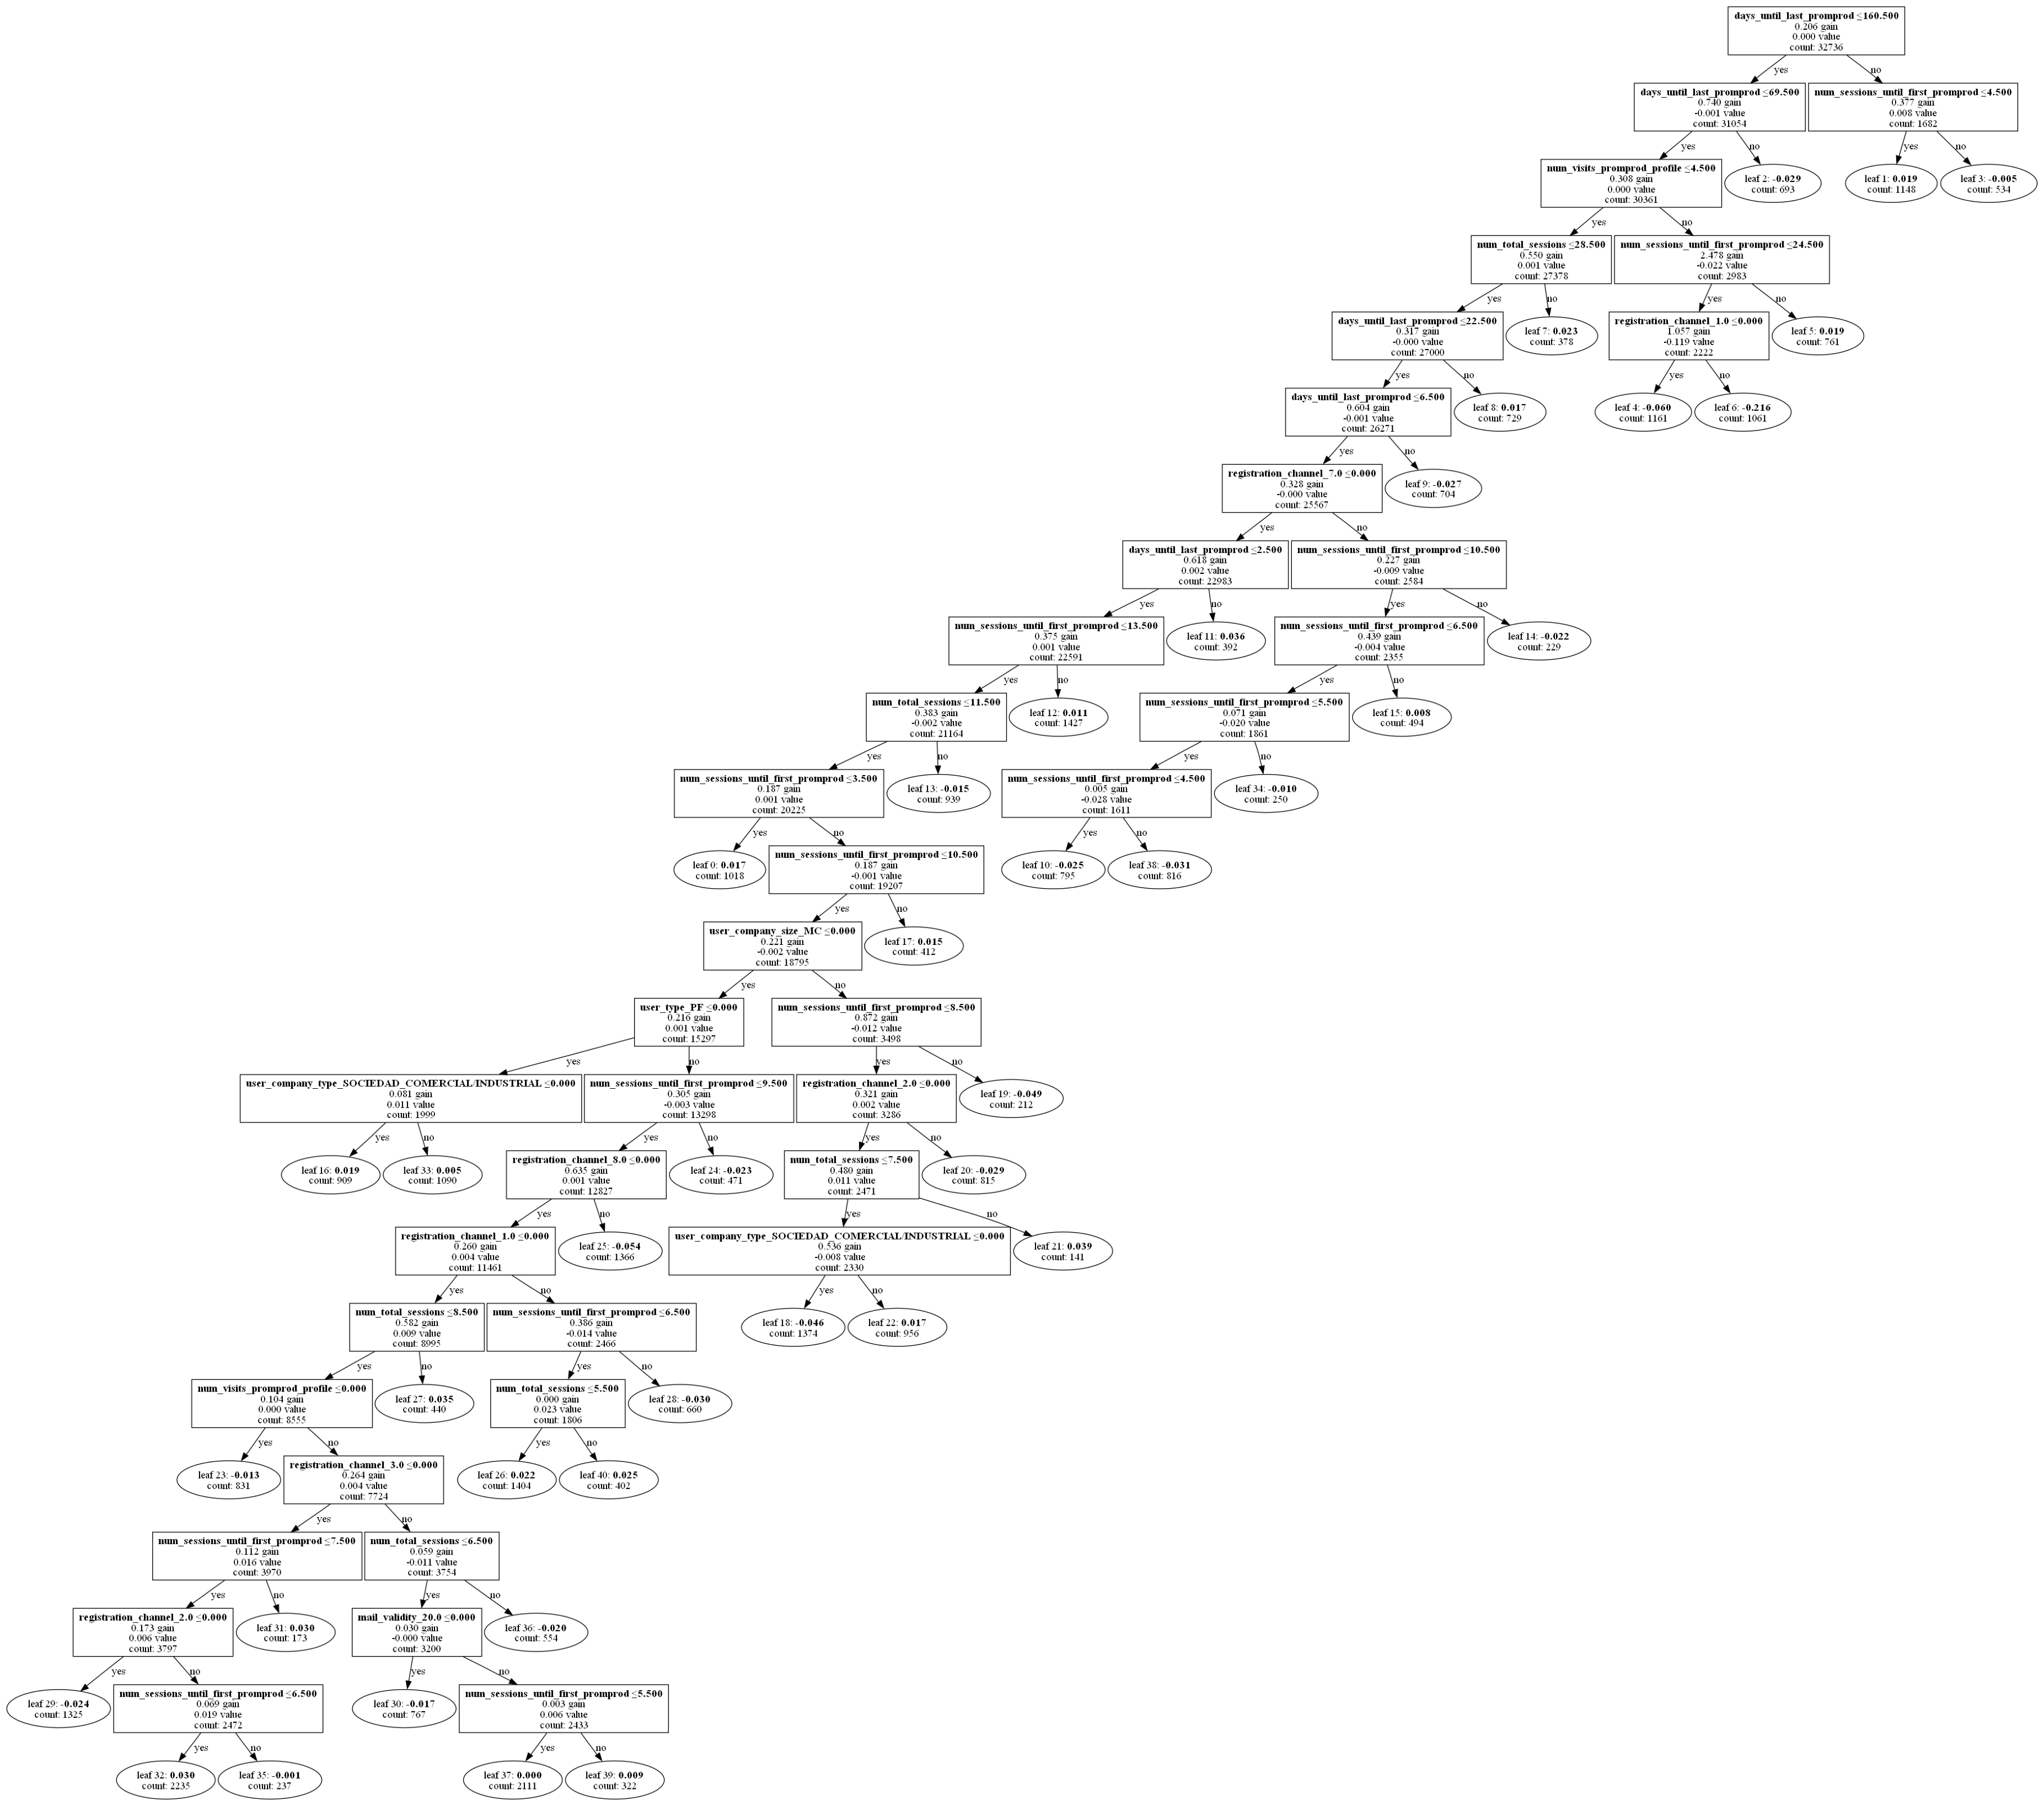

In [61]:
#### 
# Get the tree index of the tree you want to plot (e.g., tree_index=0 for the first tree)
tree_index = -1 # -1 is the ensemble from 0 to 99 are the individual trees.

# Plot the ensemble of trees
plt.figure(figsize=(80, 60))
lgbm.plot_tree(model, tree_index= tree_index, figsize=(80, 60), show_info=['probability','split_gain','internal_value','internal_count','leaf_value','leaf_count'], orientation='vertical')

# Save the plot as an image file with higher DPI
plt.savefig(path + '/ensemble_tree.png', dpi=400)  # Adjust DPI value as desired

# Display the plot
plt.show()